In [471]:
!pip install libpysal esda geopandas scikit-posthocs

In [472]:
import pandas as pd
import geopandas as gpd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.colors as mcolors
import warnings
import matplotlib.patches as mpatches
import os
import networkx as nx
import itertools

In [473]:
# 读取 CSV 文件
df = pd.read_csv('df.csv')

df = df.rename(columns={'province_code': 'pro_code', 'province_eng': 'pro_eng'})

print(df.head())

   row   col         lon        lat     access  population  nightlight  \
0   65  5870  122.486250  53.012083  44.053375    5.954192    0.661167   
1   66  5869  122.477916  53.003750  46.434662   21.411476    1.114167   
2   66  5870  122.486250  53.003750  47.095318   29.500462    0.795162   
3   67  5869  122.477916  52.995417  46.268105   41.609238    0.560761   
4   67  5870  122.486250  52.995417  48.069366   51.930847    0.705970   

   pro_code  city_code   region       pro_eng  
0    230000     232700  Central  Heilongjiang  
1    230000     232700  Central  Heilongjiang  
2    230000     232700  Central  Heilongjiang  
3    230000     232700  Central  Heilongjiang  
4    230000     232700  Central  Heilongjiang  


In [474]:
china = gpd.read_file("china.shp")

print(china.head())

     省 pro_code    市 city_code  市类型 省类型        面积   region pro_eng  \
0  安徽省   340000  安庆市    340800  地级市   省  13488.80  Central   Anhui   
1  安徽省   340000  蚌埠市    340300  地级市   省   5968.40  Central   Anhui   
2  安徽省   340000  亳州市    341600  地级市   省   8526.44  Central   Anhui   
3  安徽省   340000  池州市    341700  地级市   省   8396.90  Central   Anhui   
4  安徽省   340000  滁州市    341100  地级市   省  13516.30  Central   Anhui   

                                            geometry  
0  POLYGON ((1128887.733 3379327.99, 1129097.606 ...  
1  POLYGON ((1115664.2 3634752.93, 1115765.856 36...  
2  POLYGON ((973682.546 3682450.136, 974036.962 3...  
3  POLYGON ((1221695.548 3343994.786, 1221192.108...  
4  POLYGON ((1209319.815 3605758.239, 1209401.699...  


In [475]:
df["city_code"] = df["city_code"].astype(str)

china["city_code"] = china["city_code"].astype(str)

In [476]:
num_cities = df['city_code'].nunique()
print(f"Number of cities: {num_cities}")

Number of cities: 360


In [477]:
print(f"Number of communities: {len(df)}")

Number of communities: 100798


# 1. Distribution patterns and within-city variation in healthcare accessibility

## Distribution across nationwide and provinces

In [479]:
df['access'].describe()

count    100798.000000
mean         49.894824
std          23.516739
min           0.000000
25%          33.308965
50%          47.336565
75%          63.479943
max         122.391075
Name: access, dtype: float64

In [480]:
df_result = (
    df
    .groupby(["region", "pro_eng"], as_index=False)["access"]
    .median()
    .sort_values(["region", "access"], ascending=[True, False])
)

df_result

,region,pro_eng,access
1,Central,Heilongjiang,62.080231
3,Central,Hubei,59.664719
4,Central,Hunan,58.220499
6,Central,Jilin,57.925615
0,Central,Anhui,51.050358
2,Central,Henan,44.371037
7,Central,Shanxi,38.257130
5,Central,Jiangxi,38.008858
14,East,Liaoning,65.990059
11,East,Hainan,65.500366


## Correlation analysis

In [481]:
# 1️⃣ 每个城市的社区数量
city_counts = (
    df.groupby('city_code')
      .size()
      .reset_index(name='community_count')
)

# 2️⃣ 每个城市所属 region
city_region = (
    df.groupby('city_code')['region']
      .first()
      .reset_index()
)

# 3️⃣ 合并
city_counts = city_counts.merge(city_region, on='city_code')

# 4️⃣ 在每个 region 中找社区数量最多的城市
idx = city_counts.groupby('region')['community_count'].idxmax()
top_cities = city_counts.loc[idx]

top_cities

,city_code,community_count,region
50,220100,1254,Central
0,110000,2268,East
251,500000,1286,West


In [482]:
# 高亮城市
df_filtered = df[df['population'] >= 30].copy()
df_filtered["log_population"] = np.log(df_filtered["population"])

highlight_cities = ['110000', '220100', '500000']
city_name_map = {'110000': 'Beijing', '220100': 'Changchun', '500000': 'Chongqing'}

# --------------------------
# 全国整体回归
# --------------------------
X = sm.add_constant(df_filtered['log_population'])
y = df_filtered['access']
model = sm.OLS(y, X).fit()

# 输出系数和95% CI
print("=== National Overall Regression ===")
print("Coef:", model.params['log_population'])
print("p-value:", model.pvalues['log_population'])
print("95% CI:", model.conf_int().loc['log_population'].values)

# --------------------------
# 高亮城市回归
# --------------------------
for city_code in highlight_cities:
    city_data = df_filtered[df_filtered['city_code'] == city_code]
    if len(city_data) > 1:
        Xc = sm.add_constant(city_data['log_population'])
        yc = city_data['access']
        model_c = sm.OLS(yc, Xc).fit()
        print(f"\n=== {city_name_map[city_code]} Regression ===")
        print("Coef:", model_c.params['log_population'])
        print("p-value:", model_c.pvalues['log_population'])
        print("95% CI:", model_c.conf_int().loc['log_population'].values)

=== National Overall Regression ===
Coef: 6.964643294819126
p-value: 0.0
95% CI: [6.86019273 7.06909386]

=== Beijing Regression ===
Coef: 9.0849718233921
p-value: 0.0
95% CI: [8.7152484  9.45469525]

=== Changchun Regression ===
Coef: 17.678109322941015
p-value: 1.5691563735502632e-188
95% CI: [16.69017824 18.66604041]

=== Chongqing Regression ===
Coef: 16.614703799153823
p-value: 3.2612016342362034e-188
95% CI: [15.68070766 17.54869994]


## Coefficient of variation (CV)

In [483]:
def cv(group, value_col='access'):
    """
    计算未加权（普通）的变异系数（CV）
    CV = standard deviation / mean

    所有社区等权，不考虑人口权重
    """
    values = group[value_col].values

    # 防止极端情况
    if len(values) == 0:
        return np.nan

    mean_val = np.mean(values)
    if mean_val == 0:
        return np.nan

    # 使用样本标准差（ddof=1），统计上更规范
    std_val = np.std(values, ddof=1)

    return std_val / mean_val


# -------------------------
# 分城市计算未加权 CV
# -------------------------
df_city_cv_unweighted = (
    df
    .groupby('city_code')[['access']]
    .apply(cv)
    .reset_index(name='cv_access')
)

In [485]:
df_city_cv_unweighted['cv_access'].describe()

count    360.000000
mean       0.330701
std        0.182088
min        0.003744
25%        0.209401
50%        0.305845
75%        0.404464
max        1.358662
Name: cv_access, dtype: float64

In [486]:
bins = [0, 0.2, 0.4, 0.6, 0.8, np.inf]
labels = ['0–0.2', '0.2–0.4', '0.4–0.6','0.6–0.8', '≥0.8']

cv_bins = pd.cut(
    df_city_cv_unweighted['cv_access'],
    bins=bins,
    labels=labels,
    right=False,          # 左闭右开
    include_lowest=True
)

count_by_bin = cv_bins.value_counts().sort_index()

count_by_bin

cv_access
0–0.2       79
0.2–0.4    187
0.4–0.6     67
0.6–0.8     21
≥0.8         6
Name: count, dtype: int64

In [487]:
(79+187)/360

0.7388888888888889

In [488]:
df_city_cv_unweighted = df_city_cv_unweighted.merge(
    china[["city_code", "region"]],
    on="city_code",
    how="left"
)

In [489]:
df_east = df_city_cv_unweighted[df_city_cv_unweighted["region"] == "East"].copy()
df_central = df_city_cv_unweighted[df_city_cv_unweighted["region"] == "Central"].copy()
df_west = df_city_cv_unweighted[df_city_cv_unweighted["region"] == "West"].copy()

In [490]:
df_east['cv_access'].describe()

count    116.000000
mean       0.268318
std        0.134912
min        0.036072
25%        0.190474
50%        0.258310
75%        0.335558
max        0.697101
Name: cv_access, dtype: float64

In [491]:
df_central['cv_access'].describe()

count    109.000000
mean       0.320872
std        0.130500
min        0.003744
25%        0.238805
50%        0.300724
75%        0.387553
max        0.773382
Name: cv_access, dtype: float64

In [492]:
df_west['cv_access'].describe()

count    135.000000
mean       0.392239
std        0.228515
min        0.022466
25%        0.232052
50%        0.361597
75%        0.507430
max        1.358662
Name: cv_access, dtype: float64

## Fig.1

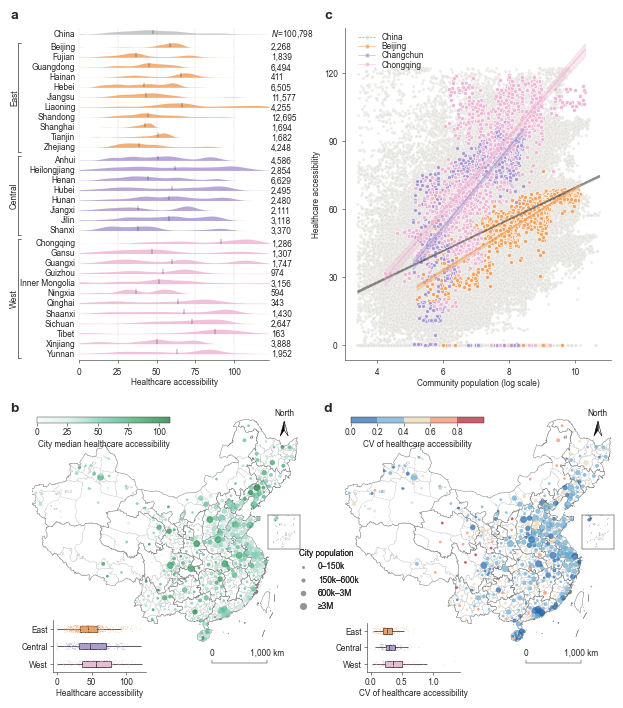

In [493]:
from matplotlib.gridspec import GridSpec
from scipy.stats import gaussian_kde
from shapely.ops import unary_union, linemerge
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.transforms import Affine2D
from matplotlib.patches import Polygon
from matplotlib.colors import (
    LinearSegmentedColormap,
    Normalize,
    ListedColormap,
    BoundaryNorm
)
from matplotlib.lines import Line2D

np.random.seed(42)

rc = {
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"],
    "font.size": 6,
    "axes.labelsize": 6,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "legend.fontsize": 6,
    "font.weight": "normal",
    "axes.labelweight": "normal",
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "axes.unicode_minus": False
}

with mpl.rc_context(rc):
    sns.set_theme(context="paper", style="white", rc=rc)


# ======================================================
# 0️⃣ Figure & GridSpec  ——【唯一结构性修改】
# ======================================================
MM_TO_INCH = 1 / 25.4
fig_w_in = 160 * MM_TO_INCH
fig_h_in = (fig_w_in)/7*8

fig = plt.figure(figsize=(fig_w_in, fig_h_in))

gs = GridSpec(
    nrows=2,
    ncols=2,
    width_ratios=[1, 1],
    height_ratios=[1, 1],   # ⭐ 两行均分原高度 → 子图自然变“长”
    wspace=0.18,
    hspace=0.02
)

# ⭐ 按「列」定义顺序
axes = [
    fig.add_subplot(gs[0, 0]),  # a
    fig.add_subplot(gs[1, 0]),  # b
    fig.add_subplot(gs[0, 1]),  # d
    fig.add_subplot(gs[1, 1])   # e
]


# ======================================================
# 1️⃣ 子图 a
# ======================================================

# ===============================
# 全局绘图参数
# ===============================
MAX_HALF_WIDTH = 0.45
VIOLIN_ALPHA = 0.85
MEDIAN_LW = 0.3
LABEL_FONTSIZE = 6
GAP = 0.3

# ===============================
# 0️⃣ 分块省份顺序
# ===============================
china_block = ['China']
east_block = (
    df.loc[df['region'] == 'East', 'pro_eng']
      .drop_duplicates().sort_values().tolist()
)
central_block = (
    df.loc[df['region'] == 'Central', 'pro_eng']
      .drop_duplicates().sort_values().tolist()
)
west_block = (
    df.loc[df['region'] == 'West', 'pro_eng']
      .drop_duplicates().sort_values().tolist()
)

province_blocks = [china_block, east_block, central_block, west_block]

# ===============================
# 1️⃣ province_order & y_positions
# ===============================
province_order, y_positions = [], []
y = 0
for block in province_blocks:
    for p in block:
        province_order.append(p)
        y_positions.append(y)
        y += 1
    y += GAP

# ===============================
# 2️⃣ access 数据
# ===============================
group_values = {'China': df['access'].dropna().values}
for prov in df['pro_eng'].dropna().unique():
    group_values[prov] = df.loc[df['pro_eng'] == prov, 'access'].dropna().values

# ===============================
# 3️⃣ 社区数量
# ===============================
group_counts = {'China': df.shape[0]}
for prov in df['pro_eng'].dropna().unique():
    group_counts[prov] = df.loc[df['pro_eng'] == prov].shape[0]

# ===============================
# 4️⃣ 颜色
# ===============================
region_colors = {
    'China': '#BDBDBD',
    'East':  "#F1A25E",
    'Central': "#AC99D2",
    'West':  "#EEB7D3"
}

province_region = (
    df[['pro_eng', 'region']]
    .drop_duplicates()
    .set_index('pro_eng')['region']
)

def get_color(group):
    return region_colors['China'] if group == 'China' else region_colors[province_region[group]]

# ===============================
# 5️⃣ KDE 网格 & 画布
# ===============================
x_grid = np.linspace(df['access'].min(), df['access'].max(), 400)
ax = axes[0]  

# ===============================
# 6️⃣ half violin
# ===============================
for y, group in zip(y_positions, province_order):
    values = group_values.get(group)
    if values is None or len(values) < 20:
        continue

    kde = gaussian_kde(values)
    density = kde(x_grid)
    density = density / density.max() * MAX_HALF_WIDTH

    ax.fill_between(x_grid, y, y - density,
                    color=get_color(group), alpha=VIOLIN_ALPHA, linewidth=0)

    med = np.median(values)
    ax.plot([med, med], [y, y - MAX_HALF_WIDTH],
            color='black', lw=MEDIAN_LW, alpha=0.8)

# ===============================
# 7️⃣ 坐标轴（数据轴到 max，右侧留白无轴）
# ===============================
x_data_min = df['access'].min()
x_data_max = df['access'].max()
x_range = x_data_max - x_data_min

ax.set_xlim(
    x_data_min - 0.25 * x_range,
    x_data_max + 0.15 * x_range
)

# ✅ 只用这一句反向 y 轴，不要再 invert
ax.set_ylim(max(y_positions) + 0.6, -0.6)

ax.set_yticks(y_positions)
ax.set_yticklabels([])
ax.tick_params(axis='y', which='both', left=False, right=False, length=0, width=0)


# ===============================
# ⭐ 手动绘制省份名（data 坐标，右对齐，稳定可控）
# ===============================

# 省份名右边缘 = 数据区左边界 + 一个很小的 data 偏移
label_offset_data = 0.02 * x_range

for y, prov in zip(y_positions, province_order):
    ax.text(
        x_data_min - label_offset_data,
        y,
        prov,
        ha='right',        # ✅ 右对齐
        va='center',
        fontsize=LABEL_FONTSIZE,
        clip_on=False
    )

# ======================================================
# spine / ticks / grid 只作用在【数据区】
# ======================================================

# —— bottom spine 只画到数据 max ——
ax.spines['bottom'].set_bounds(x_data_min, x_data_max)

for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)
ax.spines['bottom'].set_linewidth(0.4)

# —— x ticks 只保留数据区 ——
ticks = ax.get_xticks()
ticks = ticks[(ticks >= x_data_min) & (ticks <= x_data_max)]
ax.set_xticks(ticks)

ax.tick_params(
    axis='x',
    which='major',
    direction='out',
    length=2,
    width=0.4,
    bottom=True,
    top=False
)

# —— grid 只在数据区画 ——
for x in ticks:
    ax.axvline(
        x,
        color='grey',
        linestyle='--',
        linewidth=0.3,
        alpha=0.4,
        zorder=0
    )

# —— 轴标签 —— 
x_data_center = 0.5 * (x_data_min + x_data_max)
x_center_ax = ax.transAxes.inverted().transform(
    ax.transData.transform((x_data_center, 0))
)[0]

ax.set_xlabel( "Healthcare accessibility", fontsize=LABEL_FONTSIZE ) 

ax.xaxis.set_label_coords(
    x_center_ax, # 👈 数据区中心 
    -0.055 # 👈 在 x 轴下面（可微调） 
    )

ax.set_ylabel("")

# ===============================
# 8️⃣ 右侧 N（仅第一行显示 N=）
# ===============================
for i, (y, group) in enumerate(zip(y_positions, province_order)):
    if i == 0:
        text = rf"$\mathit{{N}}$={group_counts.get(group, 0):,}"
    else:
        text = f"{group_counts.get(group, 0):,}"

    ax.text(
        0.90, y,
        text,
        va='center',
        ha='left',
        fontsize=LABEL_FONTSIZE,
        transform=ax.get_yaxis_transform()
    )

# ===============================
# 9️⃣ 地区框架
# ===============================
region_blocks = {
    "East": east_block,
    "Central": central_block,
    "West": west_block
}

# —— 基于数据坐标的 x 位置（与省份名逻辑一致）——
x_brace = x_data_min - 0.32 * (x_data_max - x_data_min)
x_label = x_data_min - 0.34 * (x_data_max - x_data_min)

for region, provs in region_blocks.items():
    idxs = [province_order.index(p) for p in provs if p in province_order]
    if not idxs:
        continue

    y_start = min(y_positions[i] for i in idxs)
    y_end   = max(y_positions[i] for i in idxs)

    # —— 竖向括号主线 ——
    ax.plot(
        [x_brace, x_brace],
        [y_start - 0.45, y_end + 0.45],
        color="black",
        lw=0.4,
        clip_on=False
    )

    # —— 上横线 ——
    ax.plot(
        [x_brace, x_brace + 0.015 * (x_data_max - x_data_min)],
        [y_start - 0.45, y_start - 0.45],
        color="black",
        lw=0.4,
        clip_on=False
    )

    # —— 下横线 ——
    ax.plot(
        [x_brace, x_brace + 0.015 * (x_data_max - x_data_min)],
        [y_end + 0.45, y_end + 0.45],
        color="black",
        lw=0.4,
        clip_on=False
    )

    # —— 地区名称 ——
    ax.text(
    x_label,
    (y_start + y_end) / 2,
    region,
    va="center",
    ha="center",        # ⭐ 旋转后建议用 center
    fontsize=LABEL_FONTSIZE,
    rotation=90,        # ⭐ 关键：整体旋转
    clip_on=False
)

# ======================================================
# 子图 b
# ======================================================

# ===========================
# 1️⃣ 城市层面统计
# ===========================
city_total_pop = df.groupby("city_code")["population"].sum()
city_median_access = df.groupby("city_code")["access"].median()

china["total_population"] = china["city_code"].map(city_total_pop)
china["city_median_access"] = china["city_code"].map(city_median_access)

# ===========================
# 2️⃣ 城市人口分级 → 圆圈大小
# ===========================
china["population_category"] = pd.cut(
    china["total_population"],
    bins=[0, 150_000, 600_000, 3_000_000, np.inf],
    labels=["0–150k", "150k–600k", "600k–3M", "≥3M"],
    right=False,
    include_lowest=True
)

size_map = {
    "0–150k": 4,
    "150k–600k": 8,
    "600k–3M": 15,
    "≥3M": 25
}
china["circle_size"] = china["population_category"].map(size_map).astype(float)

# ===========================
# 3️⃣ 城市代表点
# ===========================
china["rep_point"] = china.geometry.representative_point()
china_with_data = china[china["city_median_access"].notna()].copy()
china_with_data.set_geometry("rep_point", inplace=True)

# ===========================
# 4️⃣ 连续色带
# ===========================
teal_cmap = LinearSegmentedColormap.from_list(
    "teal",
    ["#f0f9f8", "#ccece6", "#66c2a4", "#2ca25f", "#006d2c"]
)

norm = Normalize(
    vmin=china_with_data["city_median_access"].min(),
    vmax=china_with_data["city_median_access"].max()
)

# ===========================
# 5️⃣ 主图
# ===========================
ax = axes[1] 

china.boundary.plot(ax=ax, color="#C0C0C0", linewidth=0.15, zorder=0) 
china_provinces = china.dissolve(by="pro_code") 
province_boundary = linemerge(unary_union(china_provinces.boundary)) 

gpd.GeoSeries(province_boundary, crs=china.crs).plot( ax=ax, color="#7F7F7F", linewidth=0.3, zorder=1 ) 

scatter = ax.scatter(
    china_with_data.geometry.x,
    china_with_data.geometry.y,
    s=china_with_data["circle_size"],
    c=china_with_data["city_median_access"],
    cmap=teal_cmap,
    norm=norm,
    alpha=0.7,
    edgecolor="white",
    linewidth=0.01,
    zorder=2 ) 

ax.set_axis_off() 
xmin, ymin, xmax, ymax = china.total_bounds 
ax.set_xlim(xmin, xmax) 
ax.set_ylim(ymin + 0.26 * (ymax - ymin), ymax)

# ======================================================
# 左下角 inset：地区 × 可及性 boxplot
# ======================================================
ax_box = inset_axes(
    ax,
    width="35%",
    height="23%",
    loc="lower left",
    bbox_to_anchor=(0.08, -0.12, 1, 1),
    bbox_transform=ax.transAxes,
    borderpad=0
)

region_order = ["East", "Central", "West"]

# ✅ 用字典绑定颜色，避免顺序/缺失导致串色
palette_map = {
    "East":   "#F1A25E",  # 橙
    "Central":"#AC99D2",  # 紫
    "West":   "#EEB7D3",  # 粉
}

# boxplot（全体）
sns.boxplot(
    ax=ax_box,
    y="region",
    x="access",
    hue="region",
    data=df,
    order=region_order,
    hue_order=region_order,
    palette=palette_map,
    showfliers=False,
    capprops=dict(linewidth=0), 
    width=0.35,
    whiskerprops=dict(linewidth=0.45, color="black"),
    boxprops=dict(
        linewidth=0.45,
        edgecolor="black"
    ),
    medianprops=dict(linewidth=0.45, color="black"),
    legend=False,
    zorder=1
)

# ⭐ 单独控制 box 填充透明度（不影响边框）
for patch in ax_box.artists:
    color = patch.get_facecolor()
    patch.set_facecolor(mcolors.to_rgba(color, alpha=0.35))


# stripplot（1% 抽样）
df_sample = (
    df.groupby("region", group_keys=False)
      .sample(frac=0.01, random_state=42)
)

sns.stripplot(
    ax=ax_box,
    y="region",
    x="access",
    data=df_sample,
    order=region_order,
    hue="region",
    hue_order=region_order,
    palette=palette_map, 
    dodge=False,
    size=0.5,
    jitter=0.2,
    alpha=1.0,
    linewidth=0,
    zorder=2,
    legend=False
)

# ===============================
# inset 轴标签
# ===============================
ax_box.set_xlabel(
    "Healthcare accessibility",
    fontsize=6,
    labelpad=2
)
ax_box.set_ylabel("")

# ===============================
# 显式打开刻度线（关键）
# ===============================
ax_box.tick_params(
    axis="x",
    which="major",
    direction="out",
    length=2.5,      # ⭐ inset 里必须更长
    width=0.4,
    labelsize=6,
    bottom=True,
    top=False,
    pad=1.0
)

ax_box.tick_params(
    axis="y",
    which="major",
    direction="out",
    length=2.5,      # ⭐ 分类轴必须显式给
    width=0.4,
    labelsize=6,
    left=True,
    right=False,
    pad=1.0
)

# ===============================
# 刻度数量
# ===============================
ax_box.xaxis.set_major_locator(plt.MaxNLocator(3))

# ===============================
# spine 显示与粗细
# ===============================
sns.despine(ax=ax_box, left=False, bottom=False)

ax_box.spines["left"].set_linewidth(0.4)
ax_box.spines["bottom"].set_linewidth(0.4)

# ===========================
# 6️⃣ 南海 inset（等比例缩小）
# ===========================
nine = china.loc[china["city_code"].astype(str) == "100000"]
hainan = china.loc[china["省"] == "海南省"]
south_geom = unary_union(list(nine.geometry) + list(hainan.geometry))
minx_s, miny_s, maxx_s, maxy_s = south_geom.bounds

axins = inset_axes(
    ax,
    width="12%",
    height="20%",
    loc="lower right",
    bbox_to_anchor=(0.01, 0.40, 1, 1),
    bbox_transform=ax.transAxes,
    borderpad=0
)

axins.set_xlim(minx_s + 0.21*(maxx_s-minx_s), maxx_s - 0.26*(maxx_s-minx_s))
axins.set_ylim(miny_s + 0.28*(maxy_s-miny_s), maxy_s - 0.38*(maxy_s-miny_s))

# ⭐ 统一缩放因子
scale = 0.4
cx0, cy0 = (minx_s + maxx_s)/2, (miny_s + maxy_s)/2
shrink = Affine2D().translate(-cx0, -cy0).scale(scale).translate(cx0, cy0)

# —— 市界（线宽 × scale）——
china.boundary.plot(
    ax=axins,
    color="#C0C0C0",
    linewidth=0.15 * scale,
    transform=shrink + axins.transData,
    zorder=1
)

# —— 省界（线宽 × scale）——
gpd.GeoSeries(province_boundary, crs=china.crs).plot(
    ax=axins,
    color="#7F7F7F",
    linewidth=0.3 * scale,
    transform=shrink + axins.transData,
    zorder=2
)

# —— 圆圈（面积 × scale²，边线 × scale）——
axins.scatter(
    china_with_data.geometry.x,
    china_with_data.geometry.y,
    s=china_with_data["circle_size"] * scale**2,
    c=china_with_data["city_median_access"],
    cmap=teal_cmap,
    norm=norm,
    alpha=0.7,
    edgecolor="white",
    linewidth=0.01 * scale,
    transform=shrink + axins.transData,
    zorder=3
)

for spine in axins.spines.values():
    spine.set_linewidth(0.3)
    spine.set_color("black")

axins.set_xticks([])
axins.set_yticks([])

# ===========================
# 7️⃣ Colorbar
# ===========================
cax = inset_axes(
    ax,
    width="50%",
    height="2.8%",
    loc="lower left",
    bbox_to_anchor=(0.02, 0.98, 1, 1),
    bbox_transform=ax.transAxes,
    borderpad=0
)

cbar = fig.colorbar(scatter, cax=cax, orientation="horizontal")
cbar.set_label("City median healthcare accessibility", fontsize=6, labelpad=2)
cbar.outline.set_linewidth(0.3)
cbar.ax.tick_params(labelsize=6, length=2.0, width=0.4, pad=1)

# ===========================
# 8️⃣ 人口图例
# ===========================
legend_sizes = [4, 8, 15, 25]
legend_labels = ["0–150k", "150k–600k", "600k–3M", "≥3M"]

pop_handles = [
    plt.scatter([], [], s=s, facecolor="grey", alpha=0.6, edgecolor="white",
    linewidth=0.01)
    for s in legend_sizes
]

pop_legend = ax.legend(
    pop_handles,
    legend_labels,
    title="City population",
    loc="lower left",
    bbox_to_anchor=(0.96, 0.12),
    frameon=False,
    fontsize=6,
    title_fontsize=6
)
pop_legend.set_clip_on(False) 
ax.add_artist(pop_legend)

# ===========================
# 9️⃣ 比例尺（axes 坐标，panel 内）
# ===========================
scale_length_m = 1_000_000  # 1000 km

xmin, xmax = ax.get_xlim()
x0 = xmin + 0.68 * (xmax - xmin)
x1 = x0 + scale_length_m

y_ax = -0.08
h_ax = 0.015

ax.plot(
    [x0, x1], [y_ax, y_ax],
    transform=ax.get_xaxis_transform(),
    color="black", lw=0.3,
    clip_on=False
)

ax.plot(
    [x0, x0], [y_ax, y_ax + h_ax],
    transform=ax.get_xaxis_transform(),
    color="black", lw=0.3,
    clip_on=False
)

ax.plot(
    [x1, x1], [y_ax, y_ax + h_ax],
    transform=ax.get_xaxis_transform(),
    color="black", lw=0.3,
    clip_on=False
)

ax.text(
    x0, y_ax + h_ax + 0.01,
    "0",
    transform=ax.get_xaxis_transform(),
    ha="center", va="bottom",
    fontsize=6,
    clip_on=False
)

ax.text(
    x1, y_ax + h_ax + 0.01,
    "1,000 km",
    transform=ax.get_xaxis_transform(),
    ha="center", va="bottom",
    fontsize=6,
    clip_on=False
)

# ===========================
# 🧭 North Arrow + North
# ===========================
cx, cy = 0.95, 0.95
theta = np.deg2rad(150)
H, L = 0.04, 0.03

bottom = (cx, cy)
top = (cx, cy + H)
dx = L * np.sin(theta)
dy = -L * np.cos(theta)

left_tip = (cx - dx, cy - dy)
right_tip = (cx + dx, cy - dy)

ax.add_patch(Polygon([bottom, top, left_tip],
                     facecolor="black", edgecolor="none",
                     transform=ax.transAxes, clip_on=False))
ax.add_patch(Polygon([bottom, right_tip, top],
                     facecolor="white", edgecolor="none",
                     transform=ax.transAxes, clip_on=False))
ax.add_patch(Polygon([top, left_tip, bottom, right_tip],
                     facecolor="none", edgecolor="black",
                     linewidth=0.4, transform=ax.transAxes, clip_on=False))
ax.plot([bottom[0], top[0]], [bottom[1], top[1]],
        transform=ax.transAxes, color="black", lw=0.4, clip_on=False)

ax.text(cx, cy + H + 0.015, "North",
        transform=ax.transAxes, ha="center", va="bottom",
        fontsize=6, clip_on=False)

# ======================================================
# 子图 c
# ======================================================

# ===============================
# 数据预处理
# ===============================
df_filtered = df[df['population'] >= 30].copy()
df_filtered["log_population"] = np.log(df_filtered["population"])

highlight_cities = ['110000', '220100', '500000']
colors = ["#F1A25E", "#AC99D2", "#EEB7D3"]
city_color_map = dict(zip(highlight_cities, colors))

city_name_map = {
    '110000': "Beijing",
    '220100': "Changchun",
    '500000': "Chongqing"
}

# ===============================
# 画布（尺寸锁死）
# ===============================
ax = axes[2] 

point_size = 5
highlight_point_size = point_size + 3
legend_marker_size = np.sqrt(point_size) * 1.5

# ===============================
# 全国散点（中层）
# ===============================
sns.scatterplot(
    data=df_filtered,
    x='log_population',
    y='access',
    color='#DBDAD3',
    alpha=0.5,
    s=point_size,
    edgecolor='white',
    linewidth=0.4,
    zorder=3,
    ax=ax
)

# ===============================
# 全国回归 + 95% CI
# ===============================
X = sm.add_constant(df_filtered['log_population'])
y = df_filtered['access']
model = sm.OLS(y, X).fit()

pred = model.get_prediction(X)
mean_national = pred.predicted_mean
ci_national = pred.conf_int(alpha=0.05)

sorted_idx = np.argsort(df_filtered['log_population'])
x_sorted = df_filtered['log_population'].values[sorted_idx]

# —— 全国 CI（底层）——
ax.fill_between(
    x_sorted,
    ci_national[sorted_idx, 0],
    ci_national[sorted_idx, 1],
    color='black',
    alpha=0.3,
    zorder=5
)

# —— 全国回归线（最上层）——
ax.plot(
    x_sorted,
    mean_national[sorted_idx],
    linestyle='--',
    color='grey',
    linewidth=0.6,
    alpha=1.0,
    zorder=10
)

# ===============================
# 高亮城市
# ===============================
for city_code, color in city_color_map.items():
    city_data = df_filtered[df_filtered['city_code'] == city_code]

    # 城市散点（高于全国散点）
    sns.scatterplot(
        data=city_data,
        x='log_population',
        y='access',
        color=color,
        s=highlight_point_size,
        edgecolor='white',
        linewidth=0.4,
        zorder=4,
        ax=ax
    )

    if len(city_data) > 1:
        Xc = sm.add_constant(city_data['log_population'])
        yc = city_data['access']
        model_c = sm.OLS(yc, Xc).fit()

        pred_c = model_c.get_prediction(Xc)
        mean_c = pred_c.predicted_mean
        ci_c = pred_c.conf_int(alpha=0.05)

        sorted_idx_c = np.argsort(city_data['log_population'])
        x_sorted_c = city_data['log_population'].values[sorted_idx_c]

        # 城市 CI
        ax.fill_between(
            x_sorted_c,
            ci_c[sorted_idx_c, 0],
            ci_c[sorted_idx_c, 1],
            color=color,
            alpha=0.3,
            zorder=5
        )

        # 城市回归线（绝对最上层）
        ax.plot(
            x_sorted_c,
            mean_c[sorted_idx_c],
            color=color,
            alpha=1.0,
            linewidth=0.6,
            zorder=11
        )

# ===============================
# 手动图例
# ===============================
handles = []
labels = []

handles.append(
    Line2D(
        [0], [0],
        linestyle='--',
        color='grey',
        alpha=0.7,
        linewidth=0.5,
        marker='o',
        markerfacecolor='#DBDAD3',
        markeredgecolor='white',
        markeredgewidth=0.4,
        markersize=legend_marker_size
    )
)
labels.append("China")

for city_code, color in city_color_map.items():
    handles.append(
        Line2D(
            [0], [0],
            linestyle='-',
            color=color,
            alpha=0.7,
            linewidth=0.5,
            marker='o',
            markerfacecolor=color,
            markeredgecolor='white',
            markeredgewidth=0.4,
            markersize=legend_marker_size
        )
    )
    labels.append(city_name_map[city_code])

# ===============================
# 坐标轴 & 图例
# ===============================
ax.set_xlabel("Community population (log scale)", labelpad=1.8)
ax.set_ylabel("Healthcare accessibility", labelpad=2)

ax.tick_params(
    axis='both',
    which='major',
    direction='out',
    length=2,
    width=0.4,
    bottom=True,
    left=True,
    top=False,
    right=False
)

ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(5))

ax.legend(
    handles,
    labels,
    loc="upper left",
    bbox_to_anchor=(0.02, 1.01),
    frameon=False,
    handlelength=2.0,
    labelspacing=0.03
)

sns.despine(ax=ax, top=True, right=True)
for spine in ['bottom', 'left']:
    ax.spines[spine].set_linewidth(0.4)

# ======================================================
# 子图 d
# ======================================================

# ===========================
# 1️⃣ 城市层面统计
# ===========================
city_total_pop = df.groupby("city_code")["population"].sum()
china["total_population"] = china["city_code"].map(city_total_pop)

china["cv_access"] = china["city_code"].map(
    df_city_cv_unweighted.set_index("city_code")["cv_access"]
)

# ===========================
# 2️⃣ 城市人口分级 → 圆圈大小
# ===========================
china["population_category"] = pd.cut(
    china["total_population"],
    bins=[0, 150_000, 600_000, 3_000_000, np.inf],
    labels=["0–150k", "150k–600k", "600k–3M", "≥3M"],
    right=False,
    include_lowest=True
)

size_map = {
    "0–150k": 4,
    "150k–600k": 8,
    "600k–3M": 15,
    "≥3M": 25
}
china["circle_size"] = china["population_category"].map(size_map).astype(float)

# ===========================
# 3️⃣ 城市代表点
# ===========================
china["rep_point"] = china.geometry.representative_point()
china_with_data = china[china["cv_access"].notna()].copy()
china_with_data.set_geometry("rep_point", inplace=True)

# ===========================
# 4️⃣ CV 离散色带
# ===========================
cv_bins = [0, 0.2, 0.4, 0.6, 0.8, china_with_data["cv_access"].max() + 1e-6]
cv_colors = ["#2166ac", "#67a9cf", "#e6d8ad", "#ef8a62", "#b2182b"]
cv_cmap = ListedColormap(cv_colors)
cv_norm = BoundaryNorm(cv_bins, cv_cmap.N)

# ===========================
# 5️⃣ 主图
# ===========================
ax = axes[3] 

china.boundary.plot(ax=ax, color="#C0C0C0", linewidth=0.15, zorder=0)

china_provinces = china.dissolve(by="pro_code")
province_boundary = linemerge(unary_union(china_provinces.boundary))

gpd.GeoSeries(province_boundary, crs=china.crs).plot(
    ax=ax, color="#7F7F7F", linewidth=0.3, zorder=1
)

scatter = ax.scatter(
    china_with_data.geometry.x,
    china_with_data.geometry.y,
    s=china_with_data["circle_size"],
    c=china_with_data["cv_access"],
    cmap=cv_cmap,
    norm=cv_norm,
    alpha=0.7,
    edgecolor="white",
    linewidth=0.01,
    zorder=2
)

ax.set_axis_off()

xmin, ymin, xmax, ymax = china.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin + 0.26 * (ymax - ymin), ymax)

# ======================================================
# 🔹 左下角 inset：地区 × 城市 CV boxplot
# ======================================================
ax_box = inset_axes(
    ax,
    width="35%",          # 与参考一致
    height="22%",
    loc="lower left",
    bbox_to_anchor=(0.08, -0.12, 1, 1),
    bbox_transform=ax.transAxes,
    borderpad=0
)

region_order = ["East", "Central", "West"]

# ✅ 用字典绑定颜色，避免顺序/缺失导致串色
palette_map = {
    "East":   "#F1A25E",  # 橙
    "Central":"#AC99D2",  # 紫
    "West":   "#EEB7D3",  # 粉
}

# ===============================
# boxplot（城市 CV）
# ===============================
sns.boxplot(
    ax=ax_box,
    y="region",
    x="cv_access",
    hue="region",
    data=df_city_cv_unweighted,
    order=region_order,
    hue_order=region_order,
    palette=palette_map,
    showfliers=False,
    capprops=dict(linewidth=0), 
    width=0.35,
    whiskerprops=dict(linewidth=0.45, color="black"),
    boxprops=dict(
        linewidth=0.45,
        edgecolor="black"
    ),
    medianprops=dict(linewidth=0.45, color="black"),
    legend=False,
    zorder=1
)

# ⭐ 单独控制 box 填充透明度（不影响边框）
for patch in ax_box.artists:
    color = patch.get_facecolor()
    patch.set_facecolor(mcolors.to_rgba(color, alpha=0.35))

# ===============================
# stripplot（城市，叠加）
# ===============================
sns.stripplot(
    ax=ax_box,
    y="region",
    x="cv_access",
    data=df_city_cv_unweighted,
    order=region_order,
    hue="region",
    hue_order=region_order,
    palette=palette_map,
    dodge=False,
    size=0.5,
    jitter=0.2,
    alpha=1.0,
    linewidth=0,
    zorder=2,
    legend=False
)

# ===============================
# inset 轴标签
# ===============================
ax_box.set_xlabel(
    "CV of healthcare accessibility",
    fontsize=6,
    labelpad=2
)
ax_box.set_ylabel("")

# ===============================
# 显式刻度线（与你给的参考完全一致）
# ===============================
ax_box.tick_params(
    axis="x",
    which="major",
    direction="out",
    length=2.5,
    width=0.4,
    labelsize=6,
    bottom=True,
    top=False,
    pad=1.0
)

ax_box.tick_params(
    axis="y",
    which="major",
    direction="out",
    length=2.5,
    width=0.4,
    labelsize=6,
    left=True,
    right=False,
    pad=1.0
)

# ===============================
# x 轴刻度数量（CV）
# ===============================
ax_box.xaxis.set_major_locator(plt.MaxNLocator(3))

# ===============================
# spine 显示与粗细
# ===============================
sns.despine(ax=ax_box, left=False, bottom=False)

ax_box.spines["left"].set_linewidth(0.4)
ax_box.spines["bottom"].set_linewidth(0.4)


# ===========================
# 6️⃣ 南海 inset（等比例缩小）
# ===========================
nine = china.loc[china["city_code"].astype(str) == "100000"]
hainan = china.loc[china["省"] == "海南省"]
south_geom = unary_union(list(nine.geometry) + list(hainan.geometry))
minx_s, miny_s, maxx_s, maxy_s = south_geom.bounds

axins = inset_axes(
    ax,
    width="12%",
    height="20%",
    loc="lower right",
    bbox_to_anchor=(0.01, 0.40, 1, 1),
    bbox_transform=ax.transAxes,
    borderpad=0
)

axins.set_xlim(minx_s + 0.21*(maxx_s-minx_s), maxx_s - 0.26*(maxx_s-minx_s))
axins.set_ylim(miny_s + 0.28*(maxy_s-miny_s), maxy_s - 0.38*(maxy_s-miny_s))

# ⭐ 等比例缩放因子
scale = 0.4
cx0, cy0 = (minx_s + maxx_s)/2, (miny_s + maxy_s)/2
shrink = Affine2D().translate(-cx0, -cy0).scale(scale).translate(cx0, cy0)

# —— 市界（线宽 × scale）——
china.boundary.plot(
    ax=axins,
    color="#C0C0C0",
    linewidth=0.15 * scale,
    transform=shrink + axins.transData,
    zorder=1
)

# —— 省界（线宽 × scale）——
gpd.GeoSeries(province_boundary, crs=china.crs).plot(
    ax=axins,
    color="#7F7F7F",
    linewidth=0.3 * scale,
    transform=shrink + axins.transData,
    zorder=2
)

# —— 圆圈（面积 × scale²，边线 × scale）——
axins.scatter(
    china_with_data.geometry.x,
    china_with_data.geometry.y,
    s=china_with_data["circle_size"] * scale**2,
    c=china_with_data["cv_access"],
    cmap=cv_cmap,
    norm=cv_norm,
    alpha=0.7,
    edgecolor="white",
    linewidth=0.01 * scale,
    transform=shrink + axins.transData,
    zorder=3
)

for spine in axins.spines.values():
    spine.set_linewidth(0.3)
    spine.set_color("black")

axins.set_xticks([])
axins.set_yticks([])

# ===========================
# 7️⃣ Colorbar
# ===========================
cax = inset_axes(
    ax,
    width="50%",
    height="2.8%",
    loc="lower left",
    bbox_to_anchor=(0.02, 0.98, 1, 1),
    bbox_transform=ax.transAxes,
    borderpad=0
)

cbar = fig.colorbar(
    scatter,
    cax=cax,
    orientation="horizontal",
    boundaries=cv_bins,
    ticks=[0, 0.2, 0.4, 0.6, 0.8],
    spacing="uniform"
)

cbar.set_label("CV of healthcare accessibility", fontsize=6, labelpad=2)
cbar.outline.set_linewidth(0.3)
cbar.ax.tick_params(labelsize=6, length=2.0, width=0.4, pad=1)
cbar.ax.minorticks_off()

# ===========================
# 9️⃣ 比例尺（axes 坐标，panel 内）
# ===========================
scale_length_m = 1_000_000  # 1000 km

xmin, xmax = ax.get_xlim()
x0 = xmin + 0.68 * (xmax - xmin)
x1 = x0 + scale_length_m

y_ax = -0.08
h_ax = 0.015

ax.plot(
    [x0, x1], [y_ax, y_ax],
    transform=ax.get_xaxis_transform(),
    color="black", lw=0.3,
    clip_on=False
)

ax.plot(
    [x0, x0], [y_ax, y_ax + h_ax],
    transform=ax.get_xaxis_transform(),
    color="black", lw=0.3,
    clip_on=False
)

ax.plot(
    [x1, x1], [y_ax, y_ax + h_ax],
    transform=ax.get_xaxis_transform(),
    color="black", lw=0.3,
    clip_on=False
)

ax.text(
    x0, y_ax + h_ax + 0.01,
    "0",
    transform=ax.get_xaxis_transform(),
    ha="center", va="bottom",
    fontsize=6,
    clip_on=False
)

ax.text(
    x1, y_ax + h_ax + 0.01,
    "1,000 km",
    transform=ax.get_xaxis_transform(),
    ha="center", va="bottom",
    fontsize=6,
    clip_on=False
)

# ===========================
# 🧭 North Arrow + North
# ===========================
cx, cy = 0.95, 0.95
theta = np.deg2rad(150)
H, L = 0.04, 0.03

bottom = (cx, cy)
top = (cx, cy + H)
dx = L * np.sin(theta)
dy = -L * np.cos(theta)

left_tip = (cx - dx, cy - dy)
right_tip = (cx + dx, cy - dy)

ax.add_patch(Polygon([bottom, top, left_tip],
                     facecolor="black", edgecolor="none",
                     transform=ax.transAxes, clip_on=False))
ax.add_patch(Polygon([bottom, right_tip, top],
                     facecolor="white", edgecolor="none",
                     transform=ax.transAxes, clip_on=False))
ax.add_patch(Polygon([top, left_tip, bottom, right_tip],
                     facecolor="none", edgecolor="black",
                     linewidth=0.4, transform=ax.transAxes, clip_on=False))
ax.plot([bottom[0], top[0]], [bottom[1], top[1]],
        transform=ax.transAxes, color="black", lw=0.4, clip_on=False)

ax.text(cx, cy + H + 0.015, "North",
        transform=ax.transAxes, ha="center", va="bottom",
        fontsize=6, clip_on=False)

# ======================================================
# 7️⃣ 子图编号(a–d)
# ======================================================
labels = ['a', 'b', 'c', 'd']
for ax, lab in zip(axes, labels):
    ax.text(
        -0.05, 1.02, lab,
        transform=ax.transAxes,
        fontsize=10,
        fontweight='bold',
        va='bottom',
        ha='right'
    )

# ======================================================
# 8️⃣ Export
# ======================================================
fig.subplots_adjust(
    left=0.06,
    right=0.98,
    top=0.95,
    bottom=0.02
)

fig.savefig(
    "Fig_1.pdf",
    format="pdf",
    dpi=300
)

plt.show()

# 2. Spatial clustering and segregation of healthcare accessibility

## Global Moran’s I

In [494]:
# 只保留社区数 >= 30 的城市
df_spatial_filter = df.copy()
city_counts = df_spatial_filter['city_code'].value_counts()
valid_cities = city_counts[city_counts >= 30].index
df_spatial_filter = df_spatial_filter[df_spatial_filter['city_code'].isin(valid_cities)].reset_index(drop=True)

In [495]:
df_spatial_filter['city_code'].nunique()

325

In [496]:
from libpysal.weights import KNN, W
from esda.moran import Moran
from scipy.sparse.csgraph import minimum_spanning_tree
from pyproj import Transformer
warnings.filterwarnings("ignore", category=UserWarning)

# --------------------------------------------------
# 全局基准随机种子
# --------------------------------------------------
BASE_SEED = 42
component_results = []

# --------------------------------------------------
# ✅ 坐标投影：WGS84 → Krasovsky 1940 Albers（与 china.crs 一致）
# --------------------------------------------------
transformer = Transformer.from_crs(
    "EPSG:4326",
    china.crs,          # ⭐ 关键修改点
    always_xy=True
)

for city, sub in df_spatial_filter.groupby("city_code"):

    # --------------------------------------------------
    # Step 0️⃣：城市级随机种子
    # --------------------------------------------------
    city_seed = BASE_SEED + hash(city) % 10_000
    np.random.seed(city_seed)

    # --------------------------------------------------
    # Step 1️⃣：经纬度 → Albers 投影坐标（单位：米）
    # --------------------------------------------------
    lon = sub['lon'].values.astype(float)
    lat = sub['lat'].values.astype(float)

    x_proj, y_proj = transformer.transform(lon, lat)
    coords_proj = np.column_stack([x_proj, y_proj])

    x = sub['access'].values.astype(float)

    # --------------------------------------------------
    # Step 2️⃣：KNN 空间权重（k=4）
    # --------------------------------------------------
    w_knn = KNN.from_array(coords_proj, k=4)
    w_knn.transform = 'r'

    used_mst = False

    # --------------------------------------------------
    # Step 3️⃣：若不连通，用 MST 补最少边
    # --------------------------------------------------
    if w_knn.n_components > 1:
        used_mst = True

        dist_matrix = np.sqrt(
            ((coords_proj[:, None, :] - coords_proj[None, :, :]) ** 2).sum(axis=2)
        )

        mst = minimum_spanning_tree(dist_matrix).toarray()
        mst_binary = (mst + mst.T) > 0

        neighbors_mst = {
            i: list(np.where(row)[0]) for i, row in enumerate(mst_binary)
        }
        w_mst = W(neighbors_mst)

        sparse_combined = (w_knn.sparse + w_mst.sparse) > 0
        w = W.from_sparse(sparse_combined.astype(int))
        w.transform = 'r'

    else:
        w = w_knn

    # --------------------------------------------------
    # Step 4️⃣：Moran's I
    # --------------------------------------------------
    np.random.seed(city_seed)
    mi = Moran(x, w, permutations=999)

    # --------------------------------------------------
    # Step 5️⃣：记录结果
    # --------------------------------------------------
    component_results.append({
        "city_code": city,
        "n_communities": len(sub),
        "Moran_I": mi.I,
        "Expected_I": mi.EI,
        "z_score": mi.z_norm,
        "p_value": mi.p_sim,
        "n_knn_components": w_knn.n_components,
        "used_mst": used_mst,
        "random_seed": city_seed
    })

df_global_Moran_I = pd.DataFrame(component_results)

In [497]:
# 分类
conditions = [
    (df_global_Moran_I['Moran_I'] > 0) & (df_global_Moran_I['p_value'] < 0.05),
    (df_global_Moran_I['Moran_I'] < 0) & (df_global_Moran_I['p_value'] < 0.05),
    (df_global_Moran_I['p_value'] >= 0.05)
]
choices = ['Significant Positive', 'Significant Negative', 'Random']

df_global_Moran_I['spatial_pattern'] = np.select(conditions, choices, default='Random')

# 统计数量
pattern_counts = df_global_Moran_I['spatial_pattern'].value_counts()
print(pattern_counts)

# 百分比
pattern_percent = df_global_Moran_I['spatial_pattern'].value_counts(normalize=True) * 100
print(pattern_percent)

spatial_pattern
Significant Positive    323
Random                    2
Name: count, dtype: int64
spatial_pattern
Significant Positive    99.384615
Random                   0.615385
Name: proportion, dtype: float64


In [498]:
df_global_Moran_I_high=df_global_Moran_I[
    (df_global_Moran_I['p_value'] < 0.05) &
    (df_global_Moran_I['Moran_I'] >= 0.6)
]

len(df_global_Moran_I_high)

280

## Local Indicators of Spatial Association (LISA)

In [499]:
from esda.moran import Moran_Local
warnings.filterwarnings("ignore", category=UserWarning)

# -----------------------------
# 基本设置
# -----------------------------
BASE_SEED = 42

cluster_map = {
    1: "High-High",
    2: "Low-High",
    3: "Low-Low",
    4: "High-Low"
}

def get_cluster_type(q, p):
    if p >= 0.05:
        return "Not Significant"
    return cluster_map.get(q, "Undefined")

# --------------------------------------------------
# ✅ 投影：WGS84 → Krasovsky 1940 Albers（与全局分析一致）
# --------------------------------------------------
transformer = Transformer.from_crs(
    "EPSG:4326",
    china.crs,          # ⭐ 关键修改点
    always_xy=True
)

local_results = []

# -----------------------------
# 按城市计算局部 Moran
# -----------------------------
for city, sub in df_spatial_filter.groupby("city_code"):

    # 城市级随机种子（与全局一致）
    city_seed = BASE_SEED + hash(city) % 10_000
    np.random.seed(city_seed)

    # --------------------------------------------------
    # Step 1️⃣：经纬度 → Albers 投影坐标（单位：米）
    # --------------------------------------------------
    lon = sub['lon'].values.astype(float)
    lat = sub['lat'].values.astype(float)
    x_proj, y_proj = transformer.transform(lon, lat)
    coords_proj = np.column_stack([x_proj, y_proj])

    x = sub['access'].values.astype(float)

    # --------------------------------------------------
    # Step 2️⃣：KNN 权重（k = 4）
    # --------------------------------------------------
    w_knn = KNN.from_array(coords_proj, k=4)
    w_knn.transform = 'r'

    # --------------------------------------------------
    # Step 3️⃣：若不连通，用 MST 补最少必要的边
    # --------------------------------------------------
    if w_knn.n_components > 1:

        dist_matrix = np.sqrt(
            ((coords_proj[:, None, :] - coords_proj[None, :, :]) ** 2).sum(axis=2)
        )

        mst = minimum_spanning_tree(dist_matrix).toarray()
        mst_binary = (mst + mst.T) > 0

        neighbors_mst = {
            i: list(np.where(row)[0])
            for i, row in enumerate(mst_binary)
        }
        w_mst = W(neighbors_mst)

        # 合并 KNN + MST（去重）
        sparse_combined = (w_knn.sparse + w_mst.sparse) > 0
        w = W.from_sparse(sparse_combined.astype(int))
        w.transform = 'r'

    else:
        w = w_knn

    # --------------------------------------------------
    # Step 4️⃣：局部 Moran's I
    # --------------------------------------------------
    lm = Moran_Local(x, w, permutations=999, seed=city_seed)

    df_local = sub.copy()
    df_local["Local_Moran_I"] = lm.Is
    df_local["Local_p_value"] = lm.p_sim
    df_local["cluster_type"] = [
        get_cluster_type(q, p)
        for q, p in zip(lm.q, lm.p_sim)
    ]

    local_results.append(df_local)

# -----------------------------
# 合并所有城市结果
# -----------------------------
df_local_moran = pd.concat(local_results, ignore_index=True)

In [500]:
# 1️⃣ 统计：每个城市 × cluster_type 的社区数量
city_cluster_counts = (
    df_local_moran
    .groupby(['city_code', 'cluster_type'])
    .size()
    .unstack(fill_value=0)
)

# 2️⃣ 转换为城市内占比
city_cluster_share = city_cluster_counts.div(
    city_cluster_counts.sum(axis=1),
    axis=0
)

# 3️⃣ 固定 cluster_type 顺序
cluster_order = ['High-High', 'High-Low', 'Low-High', 'Low-Low', 'Not Significant']
city_cluster_share = city_cluster_share.reindex(
    columns=cluster_order,
    fill_value=0
)

In [501]:
city_cluster_share['High-High'].describe()

count    325.000000
mean       0.244451
std        0.080477
min        0.000000
25%        0.197452
50%        0.250000
75%        0.298780
max        0.458015
Name: High-High, dtype: float64

In [502]:
city_cluster_share['Low-Low'].describe()

count    325.000000
mean       0.186838
std        0.078828
min        0.000000
25%        0.132530
50%        0.186275
75%        0.236280
max        0.435484
Name: Low-Low, dtype: float64

In [503]:
city_cluster_share['HL_LH'] = city_cluster_share['High-Low'] + city_cluster_share['Low-High']

city_cluster_share['HL_LH'].describe()

count    325.000000
mean       0.007338
std        0.010562
min        0.000000
25%        0.000000
50%        0.003559
75%        0.010718
max        0.072464
Name: HL_LH, dtype: float64

In [504]:
from shapely import geometry as geom

# 生成社区 GeoDataFrame
gdf_local_moran = gpd.GeoDataFrame(
    df_local_moran,
    geometry=gpd.points_from_xy(df_local_moran.lon, df_local_moran.lat),
    crs="EPSG:4326"
)
gdf_local_moran = gdf_local_moran.to_crs(china.crs)

gdf_local_moran["pro_code"] = (
    gdf_local_moran["pro_code"]
    .astype(float)
    .astype("int")
    .astype(str)
)

gdf_local_moran["city_code"] = (
    gdf_local_moran["city_code"]
    .astype(float)
    .astype("int")
    .astype(str)
)

df["city_code"] = (
    df["city_code"]
    .astype(float)
    .astype("int")
    .astype(str)
)

df_spatial_filter["city_code"] = (
    df_spatial_filter["city_code"]
    .astype(float)
    .astype("int")
    .astype(str)
)

# -----------------------------
# 1️⃣ 辅助函数：点 -> 方格
def point_to_square(x, y, size=1000):
    half = size / 2
    return geom.Polygon([
        (x - half, y - half),
        (x + half, y - half),
        (x + half, y + half),
        (x - half, y + half)
    ])

# -----------------------------
# 2️⃣ 生成社区格子
grid_size = 1000  # 1km
gdf_local_moran["geometry"] = gdf_local_moran.geometry.centroid.apply(lambda p: point_to_square(p.x, p.y, grid_size))

# -----------------------------
# 3️⃣ 设置 cluster_type 颜色
cluster_colors = {
    "High-High": "#D848B6",
    "Low-Low": "#3BB5E6",
    "High-Low": '#EB8B39',
    "Low-High": "#E9D85A",
    "Not Significant": "#929663"
}
gdf_local_moran['color'] = gdf_local_moran['cluster_type'].map(cluster_colors).fillna('#BEBFB4')

# -----------------------------
# 4️⃣ 标记城市状态
no_data_cities = ["710000", "810000", "820000", "540200", "540300", "540600", "542500", "460300", "659010", "659009", "659011"]
missing_cities = df[
    ~df['city_code'].isin(
        df_spatial_filter['city_code']
    )
]

# =============================
# ❌ 移除南海（九段线等）
# =============================
china_mainland = china[
    china["city_code"] != "100000"
].copy()


china_mainland['has_data'] = china_mainland['city_code'].isin(gdf_local_moran['city_code'])
china_mainland['small_community'] = china_mainland['city_code'].isin(missing_cities['city_code'])
china_mainland['no_data'] = china_mainland['city_code'].isin(no_data_cities)

# -----------------------------
# 5️⃣ 输出目录
output_dir = "province_local_moran_maps_clean"
os.makedirs(output_dir, exist_ok=True)

province_codes = china_mainland["pro_code"].unique()


for province_code in province_codes:
    print(f"绘制省份 {province_code}...")

    # 当前省份数据
    china_province = china_mainland[china_mainland["pro_code"] == province_code]
    if china_province.empty:
        continue

    # 省边界
    province_boundary = china_province.dissolve(by="pro_code").iloc[0].geometry

    # 当前省份社区
    gdf_province = gdf_local_moran[gdf_local_moran["pro_code"] == province_code]

    fig, ax = plt.subplots(figsize=(12,12))

    # 1️⃣ 画省边界
    gpd.GeoSeries([province_boundary], crs=gdf_province.crs).plot(
        ax=ax, facecolor="none", edgecolor="black", linewidth=2, zorder=1
    )

    # 2️⃣ 无数据城市（灰色填充）
    china_province[china_province['no_data']].plot(
        ax=ax, facecolor='lightgrey', edgecolor='black', linewidth=0.5, zorder=2
    )

    # 3️⃣ 社区数量 <30 城市（斜线填充）
    china_province[china_province['small_community'] & (~china_province['no_data'])].plot(
        ax=ax, facecolor='white', edgecolor='black', hatch='///', linewidth=0.5, zorder=3
    )

    # 4️⃣ 社区格子
    gdf_province.plot(ax=ax, color=gdf_province['color'], edgecolor='none', alpha=0.9, zorder=4)

    # 5️⃣ 有数据且社区>=30城市边界
    china_province[china_province['has_data'] & (~china_province['small_community']) & (~china_province['no_data'])].boundary.plot(
        ax=ax, edgecolor='black', linewidth=0.5, zorder=5
    )

    # -----------------------------
    # 图例
    cluster_handles = [mpatches.Patch(facecolor=color, edgecolor='none', label=label)
                       for label, color in cluster_colors.items()]
    other_handles = [
        mpatches.Patch(facecolor='white', edgecolor='black', hatch='///', label='Community < 30'),
        mpatches.Patch(facecolor='lightgrey', edgecolor='black', label='No Data')
    ]
    legend_handles = cluster_handles + other_handles
    ax.legend(handles=legend_handles, loc='lower left', fontsize=10)

    # -----------------------------
    province_name = china_province['pro_eng'].iloc[0].replace(" ", "_")
    ax.set_title(f"Local Moran's I - Province {province_name}", fontsize=14)
    ax.axis("off")

    save_path = os.path.join(output_dir, f"province_{province_name}_local_moran.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close(fig)

print("✅ 所有省份局部莫兰图已保存完成！")

绘制省份 340000...
绘制省份 820000...
绘制省份 110000...
绘制省份 350000...
绘制省份 620000...
绘制省份 440000...
绘制省份 450000...
绘制省份 520000...
绘制省份 460000...
绘制省份 130000...
绘制省份 410000...
绘制省份 230000...
绘制省份 420000...
绘制省份 430000...
绘制省份 220000...
绘制省份 320000...
绘制省份 360000...
绘制省份 210000...
绘制省份 150000...
绘制省份 640000...
绘制省份 630000...
绘制省份 370000...
绘制省份 140000...
绘制省份 610000...
绘制省份 310000...
绘制省份 510000...
绘制省份 710000...
绘制省份 120000...
绘制省份 540000...
绘制省份 810000...
绘制省份 650000...
绘制省份 530000...
绘制省份 330000...
绘制省份 500000...
✅ 所有省份局部莫兰图已保存完成！


In [505]:
df_global_Moran_I['city_code'] = df_global_Moran_I['city_code'].astype(int).astype(str)

In [506]:
df_global_Moran_I = df_global_Moran_I.merge(china[["city_code", "region"]], on="city_code", how="left")

In [507]:
top2_cities = (
    df_global_Moran_I
    .sort_values('n_communities', ascending=False)
    .groupby('region')
    .head(2)
    [['city_code', 'n_communities']]
)

top2_cities

,city_code,n_communities
0,110000,2268
76,320500,2227
233,500000,1286
49,220100,1254
234,510100,1114
148,410100,1053


## Spatial segregation

In [508]:
# --------------------------------------------------
# Step A1: df_local_moran → GeoDataFrame（WGS84）
# --------------------------------------------------
gdf_tmp = gpd.GeoDataFrame(
    df_local_moran,
    geometry=gpd.points_from_xy(
        df_local_moran['lon'],
        df_local_moran['lat']
    ),
    crs="EPSG:4326"
)

# --------------------------------------------------
# Step A2: 投影到米制 CRS（与 china 一致）
# --------------------------------------------------
gdf_tmp = gdf_tmp.to_crs(china.crs)

# --------------------------------------------------
# Step A3: 提取米制坐标（单位：米）
# --------------------------------------------------
df_local_moran['x_proj'] = gdf_tmp.geometry.x
df_local_moran['y_proj'] = gdf_tmp.geometry.y

In [509]:
#patch识别与合并（距离阈值=3km）

from scipy.ndimage import label
from scipy.spatial.distance import cdist

# -----------------------------
# 参数
# -----------------------------
D_m = 3000  # 3 km = 3000 m

# 输出表
df_patch_result = df_local_moran.copy()
df_patch_result['patch_id'] = np.nan

city_list = df_local_moran['city_code'].unique()

# =========================================================
# 按城市独立处理
# =========================================================
for city in city_list:

    df_city = df_local_moran[
        df_local_moran['city_code'] == city
    ].copy()

    if df_city.empty:
        continue

    # -----------------------------------------------------
    # Step 1️⃣：基于 row / col 的 8 邻域连通（拓扑）
    # -----------------------------------------------------
    structure = np.ones((3, 3), dtype=int)

    r_min, r_max = df_city['row'].min(), df_city['row'].max()
    c_min, c_max = df_city['col'].min(), df_city['col'].max()

    nrows = r_max - r_min + 1
    ncols = c_max - c_min + 1

    grid = np.zeros((nrows, ncols), dtype=int)
    grid[
        df_city['row'] - r_min,
        df_city['col'] - c_min
    ] = 1

    labeled_array, _ = label(grid, structure=structure)

    df_city['patch_id'] = labeled_array[
        df_city['row'] - r_min,
        df_city['col'] - c_min
    ]

    # -----------------------------------------------------
    # Step 2️⃣：提取 patch 边界点（投影坐标）
    # -----------------------------------------------------
    patch_boundaries = {}

    for pid, group in df_city.groupby('patch_id'):

        patch_cells = set(zip(group['row'], group['col']))
        boundary_idx = []

        for idx, r, c in zip(group.index, group['row'], group['col']):
            neighbors = [
                (r-1, c-1), (r-1, c), (r-1, c+1),
                (r,   c-1),           (r,   c+1),
                (r+1, c-1), (r+1, c), (r+1, c+1)
            ]
            if any(n not in patch_cells for n in neighbors):
                boundary_idx.append(idx)

        # 🔑 使用米制投影坐标
        patch_boundaries[pid] = df_city.loc[
            boundary_idx, ['x_proj', 'y_proj']
        ].values

    # -----------------------------------------------------
    # Step 3️⃣：基于投影坐标（米）的 patch 合并（≤ 3 km）
    # -----------------------------------------------------
    G = nx.Graph()
    patch_ids = list(patch_boundaries.keys())
    G.add_nodes_from(patch_ids)

    for i in range(len(patch_ids)):
        pid_i = patch_ids[i]
        pts_i = patch_boundaries[pid_i]

        for j in range(i + 1, len(patch_ids)):
            pid_j = patch_ids[j]
            pts_j = patch_boundaries[pid_j]

            min_dist = cdist(pts_i, pts_j).min()

            if min_dist <= D_m:
                G.add_edge(pid_i, pid_j)

    # -----------------------------------------------------
    # Step 4️⃣：连通分量 → 最终 patch_id（city 内唯一）
    # -----------------------------------------------------
    components = list(nx.connected_components(G))

    pid_map = {}
    for new_id, comp in enumerate(components, start=1):
        for old_pid in comp:
            pid_map[old_pid] = new_id

    df_city['patch_id'] = df_city['patch_id'].map(pid_map)

    # -----------------------------------------------------
    # Step 5️⃣：写回结果
    # -----------------------------------------------------
    df_patch_result.loc[
        df_city.index, 'patch_id'
    ] = df_city['patch_id']

In [510]:
df_patch_result['city_code'] = df_patch_result['city_code'].astype(int).astype(str)

In [511]:
city_patch_counts = ( df_patch_result .groupby("city_code")["patch_id"] .nunique() )

single_patch_cities = (
    df_patch_result
    .groupby("city_code")["patch_id"]
    .nunique()
    .loc[lambda s: s == 1]
    .index
)

single_patch_cities

Index(['419001', '440300', '460400', '620200', '659001', '659003', '659005'], dtype='object', name='city_code')

In [512]:
df_patch_result_318 = df_patch_result[
    ~df_patch_result["city_code"].isin(single_patch_cities)
].copy()

In [513]:
df_patch_result_318['city_code'].nunique()

318

### Dissimilarity index

In [514]:
# 两两计算 Dissimilarity Index
# 一个 patch 为一个空间单元，按社区数量占比计算

# 固定五种类型顺序（便于结果列固定）
cluster_types = ["High-High", "Low-Low", "High-Low", "Low-High", "Not Significant"]

results = []

# 按城市循环
for city, city_df in df_patch_result_318.groupby("city_code"):

    # -------------------------
    # ✅ 剔除只有一个 patch 的城市
    # -------------------------
    n_patches = city_df["patch_id"].nunique()
    if n_patches <= 1:
        continue

    # 以 patch 为单元，统计每个 patch 内各类型的社区数量
    patch_counts = (
        city_df
        .groupby(["patch_id", "cluster_type"])
        .size()
        .unstack(fill_value=0)
        .reindex(columns=cluster_types, fill_value=0)  # 保证列顺序
    )

    # 每类在城市内的总社区数（按社区计数）
    totals = patch_counts.sum(axis=0).to_dict()

    city_row = {"city_code": city}

    # 逐对计算 D
    for t1, t2 in itertools.combinations(cluster_types, 2):
        X = totals.get(t1, 0)
        Y = totals.get(t2, 0)

        # 若任一类在该城市不存在，则无法计算
        if X == 0 or Y == 0:
            D = np.nan
        else:
            x_i = patch_counts[t1].astype(float)
            y_i = patch_counts[t2].astype(float)

            # Dissimilarity Index
            D = 0.5 * np.abs((x_i / X) - (y_i / Y)).sum()

        colname = f"D_{t1.replace(' ', '_')}_{t2.replace(' ', '_')}"
        city_row[colname] = D

    results.append(city_row)

# 最终结果
df_city_D = pd.DataFrame(results)

In [515]:
df_city_D['D_High-High_Low-Low'].describe()

count    313.000000
mean       0.955903
std        0.143887
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: D_High-High_Low-Low, dtype: float64

In [516]:
df_city_D['D_Low-Low_High-Low'].describe()

count    78.000000
mean      0.811571
std       0.294398
min       0.000000
25%       0.821218
50%       0.961132
75%       1.000000
max       1.000000
Name: D_Low-Low_High-Low, dtype: float64

In [517]:
df_city_D['D_Low-Low_Low-High'].describe()

count    154.000000
mean       0.944623
std        0.185819
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: D_Low-Low_Low-High, dtype: float64

In [518]:
df_city_D['D_Low-Low_Not_Significant'].describe()

count    315.000000
mean       0.864273
std        0.181649
min        0.000000
25%        0.824771
50%        0.921186
75%        0.983281
max        1.000000
Name: D_Low-Low_Not_Significant, dtype: float64

### Inter-community distances

In [519]:
# 转为 GeoDataFrame（WGS84）
gdf_patch = gpd.GeoDataFrame(
    df_patch_result_318,
    geometry=gpd.points_from_xy(
        df_patch_result_318["lon"],
        df_patch_result_318["lat"]
    ),
    crs="EPSG:4326"
)

# 投影到 Krasovsky 1940 Albers
gdf_patch = gdf_patch.to_crs(china.crs)

# 提取米制坐标
df_patch_result_318["x_proj"] = gdf_patch.geometry.x
df_patch_result_318["y_proj"] = gdf_patch.geometry.y


# ===== 数据准备 =====
patch_df = df_patch_result_318.copy()
patch_df = patch_df[
    ["city_code", "cluster_type", "x_proj", "y_proj"]
].copy()

cluster_types = [
    "High-High", "Low-Low",
    "High-Low", "Low-High",
    "Not Significant"
]

# 每一类的异类型距离
dist_tables = {ctype: [] for ctype in cluster_types}

# ===== 按城市处理 =====
for city, city_df in patch_df.groupby("city_code"):

    # 城市面积
    city_area = china.loc[
        china["city_code"] == city, "面积"
    ].values

    area_sqrt = (
        np.sqrt(city_area[0] * 1e6 / np.pi)
        if len(city_area) > 0 else np.nan
    )

    for ctype in cluster_types:

        target_df = city_df[city_df["cluster_type"] == ctype]
        other_df  = city_df[city_df["cluster_type"] != ctype]

        # ------ 异类型距离（米） ------
        if len(target_df) > 0 and len(other_df) > 0:

            coords_target = target_df[["x_proj", "y_proj"]].to_numpy()
            coords_other  = other_df[["x_proj", "y_proj"]].to_numpy()

            dist_mat = cdist(coords_target, coords_other)  # 米
            other_dists = dist_mat.flatten()

            for dist in other_dists:
                dist_tables[ctype].append({
                    "city_code": city,
                    "distance_m": dist,
                    "norm_distance": dist / area_sqrt if area_sqrt > 0 else np.nan
                })

# ===== 输出五个 DataFrame =====
df_HH_other_dist = pd.DataFrame(dist_tables["High-High"])
df_LL_other_dist = pd.DataFrame(dist_tables["Low-Low"])
df_HL_other_dist = pd.DataFrame(dist_tables["High-Low"])
df_LH_other_dist = pd.DataFrame(dist_tables["Low-High"])
df_NS_other_dist = pd.DataFrame(dist_tables["Not Significant"])

In [520]:
from itertools import combinations

# ==============================
# 1️⃣ 5种类型
# ==============================
# 五种 cluster_type
cluster_types = [
    "High-High",
    "Low-Low",
    "High-Low",
    "Low-High",
    "Not Significant"
]

dist_tables = {ctype: [] for ctype in cluster_types}

# ==============================
# 2️⃣ 按城市循环
# ==============================
for city, city_df in df_patch_result_318.groupby("city_code"):

    # ---------- 城市面积（km² → m²）
    city_area = china.loc[china["city_code"] == city, "面积"].values
    if len(city_area) == 0:
        continue

    city_radius = np.sqrt(city_area[0] * 1e6 / np.pi)  # 米

    # ---------- 坐标投影（米）
    lon = city_df["lon"].values
    lat = city_df["lat"].values
    x_proj, y_proj = transformer.transform(lon, lat)
    city_df = city_df.copy()
    city_df["x_proj"] = x_proj
    city_df["y_proj"] = y_proj

    # ==============================
    # 3️⃣ 每个 cluster_type 内部距离
    # ==============================
    for ctype in cluster_types:

        df_sub = city_df[city_df["cluster_type"] == ctype]

        if len(df_sub) < 2:
            continue

        coords = df_sub[["x_proj", "y_proj"]].values

        for i, j in combinations(range(len(coords)), 2):
            dist_m = np.sqrt(
                (coords[i][0] - coords[j][0])**2 +
                (coords[i][1] - coords[j][1])**2
            )

            norm_dist = dist_m / city_radius

            dist_tables[ctype].append({
                "city_code": city,
                "distance_m": dist_m,
                "norm_distance": norm_dist
            })

# ==============================
# 4️⃣ 输出结果
# ==============================
df_HH_pair_dist = pd.DataFrame(dist_tables["High-High"])
df_LL_pair_dist = pd.DataFrame(dist_tables["Low-Low"])
df_HL_pair_dist = pd.DataFrame(dist_tables["High-Low"])
df_LH_pair_dist = pd.DataFrame(dist_tables["Low-High"])
df_NS_pair_dist = pd.DataFrame(dist_tables["Not Significant"])

In [521]:
from scipy.stats import normaltest

# 五个 DataFrame 和对应的类型名
pair_dfs = {
    "High-High": df_HH_pair_dist,
    "Low-Low": df_LL_pair_dist
    
}

print("D’Agostino–Pearson 正态性检验结果：\n")

for ctype, df_type in pair_dfs.items():
    # 取 norm_distance 列，去掉无效值
    data = df_type["norm_distance"].replace([np.inf, -np.inf], np.nan).dropna()
    data = data.astype(float)

    if len(data) >= 8:  # normaltest 至少需要 8 个样本
        stat, p = normaltest(data)
        print(f"{ctype}: p = {p:.6f}")
    else:
        print(f"{ctype}: 样本量不足（n={len(data)}），无法进行 normaltest")

D’Agostino–Pearson 正态性检验结果：

High-High: p = 0.000000
Low-Low: p = 0.000000


In [522]:
# 五个 DataFrame 和对应的类型名
pair_dfs = {
    "High-High": df_HH_other_dist,
    "Low-Low": df_LL_other_dist
    
}

print("D’Agostino–Pearson 正态性检验结果：\n")

for ctype, df_type in pair_dfs.items():
    # 取 norm_distance 列，去掉无效值
    data = df_type["norm_distance"].replace([np.inf, -np.inf], np.nan).dropna()
    data = data.astype(float)

    if len(data) >= 8:  # normaltest 至少需要 8 个样本
        stat, p = normaltest(data)
        print(f"{ctype}: p = {p:.6f}")
    else:
        print(f"{ctype}: 样本量不足（n={len(data)}），无法进行 normaltest")

D’Agostino–Pearson 正态性检验结果：

High-High: p = 0.000000
Low-Low: p = 0.000000


In [523]:
from scipy.stats import mannwhitneyu

# 五种类型对应的同类和异类距离 DataFrame
same_dfs = {
    "High-High": df_HH_pair_dist,
    "Low-Low": df_LL_pair_dist
}

other_dfs = {
    "High-High": df_HH_other_dist,
    "Low-Low": df_LL_other_dist
}

print("=== Mann-Whitney U: SAME vs OTHER 显著性差异检验（含中位数、效应量 r、95% CI） ===\n")

for ctype in same_dfs.keys():

    data_same = same_dfs[ctype]["norm_distance"].replace([np.inf, -np.inf], np.nan).dropna()
    data_other = other_dfs[ctype]["norm_distance"].replace([np.inf, -np.inf], np.nan).dropna()

    # 样本检查
    if len(data_same) == 0 or len(data_other) == 0:
        print(f"{ctype}: 样本不足")
        continue

    # Mann–Whitney U 检验
    U, p = mannwhitneyu(data_same, data_other, alternative="two-sided")

    # 中位数
    med_same = np.median(data_same)
    med_other = np.median(data_other)

    # rank-biserial correlation 效应量
    n1, n2 = len(data_same), len(data_other)
    r = 1 - 2 * U / (n1 * n2)

    # 95% CI (正态近似)
    se = np.sqrt((n1 + n2 + 1) / (3 * n1 * n2))
    ci_lower = r - 1.96 * se
    ci_upper = r + 1.96 * se

    print(f"{ctype} same vs {ctype} other: "
          f"U={U:.2f}, p={p:.4f}, "
          f"median=({med_same:.3f}, {med_other:.3f}), "
          f"r={r:.3f}, 95%CI=({ci_lower:.3f}, {ci_upper:.3f})")

=== Mann-Whitney U: SAME vs OTHER 显著性差异检验（含中位数、效应量 r、95% CI） ===

High-High same vs High-High other: U=5528729048015.50, p=0.0000, median=(0.148, 0.534), r=0.625, 95%CI=(0.624, 0.626)
Low-Low same vs Low-Low other: U=4795875370462.00, p=0.0000, median=(0.746, 0.945), r=0.197, 95%CI=(0.196, 0.198)


In [524]:
# 五个 DataFrame 对应的类型名
pair_dfs = {
    "High-High": df_HH_pair_dist,
    "Low-Low": df_LL_pair_dist
}

print("=== Mann-Whitney U 两两比较（含中位数、效应量 r、95% CI） ===\n")

# 所有类型两两组合
for (ctype1, df1), (ctype2, df2) in itertools.combinations(pair_dfs.items(), 2):

    # 取 norm_distance 列并去掉缺失值
    data1 = df1["norm_distance"].dropna()
    data2 = df2["norm_distance"].dropna()

    # 样本检查
    if len(data1) == 0 or len(data2) == 0:
        print(f"{ctype1} vs {ctype2}: 样本不足")
        continue

    # Mann–Whitney U 检验
    U, p = mannwhitneyu(data1, data2, alternative="two-sided")

    # 中位数
    med1, med2 = np.median(data1), np.median(data2)

    # rank-biserial correlation (effect size)
    n1, n2 = len(data1), len(data2)
    r = 1 - 2 * U / (n1 * n2)

    # 95% CI（正态近似）
    se = np.sqrt((n1 + n2 + 1) / (3 * n1 * n2))
    ci_lower = r - 1.96 * se
    ci_upper = r + 1.96 * se

    print(f"{ctype1} vs {ctype2}: "
          f"U={U:.2f}, p={p:.4f}, "
          f"中位数=({med1:.3f}, {med2:.3f}), "
          f"r={r:.3f}, 95% CI=({ci_lower:.3f}, {ci_upper:.3f})")

=== Mann-Whitney U 两两比较（含中位数、效应量 r、95% CI） ===

High-High vs Low-Low: U=629468201075.50, p=0.0000, 中位数=(0.148, 0.746), r=0.554, 95% CI=(0.553, 0.555)


## Distance to city centers

In [525]:
# 五种 cluster_type
cluster_types = [
    "High-High",
    "Low-Low",
    "High-Low",
    "Low-High",
    "Not Significant"
]

dist_tables = {ctype: [] for ctype in cluster_types}

# 按城市循环
for city, city_df in df_patch_result_318.groupby("city_code"):

    # -----------------------------
    # 城市等效半径（km² → m²）
    # -----------------------------
    city_area = china.loc[china["city_code"] == city, "面积"].values
    if len(city_area) == 0:
        continue

    city_radius = np.sqrt(city_area[0] * 1e6 / np.pi)  # 米

    # -----------------------------
    # 最大 patch 作为市区
    # -----------------------------
    patch_sizes = city_df.groupby("patch_id").size()
    max_patch_id = patch_sizes.idxmax()
    city_center_df = city_df[city_df["patch_id"] == max_patch_id]

    # -----------------------------
    # 市区 patch 的中心（Albers 坐标，米）
    # -----------------------------
    center_x = city_center_df["x_proj"].mean()
    center_y = city_center_df["y_proj"].mean()

    # -----------------------------
    # 各 cluster_type 到市区中心的距离
    # -----------------------------
    for ctype in cluster_types:

        df_sub = city_df[city_df["cluster_type"] == ctype]
        if df_sub.empty:
            continue

        # 欧氏距离（米）
        distances_m = np.where(
            df_sub["patch_id"] == max_patch_id,
            0.0,
            np.sqrt(
                (df_sub["x_proj"] - center_x)**2 +
                (df_sub["y_proj"] - center_y)**2
            )
        )

        # 标准化距离（无量纲）
        norm_distances = distances_m / city_radius

        for dist in norm_distances:
            dist_tables[ctype].append({
                "city_code": city,
                "norm_distance": dist
            })

# 转为 DataFrame
df_HH_dist = pd.DataFrame(dist_tables["High-High"])
df_LL_dist = pd.DataFrame(dist_tables["Low-Low"])
df_HL_dist = pd.DataFrame(dist_tables["High-Low"])
df_LH_dist = pd.DataFrame(dist_tables["Low-High"])
df_NS_dist = pd.DataFrame(dist_tables["Not Significant"])

In [526]:
# =========================
# 输入数据
# =========================
dist_dfs = {
    "HH": df_HH_dist,
    "LL": df_LL_dist,
    "HL": df_HL_dist,
    "LH": df_LH_dist,
    "NS": df_NS_dist,
}

# =========================
# 自定义距离区间（左闭右开）
# =========================
bins = [
    (0.0, 0.5),
    (0.5, 1.0),
    (1.0, 1.5),
    (1.5, 2.0),
    (2.0, 5.0),
]

bin_labels = ["0–0.5", "0.5–1.0", "1.0–1.5", "1.5–2.0", "2.0–5.0"]

# =========================
# 计算：一个类型一行
# =========================
data = {}

for t, df_type in dist_dfs.items():
    d = df_type["norm_distance"].dropna().values

    counts = []
    for low, high in bins:
        counts.append(((d >= low) & (d < high)).sum())

    counts = np.array(counts)
    total = counts.sum()

    if total == 0:
        proportions = np.zeros(len(bin_labels))
    else:
        proportions = counts / total

    data[t] = proportions

# =========================
# 生成 DataFrame
# =========================
df_proportions = pd.DataFrame(
    data,
    index=bin_labels
).T   # ⭐ 类型为行，区间为列

print(df_proportions)

       0–0.5   0.5–1.0   1.0–1.5   1.5–2.0   2.0–5.0
HH  0.857451  0.078972  0.043224  0.011476  0.008877
LL  0.133221  0.435508  0.332211  0.085646  0.013414
HL  0.877095  0.078212  0.041899  0.002793  0.000000
LH  0.739550  0.109325  0.106109  0.028939  0.016077
NS  0.691472  0.207048  0.079491  0.015000  0.006989


In [527]:
# 五个 DataFrame 和对应的类型名
pair_dfs = {
    "High-High": df_HH_dist,
    "Low-Low": df_LL_dist
}

print("D’Agostino–Pearson 正态性检验结果：\n")

for ctype, df_type in pair_dfs.items():
    # 取 norm_distance 列，去掉无效值
    data = df_type["norm_distance"].replace([np.inf, -np.inf], np.nan).dropna()
    data = data.astype(float)

    if len(data) >= 8:  # normaltest 至少需要 8 个样本
        stat, p = normaltest(data)
        print(f"{ctype}: p = {p:.6f}")
    else:
        print(f"{ctype}: 样本量不足（n={len(data)}），无法进行 normaltest")

D’Agostino–Pearson 正态性检验结果：

High-High: p = 0.000000
Low-Low: p = 0.000000


In [528]:
# ---------- Bootstrap 函数：生成 rank-biserial r 的 CI ----------
def bootstrap_r_ci(data1, data2, n_bootstrap=1000, alpha=0.05, random_state=None):
    rng = np.random.default_rng(random_state)
    n1, n2 = len(data1), len(data2)
    boot_rs = []

    for _ in range(n_bootstrap):
        # bootstrap 重抽样
        sample1 = rng.choice(data1, size=n1, replace=True)
        sample2 = rng.choice(data2, size=n2, replace=True)

        U_boot, _ = mannwhitneyu(sample1, sample2, alternative="two-sided")
        r_boot = 1 - 2 * U_boot / (n1 * n2)
        boot_rs.append(r_boot)

    lower = np.percentile(boot_rs, 100 * alpha / 2)
    upper = np.percentile(boot_rs, 100 * (1 - alpha / 2))
    return lower, upper

# 五个 DataFrame 对应的类型名
pair_dfs = {
    "High-High": df_HH_dist,
    "Low-Low": df_LL_dist
}

print("=== Mann–Whitney U 两两比较（含中位数、效应量 r、Bootstrap 95% CI） ===\n")

# ---------- 两两比较 ----------
for (ctype1, df1), (ctype2, df2) in itertools.combinations(pair_dfs.items(), 2):

    data1 = df1["norm_distance"].dropna().values
    data2 = df2["norm_distance"].dropna().values

    if len(data1) == 0 or len(data2) == 0:
        print(f"{ctype1} vs {ctype2}: 样本不足")
        continue

    # Mann–Whitney U
    U, p = mannwhitneyu(data1, data2, alternative="two-sided")

    # 中位数
    med1, med2 = np.median(data1), np.median(data2)

    # rank-biserial correlation
    n1, n2 = len(data1), len(data2)
    r = 1 - 2 * U / (n1 * n2)

    # Bootstrap CI
    ci_lower, ci_upper = bootstrap_r_ci(
        data1, data2,
        n_bootstrap=1000,
        alpha=0.05,
        random_state=42
    )

    print(
        f"{ctype1} vs {ctype2}: "
        f"U={U:.2f}, p={p:.4f}, "
        f"中位数=({med1:.3f}, {med2:.3f}), "
        f"r={r:.3f}, 95% CI=({ci_lower:.3f}, {ci_upper:.3f})"
    )

=== Mann–Whitney U 两两比较（含中位数、效应量 r、Bootstrap 95% CI） ===

High-High vs Low-Low: U=50321999.50, p=0.0000, 中位数=(0.000, 0.933), r=0.781, 95% CI=(0.775, 0.788)


## Shares of HH-type and LL-type communities

In [530]:
df_pop = df_patch_result_318.copy()

# -----------------------------
# 1️⃣ 统计每个 patch 内各 cluster_type 的数量
# -----------------------------
counts = (
    df_pop.groupby(["city_code", "patch_id", "cluster_type"])
      .size()
      .reset_index(name="count")
)

# -----------------------------
# 2️⃣ 统计每个 patch 的总社区数
# -----------------------------
total_counts = (
    df_pop.groupby(["city_code", "patch_id"])
      .size()
      .reset_index(name="patch_size")
)

# -----------------------------
# 3️⃣ 计算占比
# -----------------------------
counts["percentage"] = counts["count"] / counts.groupby(["city_code","patch_id"])["count"].transform("sum")

# -----------------------------
# 4️⃣ 将数量 pivot 成列
# -----------------------------
count_wide = counts.pivot_table(
    index=["city_code", "patch_id"],
    columns="cluster_type",
    values="count",
    fill_value=0
).reset_index()

# 5️⃣ 将占比 pivot 成列
percentage_wide = counts.pivot_table(
    index=["city_code", "patch_id"],
    columns="cluster_type",
    values="percentage",
    fill_value=0
).reset_index()

# -----------------------------
# 6️⃣ 重命名列，增加后缀
# -----------------------------
count_wide = count_wide.rename(columns={col: f"{col}_count" for col in count_wide.columns if col not in ['city_code','patch_id']})
percentage_wide = percentage_wide.rename(columns={col: f"{col}_perc" for col in percentage_wide.columns if col not in ['city_code','patch_id']})

# -----------------------------
# 7️⃣ 合并数量和占比表，并加上 patch_size
# -----------------------------
patch_summary = count_wide.merge(percentage_wide, on=["city_code","patch_id"])
patch_summary = patch_summary.merge(total_counts, on=["city_code","patch_id"], how="left")

## Fig.2

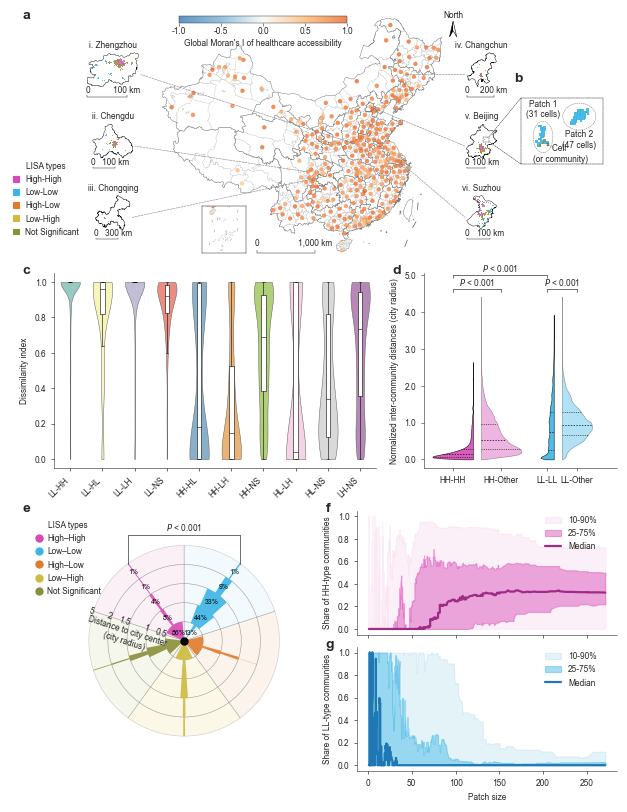

In [531]:
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.legend_handler import HandlerPatch
from matplotlib.patches import Rectangle
from matplotlib.patches import ConnectionPatch
from matplotlib.collections import PolyCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Wedge
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Ellipse

# ======================================================
# 全局字体（统一）
# ======================================================
mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial"],
    "font.size": 6,
    "axes.labelsize": 6,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "legend.fontsize": 6,
    "font.weight": "normal",
    "axes.labelweight": "normal",
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "axes.unicode_minus": False
})
    
# ======================================================
# 0️⃣ Figure & GridSpec
# ======================================================
MM_TO_INCH = 1 / 25.4
fig_w_in = 160 * MM_TO_INCH
fig_h_in = (fig_w_in)/7*9

fig = plt.figure(figsize=(fig_w_in, fig_h_in))

# ✅ 主结构：只分“上/下”两块，不再分左右列（彻底解耦）
gs_main = GridSpec(
    nrows=2,
    ncols=1,
    figure=fig,
    height_ratios=[1.9, 1.1],
    hspace=0.12
)

# ✅ 上半块：a 在第一行跨两列；第二行 c:d = 3:1
gs_top = gs_main[0, 0].subgridspec(
    2, 2,
    height_ratios=[1.1, 0.9],
    width_ratios=[5, 3],
    hspace=0.08,
    wspace=0.20
)

ax_map = fig.add_subplot(gs_top[0, :])   # a
ax_c   = fig.add_subplot(gs_top[1, 0])   # c（宽）
ax_d   = fig.add_subplot(gs_top[1, 1])   # d（窄）

# ✅ 下半块：e:f 宽度比保持不变（这里填你原来的比例）
gs_bottom = gs_main[1, 0].subgridspec(
    1, 2,
    width_ratios=[1, 1],
    wspace=0.18
)

ax_e = fig.add_subplot(gs_bottom[0, 0])

gs_f = gs_bottom[0, 1].subgridspec(2, 1, hspace=0.1)
ax_top = fig.add_subplot(gs_f[0, 0])
ax_bottom = fig.add_subplot(gs_f[1, 0], sharex=ax_top)


# ======================================================
# 1️⃣ 子图 a
# ======================================================
xmin, ymin, xmax, ymax = china.total_bounds

dx = xmax - xmin
dy = ymax - ymin

ax_map.set_xlim(
    xmin - 0.50 * dx,
    xmax + 0.50 * dx
)

ax_map.set_ylim(
    ymin + 0.26 * dy,
    ymax
)

ax_map.set_aspect('equal', adjustable='box')

# ===========================
# 1️⃣ Moran's I 合并
# ===========================
china["city_code"] = china["city_code"].astype(float).astype(int).astype(str)
df_global_Moran_I["city_code"] = df_global_Moran_I["city_code"].astype(float).astype(int).astype(str)

china["Moran_I"] = china["city_code"].map(
    df_global_Moran_I.set_index("city_code")["Moran_I"]
)

# ===========================
# 2️⃣ 城市中心点
# ===========================
china["rep_point"] = china.geometry.representative_point()
china_with_data = china[china["Moran_I"].notna()].copy()
china_with_data.set_geometry("rep_point", inplace=True)

# ===========================
# 3️⃣ colormap
# ===========================
blue_white_orange = LinearSegmentedColormap.from_list(
    "blue_white_orange",
    ["#2166ac", "#67a9cf", "#f7f7f7", "#fdae61", "#e6550d"]
)
norm = Normalize(vmin=-1, vmax=1)

# ===========================
# 4️⃣ 五类颜色
# ===========================
cluster_colors = {
    "High-High": "#D848B6",
    "Low-Low": "#3BB5E6",
    "High-Low": "#E07A2D",
    "Low-High": "#CDBA3F",
    "Not Significant": "#8A8F3A"
}

# ===========================
# 5️⃣ 画布
# ===========================
china.boundary.plot(ax=ax_map, color="#C0C0C0", linewidth=0.15, zorder=0)
china_provinces = china.dissolve(by="pro_code")
province_boundary = linemerge(unary_union(china_provinces.boundary))

gpd.GeoSeries(province_boundary, crs=china.crs).plot(
    ax=ax_map, color="#7F7F7F", linewidth=0.3, zorder=1
)

scatter = ax_map.scatter(
    china_with_data.geometry.x,
    china_with_data.geometry.y,
    s=10,
    c=china_with_data["Moran_I"],
    cmap=blue_white_orange,
    norm=norm,
    alpha=0.7,
    edgecolor="white",
    linewidth=0.01
)

# ===========================
# 6️⃣ Colorbar
# ===========================
cax = inset_axes(
    ax_map,
    width="30%",
    height="2.8%",
    loc="lower left",
    bbox_to_anchor=(0.28, 0.98, 1, 1),
    bbox_transform=ax_map.transAxes,
    borderpad=0
)

cbar = fig.colorbar(
    scatter,
    cax=cax,
    orientation="horizontal"
)

cbar.set_label(
    "Global Moran's I of healthcare accessibility",
    fontsize=6,
    labelpad=2
)

cbar.set_ticks([-1, -0.5, 0, 0.5, 1])
cbar.outline.set_linewidth(0.3)
cbar.ax.tick_params(labelsize=6, length=2.0, width=0.4, pad=1)
cbar.ax.minorticks_off()

# ⭐ 关键：只栅格化色条
cbar.solids.set_rasterized(True)
cbar.outline.set_rasterized(True)

# ===========================
# 7️⃣ 六个城市子图（原样保留）
# ===========================
city_order = [
    ("220100", "iv."),
    ("110000", "v."),
    ("320500", "vi."),
    ("410100", "i."),
    ("510100", "ii."),
    ("500000", "iii.")
]

city_name_map = {
    "110000": "Beijing",
    "320500": "Suzhou",
    "500000": "Chongqing",
    "220100": "Changchun",
    "510100": "Chengdu",
    "410100": "Zhengzhou"
}

# ===========================
# 6个城市子图
# ===========================
# —— 在 ax_map 的坐标系里定义布局（0~1）——

left_x   = 0.06      # 左列起点（相对 ax_map）
right_x  = 0.72      # 右列起点（相对 ax_map）
inset_w  = 0.45      # 小图宽（占 ax_map 宽度比例）
inset_h  = 0.45      # 小图高（占 ax_map 高度比例）

# 三行位置（从上到下），相对 ax_map
y_positions = [0.66, 0.36, 0.06]

right_cities = ["220100", "110000", "320500"]
left_cities  = ["410100", "510100", "500000"]

for city, label in city_order:

    # ===== 1) 计算在 ax_map 内的 (x0, y0) =====
    if city in right_cities:
        x0 = right_x
        y0 = y_positions[right_cities.index(city)]
    else:
        x0 = left_x
        y0 = y_positions[left_cities.index(city)]

    # ✅ 关键：用 inset_axes，把 inset 绑定在 ax_map 内
    ax_inset = inset_axes(
        ax_map,
        width=f"{inset_w*100:.0f}%",
        height=f"{inset_h*100:.0f}%",
        bbox_to_anchor=(x0, y0, inset_w, inset_h),
        bbox_transform=ax_map.transAxes,
        loc="lower left",
        borderpad=0
    )

    # ===== 2) 画城市内容 =====
    gdf_city = gdf_local_moran[gdf_local_moran["city_code"] == city]
    china_city = china[china["city_code"] == city]

    if not gdf_city.empty:
        gdf_city.plot(
            ax=ax_inset,
            color=gdf_city["cluster_type"].map(cluster_colors),
            edgecolor="none",
            alpha=0.8
        )

    china_city.boundary.plot(ax=ax_inset, edgecolor="black", linewidth=0.3)
    ax_inset.text(
        0.5, 1.02,
        f"{label} {city_name_map[city]}",
        transform=ax_inset.transAxes,
        ha="center",
        va="bottom",
        fontsize=6
    )

    ax_inset.set_axis_off()

    # ===== 3) 连线：城市点 → inset 中心（用 ax_map 的 transData + inset 的 transAxes）=====
    cen_geom = china_with_data.loc[
        china_with_data["city_code"] == city, "rep_point"
    ].values[0]

    # 判断小图在左列还是右列
    if city in right_cities:
        xyB = (0.0, 0.5)   # 指向小图左边缘
    else:
        xyB = (1.0, 0.5)   # 指向小图右边缘

    con = ConnectionPatch(
        xyA=(cen_geom.x, cen_geom.y),
        coordsA=ax_map.transData,
        xyB=xyB,
        coordsB=ax_inset.transAxes,
        linestyle="--",
        linewidth=0.4,
        color="gray",
        zorder=3,
        clip_on=False   # ⭐ 防止被 inset 裁掉
    )

    fig.add_artist(con)

    # ===== 4) 比例尺（原逻辑不变）=====
    def add_scalebar(ax, length_m,
                     pad_x=0.05, pad_y=-0.18,
                     height_frac=0.03,
                     lw=0.3, fontsize=6):

        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
        dx = xmax - xmin
        dy = ymax - ymin

        x0b = xmin + pad_x * dx
        y0b = ymin + pad_y * dy
        x1b = x0b + length_m
        h  = height_frac * dy

        ax.plot([x0b, x1b], [y0b, y0b], color="black", lw=lw, zorder=10)
        ax.plot([x0b, x0b], [y0b, y0b + h], color="black", lw=lw, zorder=10)
        ax.plot([x1b, x1b], [y0b, y0b + h], color="black", lw=lw, zorder=10)

        ax.text(x0b, y0b + h * 1.4, "0", ha="center", va="bottom",
                fontsize=fontsize, zorder=10)
        ax.text(x1b, y0b + h * 1.4, f"{int(length_m/1000)} km",
                ha="center", va="bottom", fontsize=fontsize, zorder=10)


    # 重庆 300 km，长春 200 km，其它城市 100 km
    if city == "500000":          # 重庆
        scale_len = 300_000
    elif city == "220100":        # 长春
        scale_len = 200_000
    else:
        scale_len = 100_000

    add_scalebar(ax_inset, length_m=scale_len, pad_x=0.05, pad_y=-0.22)


    # ===== 5) 北京放大图 b：保留你原来的 fig.add_axes 方案（不要改）=====
    if city == "110000":
    
        # 在北京 inset 中圈出放大区域
        # 1) 选一个放大范围
        xmin0, ymin0, xmax0, ymax0 = gdf_city.total_bounds
        
        zoom_extent = (
            xmin0 + 0.48 * (xmax0 - xmin0),
            ymin0 + 0.72 * (ymax0 - ymin0),
            xmin0 + 0.82 * (xmax0 - xmin0),
            ymin0 + 1.04 * (ymax0 - ymin0),
        )

        x0, y0, x1, y1 = zoom_extent

        rect = Rectangle(
            (x0, y0),               # 左下角
            x1 - x0,                # 宽
            y1 - y0,                # 高
            fill=False,             # 不填充
            edgecolor="black",      # 颜色
            linewidth=0.3,          # 线宽
            linestyle="--",         # 虚线
            zorder=5
        )

        ax_inset.add_patch(rect)
        
        # 2) 关键：用“北京 inset 的真实位置”（figure 坐标）
        bb = ax_inset.get_position()

        # 3) zoom inset 的位置：紧贴北京 inset 的右侧
        zoom_w = bb.width * 2.3
        zoom_h = bb.height * 2.3
    
        zoom_x0 = bb.x1 + 0.05
        zoom_y0 = bb.y1 + 0

        ax_zoom = fig.add_axes([zoom_x0, zoom_y0, zoom_w, zoom_h]) 

        # ===========================
        # ★ 子图标注 (b)
        # ===========================
        # 1) 先拿 zoom 图在 figure 里的真实位置
        bb = ax_zoom.get_position() 

        # 2) 用 fig.text 放 panel label
        fig.text(
            bb.x0 - 0.01,   # ← 左移一点
            bb.y1 + 0.00005,  # ← 上移一点
            "b",
            ha="left",
            va="bottom",
            fontsize=10,
            fontweight="bold"
        )

        # 4) 画放大图内容
        gdf_city.plot(
            ax=ax_zoom,
            color=gdf_city["cluster_type"].map(cluster_colors),
            edgecolor="none",
            alpha=0.9,
            zorder=2
        )
        china_city.boundary.plot(
            ax=ax_zoom,
            edgecolor="black",
            linewidth=0.3,
            zorder=3
        )

        ax_zoom.set_xlim(zoom_extent[0], zoom_extent[2])
        ax_zoom.set_ylim(zoom_extent[1], zoom_extent[3])
        ax_zoom.set_aspect("equal", adjustable="box")

        ax_zoom.set_xticks([])
        ax_zoom.set_yticks([])

        # 5) 给 zoom inset 边框
        for sp in ax_zoom.spines.values():
            sp.set_visible(True)
            sp.set_linewidth(0.3)
            sp.set_edgecolor("black")
            sp.set_linestyle("--")

        # 连接北京 inset 方框 → zoom inset

        # 北京 inset 中方框的右上 / 右下（数据坐标）
        bx1, by0, by1 = x1, y0, y1

        # zoom inset 的左边界（数据坐标）
        zx0, zx1 = ax_zoom.get_xlim()
        zy0, zy1 = ax_zoom.get_ylim()

        # ① 右上 → 左上
        con1 = ConnectionPatch(
            xyA=(x1, y1), coordsA=ax_inset.transData,   # 北京 inset
            xyB=(zx0, zy1), coordsB=ax_zoom.transData,  # zoom inset
            color="black",
            linewidth=0.3,
            linestyle="--",
            zorder=6
        )

        # ② 右下 → 左下
        con2 = ConnectionPatch(
            xyA=(x1, y0), coordsA=ax_inset.transData,
            xyB=(zx0, zy0), coordsB=ax_zoom.transData,
            color="black",
            linewidth=0.3,
            linestyle="--",
            zorder=6
        )

        fig.add_artist(con1)
        fig.add_artist(con2)

        # ===========================
        # ⭐ 圈出 patch
        # ===========================
        # ⭐ Patch 圈参数
        x_p1 = zoom_extent[0] + 0.27 * (zoom_extent[2] - zoom_extent[0])
        y_p1 = zoom_extent[1] + 0.41 * (zoom_extent[3] - zoom_extent[1])

        w_p1 = 0.24 * (zoom_extent[2] - zoom_extent[0])
        h_p1 = 0.48 * (zoom_extent[3] - zoom_extent[1])

        x_p2 = zoom_extent[0] + 0.71 * (zoom_extent[2] - zoom_extent[0])
        y_p2 = zoom_extent[1] + 0.72 * (zoom_extent[3] - zoom_extent[1])

        w_p2 = 0.40 * (zoom_extent[2] - zoom_extent[0])
        h_p2 = 0.41 * (zoom_extent[3] - zoom_extent[1])

        # Patch 1
        ellipse_p1 = Ellipse(
            xy=(x_p1, y_p1),      # 圆心
            width=w_p1,           # 横向直径
            height=h_p1,          # 纵向直径
            angle=0,              # 旋转角
            fill=False,
            edgecolor="0.3",
            linewidth=0.3,
            linestyle="--",
            alpha=0.9,
            zorder=20
        )

        # Patch 2
        ellipse_p2 = Ellipse(
            xy=(x_p2, y_p2),
            width=w_p2,
            height=h_p2,
            angle=0,
            fill=False,
            edgecolor="0.3",
            linewidth=0.3,
            linestyle="--",
            alpha=0.9,
            zorder=20
        )

        ax_zoom.add_patch(ellipse_p1)
        ax_zoom.add_patch(ellipse_p2)
    
        # ===========================
        # ⭐ 社区方框（手动调）
        # ===========================
        x_c = zoom_extent[0] + 0.3322 * (zoom_extent[2] - zoom_extent[0])
        y_c = zoom_extent[1] + 0.2952 * (zoom_extent[3] - zoom_extent[1])

        w_c = 0.0251 * (zoom_extent[2] - zoom_extent[0])
        h_c = 0.036 * (zoom_extent[3] - zoom_extent[1])

        community_box = Rectangle(
            (x_c - w_c/2, y_c - h_c/2),  # 左下角
            w_c,
            h_c,
            fill=False,
            edgecolor="0.2",
            linewidth=0.2,
            linestyle="-",   # 社区用实线（和 patch 区分）
            zorder=30
        )

        ax_zoom.add_patch(community_box)

        ax_zoom.text(
            x_c + 5*h_c,
            y_c - 8*h_c,
            "Cell \n(or community)",
            ha="center",
            va="bottom",
            fontsize=6,
            zorder=31
        )

        # ===========================
        # ⭐ 引线（grid ↔ 方格）
        # ===========================
        conn = ConnectionPatch(
            xyA=(x_c + w_c/2, y_c - h_c/2),   # 方框右下角
            xyB=(x_c + 2.5*h_c, y_c - 1.2*h_c),   # 文字锚点
            coordsA="data",
            coordsB="data",
            axesA=ax_zoom,
            axesB=ax_zoom,
            color="0.2",
            linewidth=0.15,
            zorder=29
        )

        ax_zoom.add_artist(conn)

        # ===========================
        # ⭐ Patch 标注
        # ===========================
        ax_zoom.text(
            x_p1,
            y_p1 + 0.27 * (ax_zoom.get_ylim()[1] - ax_zoom.get_ylim()[0]),
            "Patch 1\n(31 cells)",
            ha="center",     # 水平居中
            va="bottom",     # 文本底部对齐到参考点 → 显示在正上方
            fontsize=6,
            zorder=21
        )

        ax_zoom.text(
            x_p2,
            y_p2 - 0.205 * (ax_zoom.get_ylim()[1] - ax_zoom.get_ylim()[0]),
            "Patch 2\n(47 cells)",
            ha="center",
            va="top",
            fontsize=6,
            zorder=21
        )

# ===========================
# 8️⃣ 南海 inset
# ===========================
nine = china.loc[china["city_code"] == "100000"]
hainan = china.loc[china["省"] == "海南省"]
south_geom = unary_union(list(nine.geometry) + list(hainan.geometry))
minx_s, miny_s, maxx_s, maxy_s = south_geom.bounds

axins = inset_axes(
    ax_map, width="12%", height="20%",
    loc="lower left",
    bbox_to_anchor=(0.30, 0.01, 1, 1),
    bbox_transform=ax_map.transAxes,
    borderpad=0
)

axins.set_xlim(minx_s + 0.21*(maxx_s-minx_s),
               maxx_s - 0.26*(maxx_s-minx_s))
axins.set_ylim(miny_s + 0.28*(maxy_s-miny_s),
               maxy_s - 0.38*(maxy_s-miny_s))

# ⭐ 等比例缩放因子
scale = 0.4
cx0, cy0 = (minx_s+maxx_s)/2, (miny_s+maxy_s)/2
shrink = Affine2D().translate(-cx0, -cy0).scale(scale).translate(cx0, cy0)

# —— 市界（线宽 × scale）——
china.boundary.plot(
    ax=axins, color="#C0C0C0",
    linewidth=0.15*scale,
    transform=shrink + axins.transData,
    zorder=1
)
# —— 省界（线宽 × scale）——
gpd.GeoSeries(province_boundary, crs=china.crs).plot(
    ax=axins, color="#7F7F7F",
    linewidth=0.3*scale,
    transform=shrink + axins.transData,
    zorder=2
)
# —— 圆圈（面积 × scale²，边线 × scale）——
axins.scatter(
    china_with_data.geometry.x,
    china_with_data.geometry.y,
    s=12*scale**2,
    c=china_with_data["Moran_I"],
    cmap=blue_white_orange,
    norm=norm,
    alpha=0.7,
    edgecolor="white",
    linewidth=0.01*scale,
    transform=shrink + axins.transData,
    zorder=3
)

for spine in axins.spines.values():
    spine.set_linewidth(0.3)
    spine.set_color("black")

axins.set_xticks([])
axins.set_yticks([])

# ===========================
# 9️⃣ 比例尺
# ===========================
scale_length_m = 1_000_000  # 1000 km
xmin, xmax = ax_map.get_xlim()
x0 = xmin + 0.42*(xmax-xmin)
x1 = x0 + scale_length_m

y_ax = 0.01
h_ax = 0.015

ax_map.plot([x0, x1], [y_ax, y_ax],
            transform=ax_map.get_xaxis_transform(),
            lw=0.3, color="black", clip_on=False)
ax_map.plot([x0, x0], [y_ax, y_ax+h_ax],
            transform=ax_map.get_xaxis_transform(),
            lw=0.3, color="black", clip_on=False)
ax_map.plot([x1, x1], [y_ax, y_ax+h_ax],
            transform=ax_map.get_xaxis_transform(),
            lw=0.3, color="black", clip_on=False)

ax_map.text(x0, y_ax+h_ax+0.01, "0",
            transform=ax_map.get_xaxis_transform(),
            ha="center",  va="bottom", fontsize=6, clip_on=False)
ax_map.text(x1, y_ax+h_ax+0.01, "1,000 km",
            transform=ax_map.get_xaxis_transform(),
            ha="center", va="bottom", fontsize=6, clip_on=False)

# ===========================
# 🔟 指北针（ESRI）
# ===========================
# 选一个地图右上角的 data 坐标位置 
nx = xmin + 0.77 * (xmax - xmin) 
ny = ymin + 0.96 * (ymax - ymin) 

H = 0.03 * (ymax - ymin)  
L = 0.75 * H

theta = np.deg2rad(150) 

bottom = (nx, ny) 
top = (nx, ny + H) 

dx = L * np.sin(theta) 
dy = -L * np.cos(theta) 

left_tip = (nx - dx, ny - dy) 
right_tip = (nx + dx, ny - dy) 

ax_map.add_patch(Polygon([bottom, top, left_tip], facecolor="black", edgecolor="none", zorder=10)) 
ax_map.add_patch(Polygon([bottom, right_tip, top], facecolor="white", edgecolor="none", zorder=10)) 
ax_map.add_patch(Polygon([top, left_tip, bottom, right_tip], facecolor="none", edgecolor="black", linewidth=0.4, zorder=10)) 

ax_map.text(nx, ny + H * 1.15, "North", ha="center", va="bottom", fontsize=6, zorder=10)

# ===========================
# 11️⃣ 图例
# ===========================
class SquareHandler(HandlerPatch):
    def create_artists(
        self, legend, orig_handle,
        xdescent, ydescent, width, height, fontsize, trans
    ):
        size = min(width, height)  # ⭐ 强制正方形
        patch = mpatches.Rectangle(
            (xdescent, ydescent),
            size, size,
            facecolor=orig_handle.get_facecolor(),
            edgecolor=orig_handle.get_edgecolor()
        )
        patch.set_transform(trans)
        return [patch]

cluster_patches = [
    mpatches.Patch(color=v, label=k)
    for k, v in cluster_colors.items()
]

ax_map.legend(
    handles=cluster_patches,
    loc="lower left",
    bbox_to_anchor=(-0.03, 0.05),
    frameon=False,
    fontsize=6,
    title="LISA types",
    title_fontsize=6,
    handler_map={h: SquareHandler() for h in cluster_patches},
    handlelength=0.8,
    handletextpad=0.6
)

ax_map.set_axis_off()

# ======================================================
# 子图 c
# ======================================================
ax = ax_c 

# ====================
# 1. 取 df_city_D 的后 10 列
# ====================
d_cols = [
    'D_High-High_Low-Low',
    'D_Low-Low_High-Low',
    'D_Low-Low_Low-High',
    'D_Low-Low_Not_Significant',
    'D_High-High_High-Low',
    'D_High-High_Low-High',
    'D_High-High_Not_Significant',
    'D_High-Low_Low-High',
    'D_High-Low_Not_Significant',
    'D_Low-High_Not_Significant'
]

# 映射成更短标签
label_map = {
    'D_High-High_Low-Low': 'LL-HH',
    'D_Low-Low_High-Low': 'LL-HL',
    'D_Low-Low_Low-High': 'LL-LH',
    'D_Low-Low_Not_Significant': 'LL-NS',
    'D_High-High_High-Low': 'HH-HL',
    'D_High-High_Low-High': 'HH-LH',
    'D_High-High_Not_Significant': 'HH-NS',
    'D_High-Low_Low-High': 'HL-LH',
    'D_High-Low_Not_Significant': 'HL-NS',
    'D_Low-High_Not_Significant': 'LH-NS'
}

# ====================
# 转成长格式
# ====================
df_plot = df_city_D.melt(
    id_vars=["city_code"],
    value_vars=d_cols,
    var_name="D_pair",
    value_name="D_value"
)

# 应用短标签
df_plot["D_pair_short"] = df_plot["D_pair"].map(label_map)

# ====================
# 2. 绘图
# ====================
# 小提琴图
sns.violinplot(
    data=df_plot,
    x="D_pair_short",
    y="D_value",
    ax=ax,
    inner=None,
    hue="D_pair_short",
    palette="Set3",
    cut=0,
    width=0.6,
    linewidth=0.35,
    legend=False
)

# 叠加箱线图
box_lw = 0.4

sns.boxplot(
    data=df_plot,
    x="D_pair_short",
    y="D_value",
    ax=ax,
    width=0.14,
    showcaps=True,
    boxprops={
        'facecolor': 'white',
        'edgecolor': 'black',
        'linewidth': box_lw
    },
    whiskerprops={
        'color': 'black',
        'linewidth': box_lw
    },
    capprops={
        'color': 'black',
        'linewidth': box_lw
    },
    medianprops={
        'color': 'black',
        'linewidth': box_lw
    },
    showfliers=False
)

ax.set_xlabel("")
ax.set_ylabel("Dissimilarity index", fontsize=6)
ax.tick_params(axis="x", labelrotation=45)
for label in ax.get_xticklabels():
    label.set_ha("right")

# ===== y 轴刻度线 =====
ax.tick_params(
    axis="y",
    which="major",
    left=True,
    direction="out",
    length=2,      # 刻度线长度
    width=0.4,     # 刻度线粗细
    color="black"
)

# ===== x 轴刻度线 =====
ax.tick_params(
    axis="x",
    which="major",
    bottom=True,
    direction="out",
    length=2,
    width=0.4,
    color="black"
)

ax.margins(y=0.05)
sns.despine(ax=ax, top=True, right=True)
ax.spines["left"].set_linewidth(0.4)
ax.spines["bottom"].set_linewidth(0.4)

# ======================================================
# 子图 d
# ======================================================
ax = ax_d

# =====================================================
# ① 重塑数据为长格式
# =====================================================
df_long = pd.DataFrame()
types = ["High-High", "Low-Low"]

for t in types:
    if t == "High-High":
        same_values = df_HH_pair_dist["norm_distance"]
        other_values = df_HH_other_dist["norm_distance"]
    else:
        same_values = df_LL_pair_dist["norm_distance"]
        other_values = df_LL_other_dist["norm_distance"]

    df_long = pd.concat(
        [
            df_long,
            pd.DataFrame({
                "Cluster Type": t,
                "Group": "Same-type",
                "Value": same_values
            }),
            pd.DataFrame({
                "Cluster Type": t,
                "Group": "Different-type",
                "Value": other_values
            })
        ],
        ignore_index=True
    )

df_long["Value"] = df_long["Value"].replace([np.inf, -np.inf], np.nan)
df_long = df_long.dropna()

# =====================================================
# ② p 值
# =====================================================
p_values = {
    "High-High": 0.0000,
    "Low-Low":  0.0000
}

# =====================================================
# ③ 绘图
# =====================================================
sns.set_theme(style="white", context="paper")

hue_order = ["Same-type", "Different-type"]

ax = sns.violinplot(
    data=df_long,
    x="Cluster Type",
    y="Value",
    hue="Group",
    order=types,
    hue_order=hue_order,
    split=True,
    inner=None,   # ⭐ 内部线自己画（保证跟着平移）
    linewidth=0.5,
    cut=0,
    ax=ax,
    zorder=2
)

# ------------------------------------------------------
# ④ 平移左右半小提琴
# ------------------------------------------------------
gap = 0.08
shift = gap / 2

# ⭐ 关键：自定义两个类别的中心位置
custom_pos = {
    "High-High": 0,
    "Low-Low": 0.8
}

polys = [c for c in ax.collections if isinstance(c, PolyCollection)]

half_vertices = {}
n_cat = len(types)
n_hue = len(hue_order)

for k, poly in enumerate(polys[:n_cat * n_hue]):
    cat_i = k // n_hue
    hue_i = k % n_hue

    cat_name = types[cat_i]

    # seaborn 默认中心是 cat_i (0 或 1)
    default_center = cat_i
    new_center = custom_pos[cat_name]

    base_shift = new_center - default_center

    side = "L" if hue_i == 0 else "R"
    dx_half = -shift if side == "L" else shift

    dx = base_shift + dx_half

    for pth in poly.get_paths():
        v = pth.vertices
        v[:, 0] += dx
        half_vertices[(cat_i, side)] = v.copy()



# =====================================================
# 修改每个半小提琴的颜色和透明度
# =====================================================
colors = [
    "#D848B6",  # HH Same-type
    "#D848B6",  # HH Different-type
    "#3BB5E6",  # LL Same-type
    "#3BB5E6"   # LL Different-type
]

alphas = [
    0.9,  # HH Same-type
    0.4,  # HH Different-type
    0.9,  # LL Same-type
    0.4   # LL Different-type
]

for i, poly in enumerate(polys[:len(colors)]):
    poly.set_facecolor(colors[i])
    poly.set_alpha(alphas[i])
    poly.set_edgecolor("black")
    poly.set_linewidth(0.4)


# ------------------------------------------------------
# 工具函数：在给定 y 处求 half-violin 左右边界
# ------------------------------------------------------
def x_bounds_at_y_interp(vertices, y0):
    x = vertices[:, 0]
    y = vertices[:, 1]

    yr = np.nanmax(y) - np.nanmin(y)
    if yr == 0:
        return None, None

    bin_w = yr * 0.002
    bins = np.floor((y - np.nanmin(y)) / bin_w).astype(int)

    y_bin = {}
    for xi, yi, bi in zip(x, y, bins):
        if bi not in y_bin:
            y_bin[bi] = {"y": yi, "xmin": xi, "xmax": xi}
        else:
            y_bin[bi]["xmin"] = min(y_bin[bi]["xmin"], xi)
            y_bin[bi]["xmax"] = max(y_bin[bi]["xmax"], xi)

    ys2 = np.array([d["y"] for d in y_bin.values()])
    xmin2 = np.array([d["xmin"] for d in y_bin.values()])
    xmax2 = np.array([d["xmax"] for d in y_bin.values()])

    idx = np.argsort(ys2)
    ys2, xmin2, xmax2 = ys2[idx], xmin2[idx], xmax2[idx]

    if y0 < ys2.min() or y0 > ys2.max():
        return None, None

    xmin0 = np.interp(y0, ys2, xmin2)
    xmax0 = np.interp(y0, ys2, xmax2)
    return xmin0, xmax0

# ------------------------------------------------------
# ⑤ quartile 线（贴合 half-violin 边界）
# ------------------------------------------------------
for i, t in enumerate(types):

    vals_L = df_long[
        (df_long["Cluster Type"] == t) &
        (df_long["Group"] == "Same-type")
    ]["Value"].values

    vals_R = df_long[
        (df_long["Cluster Type"] == t) &
        (df_long["Group"] == "Different-type")
    ]["Value"].values

    qL = np.percentile(vals_L, [25, 50, 75])
    qR = np.percentile(vals_R, [25, 50, 75])

    # -------- Left half (Same-type) --------
    vL = half_vertices.get((i, "L"))
    if vL is not None:
        for q in qL:
            xmin, xmax = x_bounds_at_y_interp(vL, q)
            if xmin is None:
                continue

            is_median = np.isclose(q, qL[1])  # ⭐ 50% 分位数

            ax.hlines(
                q,
                xmin,
                xmax,
                colors="black",
                linewidth=0.5 if is_median else 0.4,   # ⭐ 中位数加粗
                linestyles=(0, (2, 2)),
                zorder=4
            )

    # -------- Right half (Different-type) --------
    vR = half_vertices.get((i, "R"))
    if vR is not None:
        for q in qR:
            xmin, xmax = x_bounds_at_y_interp(vR, q)
            if xmin is None:
                continue

            is_median = np.isclose(q, qR[1])  # ⭐ 50% 分位数

            ax.hlines(
                q,
                xmin,
                xmax,
                colors="black",
                linewidth=0.5 if is_median else 0.4,   # ⭐ 中位数加粗
                linestyles=(0, (2, 2)),
                zorder=4
            )

# =====================================================
# ⑦ p 值标注（组内）
# =====================================================
y_max = df_long["Value"].max()
y_min = df_long["Value"].min()

step = (y_max - y_min) * 0.12
v = step * 0.15

# ⭐ 两条 p 值之间的间隔（调这个）
p_gap = 0.70 * step        # 想更远就调大，比如 0.90*step；想更近就调小，比如 0.50*step

# ⭐ 两层 p 值的 y 位置
y_group = y_max + 0.40 * step      # 组内 p 值高度（一般不动）
y_between = y_group + p_gap         # 组间 p 值高度（由 p_gap 决定）


def half_center_x(vertices):
    xs = vertices[:, 0]
    return (np.nanmin(xs) + np.nanmax(xs)) / 2

xticks4 = [
    half_center_x(half_vertices[(0, "L")]),  # HH-HH
    half_center_x(half_vertices[(0, "R")]),  # HH-Other
    half_center_x(half_vertices[(1, "L")]),  # LL-LL
    half_center_x(half_vertices[(1, "R")]),  # LL-Other
]
xlabels = ["HH-HH", "HH-Other", "LL-LL", "LL-Other"]

ax.set_xticks(xticks4)

# HH 组内：HH-HH vs HH-Other
x1_hh, x2_hh = xticks4[0], xticks4[1]

# LL 组内：LL-LL vs LL-Other
x1_ll, x2_ll = xticks4[2], xticks4[3]

for (x1, x2, t) in [(x1_hh, x2_hh, "High-High"), (x1_ll, x2_ll, "Low-Low")]:

    p = p_values[t]
    p_text = r"$\it{P}$ < 0.001" if p < 0.001 else rf"$\it{{P}}$ = {p:.3f}"
    y = y_group


    ax.plot([x1, x2], [y, y], color="black", lw=0.4)
    ax.plot([x1, x1], [y - v, y], color="black", lw=0.4)
    ax.plot([x2, x2], [y - v, y], color="black", lw=0.4)

    ax.text((x1 + x2) / 2, y + step * 0.05, p_text,
            ha="center", va="bottom", fontsize=6)

# 给顶部留够空间（否则组间那条可能贴边）
ax.set_ylim(top=y_max + step * 1.2)


# =====================================================
# ★ 左半（Same-type）之间的 p 值 —— 与轴标签严格对齐
# =====================================================
x_start = xticks4[0]  # HH-HH 标签中心
x_end   = xticks4[2]  # LL-LL 标签中心

y_left = y_between
v_left = step * 0.15

ax.plot([x_start, x_end], [y_left, y_left], color="black", lw=0.4)
ax.plot([x_start, x_start], [y_left - v_left, y_left], color="black", lw=0.4)
ax.plot([x_end, x_end], [y_left - v_left, y_left], color="black", lw=0.4)

ax.text((x_start + x_end) / 2, y_left + step * 0.05,
        r"$\it{P}$ < 0.001", ha="center", va="bottom", fontsize=6)


# =====================================================
# ⑧ x 轴：让标签落在“半小提琴最宽处”的中心（视觉中心）
# =====================================================
def widest_center_x(vertices):
    x = vertices[:, 0]
    y = vertices[:, 1]

    yr = np.nanmax(y) - np.nanmin(y)
    if yr == 0:
        return np.nan

    # y 分箱（跟你 x_bounds 的逻辑一致，稍微粗一点更稳）
    bin_w = yr * 0.01
    bins = np.floor((y - np.nanmin(y)) / bin_w).astype(int)

    # 每个 y-bin 记录 xmin/xmax，找“宽度最大”的那一层
    y_bin = {}
    for xi, yi, bi in zip(x, y, bins):
        if bi not in y_bin:
            y_bin[bi] = {"y": yi, "xmin": xi, "xmax": xi}
        else:
            y_bin[bi]["xmin"] = min(y_bin[bi]["xmin"], xi)
            y_bin[bi]["xmax"] = max(y_bin[bi]["xmax"], xi)

    widths = np.array([d["xmax"] - d["xmin"] for d in y_bin.values()])
    centers = np.array([(d["xmax"] + d["xmin"]) / 2 for d in y_bin.values()])

    # 取最宽那一层的中心
    return centers[np.argmax(widths)]



ax.set_xticklabels(xlabels, fontsize=6)

ax.set_xlabel("")
ax.set_ylabel("Normalized inter-community distances (city radius)", fontsize=6)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# 保留刻度线样式
ax.tick_params(
    axis="y",
    which="major",
    left=True,
    direction="out",
    length=2,
    width=0.4,
    labelsize=6
)

ax.tick_params(
    axis="x",
    which="major",
    bottom=True,
    direction="out",
    length=2,
    width=0.4,
    labelsize=6
)

sns.despine(ax=ax, top=True, right=True)
ax.spines["left"].set_linewidth(0.4)
ax.spines["bottom"].set_linewidth(0.4)

# ✅ 取消 legend（不显示图例）
leg = ax.get_legend()
if leg is not None:
    leg.remove()


# ======================================================
# 子图 e
# ======================================================
ax = ax_e
ax.axis("off")
ax.set_aspect("equal", adjustable="box", anchor="W")  # ✅ 左侧锚定，防止自动居中把 x0 推右

# ======================================================
# 1️⃣ 输入数据
# ======================================================
dist_dfs = {
    "HH": df_HH_dist,
    "LL": df_LL_dist,
    "HL": df_HL_dist,
    "LH": df_LH_dist,
    "NS": df_NS_dist,
}

# 类型顺序
types = ["LL", "HL", "LH", "NS", "HH"]

# 深色：表示占比
colors = {
    "HH": "#D848B6",
    "LL": "#3BB5E6",
    "HL": "#E07A2D",
    "LH": "#CDBA3F",
    "NS": "#8A8F3A"
}

# 浅色：作为类型底色（72° 扇区，始终画满）
colors_base = {
    "HH": "#F1B6DA",
    "LL": "#BFE7F5",
    "HL": "#F3C4A3",
    "LH": "#EFE08F",
    "NS": "#D3D8A3"
}

# ======================================================
# 2️⃣ 自定义距离区间（左闭右开）
# ======================================================
bins = [
    (0.0, 0.5),
    (0.5, 1.0),
    (1.0, 1.5),
    (1.5, 2.0),
    (2.0, 5.0),
]

bin_labels = ["0–0.5", "0.5–1.0", "1.0–1.5", "1.5–2.0", "2.0–5.0"]

# ======================================================
# 3️⃣ 计算：每种类型在各区间的占比（类型内部归一化）
# ======================================================
props = {}

for t, dfs in dist_dfs.items():
    d = dfs["norm_distance"].dropna().values
    counts = []

    for low, high in bins:
        counts.append(((d >= low) & (d < high)).sum())

    counts = np.array(counts)
    total = counts.sum()

    if total == 0:
        props[t] = np.zeros(len(bins))
    else:
        props[t] = counts / total

# ======================================================
# 4️⃣ 画布
# ======================================================
# 市中心
ax.plot(
    0, 0,
    marker="o",
    color="black",
    markersize=5,
    zorder=10
)

# ======================================================
# 5️⃣ 绘图参数
# ======================================================
radius_scale = 0.88
ring_width = 1.0 * radius_scale

sector_angle = 360 / len(types)  # 72°
start_angle = 90                 # 从正上方开始
# ======================================================
# 6️⃣ 同心环 + 类型底色 + 对称占比填充
# ======================================================
for i, label in enumerate(bin_labels):
    r_outer = (i + 1) * radius_scale

    for j, t in enumerate(types):
        # ⭐ 顺时针：角度递减
        theta_sector_start = start_angle - j * sector_angle
        theta_sector_end   = theta_sector_start - sector_angle
        theta_sector_center = (theta_sector_start + theta_sector_end) / 2

        # ---- 6.1 类型底色（72°，始终画满）----
        base_wedge = Wedge(
            center=(0, 0),
            r=r_outer,
            theta1=theta_sector_end,
            theta2=theta_sector_start,
            width=ring_width,
            facecolor=colors_base[t],      # ⭐ 直接白色
            edgecolor="black",      # 保留结构线
            alpha=0.2,
            linewidth=0.4,
            zorder=1
        )
        ax.add_patch(base_wedge)

        # ---- 6.2 占比 → 在扇区中间对称填充 ----
        frac = props[t][i]
        fill_angle = np.clip(frac, 0, 1) * sector_angle

        if fill_angle > 0:
            theta_fill_start = theta_sector_center - fill_angle / 2
            theta_fill_end   = theta_sector_center + fill_angle / 2

            t1, t2 = sorted([theta_fill_start, theta_fill_end])

            wedge = Wedge(
                center=(0, 0),
                r=r_outer,
                theta1=t1,
                theta2=t2,
                width=ring_width,
                facecolor=colors[t],
                edgecolor="None",
                alpha=0.9,
                zorder=2
            )
            ax.add_patch(wedge)

            # ==================================================
            # ⭐ 百分比标注（关键新增部分）
            # ==================================================
            if t in ["HH", "LL"]:
                r_mid = r_outer - ring_width / 2

                x_pct = r_mid * np.cos(np.deg2rad(theta_sector_center))
                y_pct = r_mid * np.sin(np.deg2rad(theta_sector_center))

                ax.text(
                    x_pct,
                    y_pct,
                    f"{frac*100:.0f}%",
                    ha="center",
                    va="center",
                    fontsize=5,
                    color="black",
                    zorder=5
                )

# ======================================================
# ⭐ 6.3 HH vs LL 显著性标注
# ======================================================
r_max = len(bins) * radius_scale   # 最外圈外半径（你每环 r_outer=i+1，所以最外圈=bin数）
v_len = 1.5 * radius_scale    # 竖线长度
pad_y = 0.12 * radius_scale   # 文字离水平线高度
lw_sig = 0.4             # 线宽

# 1) 找到 HH / LL 在 types 里的位置（你 types = ["LL","HL","LH","NS","HH"]）
j_ll = types.index("LL")
j_hh = types.index("HH")

# 2) 计算两个扇区的“中心角”（度 -> 弧度）
theta_ll = np.deg2rad(
    start_angle - j_ll * sector_angle - sector_angle / 2
)
theta_hh = np.deg2rad(
    start_angle - j_hh * sector_angle - sector_angle / 2
)

# 3) 最外沿中心点坐标（LL / HH）
x_ll, y_ll = r_max * np.cos(theta_ll), r_max * np.sin(theta_ll)
x_hh, y_hh = r_max * np.cos(theta_hh), r_max * np.sin(theta_hh)

# 4) 各自竖直向上画线（保持 x 不变，y 增加）
x_ll_top, y_ll_top = x_ll, y_ll + v_len
x_hh_top, y_hh_top = x_hh, y_hh + v_len

ax.plot([x_ll, x_ll_top], [y_ll, y_ll_top], color="black", lw=lw_sig, zorder=10)
ax.plot([x_hh, x_hh_top], [y_hh, y_hh_top], color="black", lw=lw_sig, zorder=10)

# 5) 顶端水平线：连接两条竖线的顶端
# 为了保证水平线水平，我们取一个共同高度 y_top
y_top = max(y_ll_top, y_hh_top)
ax.plot([x_ll_top, x_ll_top], [y_ll_top, y_top], color="black", lw=lw_sig, zorder=10)  # 如果两端不齐，补齐
ax.plot([x_hh_top, x_hh_top], [y_hh_top, y_top], color="black", lw=lw_sig, zorder=10)

ax.plot([x_ll_top, x_hh_top], [y_top, y_top], color="black", lw=lw_sig, zorder=10)

# 6) P 值文字：放在水平线中点上方
ax.text(
    (x_ll_top + x_hh_top) / 2,
    y_top + pad_y,
    r"$\it{P}$ < 0.001",
    ha="center",
    va="bottom",
    fontsize=6,
    zorder=11
)

# ======================================================
# 7️⃣ 距离区间标注
# ======================================================
# HH–NS 相邻扇区的分界角（弧度）
j_hh = types.index("HH")
theta_sep = np.deg2rad(start_angle - j_hh * sector_angle)
theta_deg = np.rad2deg(theta_sep)

rotation_along = theta_deg
if 90 < (theta_deg % 360) < 270:
    rotation_along = theta_deg + 180

# 在这条径向线上标注各距离区间的右端点
for i, (_, right) in enumerate(bins, start=1):
    label = f"{right:g}" if np.isfinite(right) else "≥5"

    # 标注位置
    r_text = i * radius_scale

    x_txt = r_text * np.cos(theta_sep)
    y_txt = r_text * np.sin(theta_sep)

    ax.text(
        x_txt, y_txt,
        label,
        rotation=rotation_along,      # ⭐ 顺着 HH–NS 边界线
        rotation_mode="anchor",
        ha="right",                   # ⭐ 文字朝向圆心
        va="center",
        fontsize=6,
        zorder=12
    )

# ======================================================
# ⭐ 距离轴标题
# ======================================================
j_hh = types.index("HH")
theta_sep = np.deg2rad(start_angle - j_hh * sector_angle)  # HH 与 NS 的分界线
theta_deg = np.rad2deg(theta_sep)

# 分界线方向（径向）
ux = np.cos(theta_sep)
uy = np.sin(theta_sep)

# ⬇ 法向方向（顺时针 90°，让文字往“右下 / 圆内”）
nx = np.cos(theta_sep - np.pi/2)
ny = np.sin(theta_sep - np.pi/2)

# 半径位置
r_title = 3.0 * radius_scale

# 法向偏移量（⭐ 控制“离线多远”）
offset_normal = -0.7 * radius_scale

x_lab = r_title * ux + offset_normal * nx
y_lab = r_title * uy + offset_normal * ny

theta_deg = np.rad2deg(theta_sep)
rotation_along = theta_deg

# 保证正着读
if 90 < (theta_deg % 360) < 270:
    rotation_along += 180

ax.text(
    x_lab, y_lab,
    "Distance to city center\n(city radius)",
    rotation=rotation_along,
    rotation_mode="anchor",
    ha="center",      # 从外向内读
    va="center",
    fontsize=6,
    zorder=20
)

# ======================================================
# 固定坐标轴显示范围（让缩放在视觉上可见）
# ======================================================
R_show = len(bins) + 1   # 用原始尺度作为参考

ax.set_xlim(-R_show, R_show)
ax.set_ylim(-R_show, R_show)

# ======================================================
# 8️⃣ 图例
# ======================================================
legend_order = [
    ("HH", "High–High"),
    ("LL", "Low–Low"),
    ("HL", "High–Low"),
    ("LH", "Low–High"),
    ("NS", "Not Significant"),
]

legend_handles = [
    Line2D(
        [0], [0],
        marker='o',
        linestyle='None',
        markersize=6,
        markerfacecolor=colors[k],
        markeredgecolor='none',
        label=lab
    )
    for k, lab in legend_order
]

ax.legend(
    handles=legend_handles,
    loc="upper left",
    bbox_to_anchor=(-0.1, 0.99),
    frameon=False,
    fontsize=6,
    title="LISA types",
    title_fontsize=6,
    handlelength=0.8, 
    handletextpad=0.6
    
)

# ======================================================
# 子图 f
# ======================================================

# =========================
# 1️⃣ 数据准备
# =========================
df_LL = patch_summary[["patch_size", "Low-Low_perc"]].dropna().copy()
df_LL = df_LL.sort_values("patch_size").reset_index(drop=True)

df_HH = patch_summary[["patch_size", "High-High_perc"]].dropna().copy()
df_HH = df_HH.sort_values("patch_size").reset_index(drop=True)

# =========================
# 2️⃣ 滑动窗口分位数
# =========================
window = 100

def rolling_quantiles(df, col, window):
    out = df.copy()
    out["q10"] = out[col].rolling(window, center=True).quantile(0.10)
    out["q25"] = out[col].rolling(window, center=True).quantile(0.25)
    out["q50"] = out[col].rolling(window, center=True).quantile(0.50)
    out["q75"] = out[col].rolling(window, center=True).quantile(0.75)
    out["q90"] = out[col].rolling(window, center=True).quantile(0.90)
    return out

df_LL = rolling_quantiles(df_LL, "Low-Low_perc", window)
df_HH = rolling_quantiles(df_HH, "High-High_perc", window)

# =========================
# 3️⃣ 上：High–High
# =========================
ax_top.fill_between(
    df_HH["patch_size"], df_HH["q10"], df_HH["q90"],
    color="#F0B7DC", alpha=0.20, label="10-90%"
)
ax_top.fill_between(
    df_HH["patch_size"], df_HH["q25"], df_HH["q75"],
    color="#D848B6", alpha=0.45, label="25-75%"
)
ax_top.plot(
    df_HH["patch_size"], df_HH["q50"],
    color="#9E2C84", lw=1.6, label="Median"
)

ax_top.set_ylabel("Share of HH-type communities", fontsize=6)
ax_top.set_xlabel("")
ax_top.tick_params(axis="x", labelbottom=False)

# =========================
# 4️⃣ 下：Low–Low
# =========================
ax_bottom.fill_between(
    df_LL["patch_size"], df_LL["q10"], df_LL["q90"],
    color="#7AC3DF", alpha=0.20, label="10-90%"
)
ax_bottom.fill_between(
    df_LL["patch_size"], df_LL["q25"], df_LL["q75"],
    color="#3BB5E6", alpha=0.45, label="25-75%"
)
ax_bottom.plot(
    df_LL["patch_size"], df_LL["q50"],
    color="#1F78B4", lw=1.6, label="Median"
)

ax_bottom.set_xlabel("Patch size", fontsize=6)
ax_bottom.set_ylabel("Share of LL-type communities", fontsize=6)

# =========================
# 5️⃣ 样式统一
# =========================
for a in (ax_top, ax_bottom):
    a.tick_params(
        axis="both", which="major",
        direction="out",
        length=2.0,
        width=0.4,
        bottom=True,
        left=True,
        color="black",
        labelsize=6
    )

    a.spines["top"].set_visible(False)
    a.spines["right"].set_visible(False)
    a.spines["left"].set_linewidth(0.4)
    a.spines["bottom"].set_linewidth(0.4)

# ⭐ 只对上图隐藏 x 轴“标签”，不隐藏刻度线
ax_top.tick_params(axis="x", bottom=True, labelbottom=False)

# =========================
# 6️⃣ 图例
# =========================
# LL图例
handles, labels = ax_top.get_legend_handles_labels()
order = [labels.index("10-90%"), labels.index("25-75%"), labels.index("Median")]

ax_top.legend(
    [handles[i] for i in order],
    [labels[i] for i in order],
    frameon=False,
    fontsize=6,
    loc="upper right",
    bbox_to_anchor=(0.95, 1.02)
)

# HH图例
handles, labels = ax_bottom.get_legend_handles_labels()
order = [labels.index("10-90%"), labels.index("25-75%"), labels.index("Median")]

ax_bottom.legend(
    [handles[i] for i in order],
    [labels[i] for i in order],
    frameon=False,
    fontsize=6,
    loc="upper right",
    bbox_to_anchor=(0.95, 1.02)
)

# ===========================
# 7️⃣ 子图编号(c–f)
# ===========================
def add_panel_label_like_a(fig, ax, label, ref_ax=None, dx_fig=-0.015, dy_fig=0.008, align_left_to_ref=False):
    """
    添加子图标签，支持基于参考轴的左边界对齐
    """
    bb = ax.get_position()
    if align_left_to_ref and ref_ax is not None:
        ref_x0 = ref_ax.get_position().x0
        x_label = ref_x0 + dx_fig
    else:
        x_label = bb.x0 + dx_fig
    y_label = bb.y1 + dy_fig
    
    fig.text(
        x_label,
        y_label,
        label,
        ha="left",
        va="top",
        fontsize=10,
        fontweight="bold"
    )

# ===========================
# ✅ 先调整轴位置
# ===========================
fig.subplots_adjust(
    left=0.08,
    right=0.98,
    top=0.97,
    bottom=0.04
)

fig.canvas.draw()
renderer = fig.canvas.get_renderer()

# 轴对齐工具函数
def set_pos(ax, x0=None, y0=None, x1=None, y1=None):
    bb = ax.get_position()
    _x0, _y0, _x1, _y1 = bb.x0, bb.y0, bb.x1, bb.y1
    if x0 is not None: _x0 = x0
    if y0 is not None: _y0 = y0
    if x1 is not None: _x1 = x1
    if y1 is not None: _y1 = y1
    ax.set_position([_x0, _y0, _x1 - _x0, _y1 - _y0])

def bbox_group(axes):
    bbs = [ax.get_position() for ax in axes]
    x0 = min(bb.x0 for bb in bbs)
    y0 = min(bb.y0 for bb in bbs)
    x1 = max(bb.x1 for bb in bbs)
    y1 = max(bb.y1 for bb in bbs)
    return x0, y0, x1, y1

def align_left_edge(ax, x_left_ref):
    bb = ax.get_position()
    ax.set_position([x_left_ref, bb.y0, bb.width, bb.height])

def align_row_y(ax_ref, ax_other):
    bb0 = ax_ref.get_position()
    set_pos(ax_other, y0=bb0.y0, y1=bb0.y1)

def align_group_y_to_ref(group_axes, ref_ax):
    bb_ref = ref_ax.get_position()
    y0_new, y1_new = bb_ref.y0, bb_ref.y1
    H_new = y1_new - y0_new

    gx0, gy0, gx1, gy1 = bbox_group(group_axes)
    H_old = gy1 - gy0 if (gy1 - gy0) != 0 else 1e-9

    for ax in group_axes:
        bb = ax.get_position()
        rel_y0 = (bb.y0 - gy0) / H_old
        rel_h  = bb.height / H_old
        new_y0 = y0_new + rel_y0 * H_new
        new_y1 = new_y0 + rel_h * H_new
        set_pos(ax, y0=new_y0, y1=new_y1)

# 执行轴对齐
x_left_a = ax_map.get_position().x0
align_left_edge(ax_c, x_left_a)
align_left_edge(ax_e, x_left_a)
align_row_y(ax_c, ax_d)
align_group_y_to_ref([ax_top, ax_bottom], ax_e)

# 现在加所有标签（包括 a）
ref_ax = ax_map
dx_fig = -0.05
dy_fig = 0.01

# a 标签
bb_a = ax_map.get_position()
fig.text(
    bb_a.x0 + dx_fig,
    bb_a.y1 + dy_fig,
    "a",
    ha="left",
    va="top",
    fontsize=10,
    fontweight="bold"
)

# c/d/e/f 标签
add_panel_label_like_a(fig, ax_c, "c", ref_ax=ref_ax, dx_fig=dx_fig, dy_fig=dy_fig, align_left_to_ref=True)
add_panel_label_like_a(fig, ax_d, "d", dx_fig=dx_fig, dy_fig=dy_fig)
add_panel_label_like_a(fig, ax_e, "e", ref_ax=ref_ax, dx_fig=dx_fig, dy_fig=dy_fig, align_left_to_ref=True)
add_panel_label_like_a(fig, ax_top, "f", dx_fig=dx_fig, dy_fig=dy_fig)
add_panel_label_like_a(fig, ax_bottom, "g", dx_fig=dx_fig, dy_fig=dy_fig)

# ⭐ 最终：整体左移子图 a（放在所有 align_* 之后）
fig.canvas.draw()

bb = ax_map.get_position()

shift_left = 0.05

ax_map.set_position([
    bb.x0 - shift_left,
    bb.y0,
    bb.width,
    bb.height
])

# ===========================
# 8️⃣ 保存图片
# ===========================
fig.savefig(
    "Fig_2.pdf",
    format="pdf",
    dpi=300
)

plt.show()

# 3. Spatial embedding inequality in healthcare accessibility

## Spatial Embedding Inequality Index (SEI)

In [532]:
# ------------------------------------------------------
# 计算城市空间不平等指数（含分解：with_HH / without_HH）
# ------------------------------------------------------
def compute_spatial_inequality(patch_result, china_row):
    city_area = china_row["面积"]
    city_length = np.sqrt(city_area * 1e6 / np.pi)

    # ----------------------------
    # 全城市 HH（High-High）集合；若无 HH → 用 Top 20% 作为 Pseudo-HH
    # ----------------------------
    mask_hh_original = patch_result["cluster_type"] == "High-High"
    hh_city = patch_result[mask_hh_original].copy()

    if hh_city.empty:
        thr = patch_result["access"].quantile(0.80)
        hh_city = patch_result[patch_result["access"] >= thr].copy()
        hh_city["cluster_type"] = "Pseudo-HH"

    hh_acc_median_city = hh_city["access"].median()
    hh_city_idx_set = set(hh_city.index)

    total_pop = patch_result["population"].sum()

    # ----------------------------
    # 距离函数
    # ----------------------------
    def nearest_dist(x, y, tgt_df):
        tx = tgt_df["x_proj"].values
        ty = tgt_df["y_proj"].values
        return np.sqrt((tx - x)**2 + (ty - y)**2).min()

    # ----------------------------
    # 实际贡献：分两部分累积
    # with_HH：patch 内有 HH → 线性惩罚
    # without_HH：patch 内无 HH → 指数惩罚
    # ----------------------------
    contrib_with_hh = []
    contrib_without_hh = []

    for idx, row in patch_result.iterrows():

        pop = row["population"]
        acc = row["access"]
        pid = row["patch_id"]

        # HH / pseudo-HH 自己贡献为 0
        if idx in hh_city_idx_set:
            contrib_with_hh.append(0.0)
            contrib_without_hh.append(0.0)
            continue

        patch_data = patch_result[patch_result["patch_id"] == pid]
        patch_hh = patch_data[patch_data.index.isin(hh_city_idx_set)]

        acc_diff = max(hh_acc_median_city - acc, 0)
        
        if len(patch_hh) > 0:  
            # patch 内有 HH → 线性惩罚
            nearest_d = nearest_dist(row["x_proj"], row["y_proj"], patch_hh)
            c = (pop / total_pop) * acc_diff * (1 + nearest_d / city_length)
            contrib_with_hh.append(c)
            contrib_without_hh.append(0.0)
        else:
            # patch 内无 HH → 平方惩罚
            nearest_d_to_hh = nearest_dist(row["x_proj"], row["y_proj"], hh_city)
            c = (pop / total_pop) * acc_diff * (1 + np.exp(nearest_d_to_hh / city_length) - 1)
            contrib_without_hh.append(c)
            contrib_with_hh.append(0.0)

    # SUM
    ineq_with_hh = np.sum(contrib_with_hh)
    ineq_without_hh = np.sum(contrib_without_hh)
    raw_ineq = ineq_with_hh + ineq_without_hh

    # ------------------------------------------------------
    # worst_case：同样计算 with / without 两部分
    # ------------------------------------------------------
    min_acc = patch_result["access"].min()
    worst_acc_diff = max(hh_acc_median_city - min_acc, 0)

    worst_with_hh = []
    worst_without_hh = []

    for idx, row in patch_result.iterrows():

        pop = row["population"]
        pid = row["patch_id"]

        if idx in hh_city_idx_set:
            worst_with_hh.append(0.0)
            worst_without_hh.append(0.0)
            continue

        patch_data = patch_result[patch_result["patch_id"] == pid]
        patch_hh = patch_data[patch_data.index.isin(hh_city_idx_set)]

        if len(patch_hh) > 0:
            nearest_d = nearest_dist(row["x_proj"], row["y_proj"], patch_hh)
            c = (pop / total_pop) * worst_acc_diff * (1 + nearest_d / city_length)
            worst_with_hh.append(c)
            worst_without_hh.append(0.0)
        else:
            nearest_d_to_hh = nearest_dist(row["x_proj"], row["y_proj"], hh_city)
            c = (pop / total_pop) * worst_acc_diff * (1 + np.exp(nearest_d_to_hh / city_length) - 1)
            worst_without_hh.append(c)
            worst_with_hh.append(0.0)

    worst_case_with_hh = np.sum(worst_with_hh)
    worst_case_without_hh = np.sum(worst_without_hh)
    worst_case = worst_case_with_hh + worst_case_without_hh

    if worst_case == 0:
        final_ineq = 0.0
    else:
        final_ineq = raw_ineq / worst_case

    return (
        final_ineq,
        ineq_with_hh,
        ineq_without_hh,
        raw_ineq,
        worst_case
    )


# ------------------------------------------------------
# 批量计算城市指标
# ------------------------------------------------------
rows = []

for city, city_data in df_patch_result_318.groupby("city_code"):
    china_row = china[china["city_code"] == city].iloc[0]

    (final_ineq, ineq_hh, ineq_nohh, raw, worst) = compute_spatial_inequality(city_data, china_row)

    rows.append([
        city,
        final_ineq,
        ineq_hh,
        ineq_nohh,
        raw,
        worst
    ])

df_spatial_inequality = pd.DataFrame(
    rows,
    columns=[
        "city_code",
        "spatial_inequality",
        "ineq_with_hh",
        "ineq_without_hh",
        "raw_ineq",
        "worst_case"
    ]
)

In [535]:
df_spatial_inequality['spatial_inequality'].describe()

count    318.000000
mean       0.357815
std        0.185745
min        0.051769
25%        0.205858
50%        0.341966
75%        0.488060
max        0.888043
Name: spatial_inequality, dtype: float64

## Distribution of SEI

In [533]:
df_spatial_inequality_high=df_spatial_inequality[df_spatial_inequality['spatial_inequality'] > 0.4]

len(df_spatial_inequality_high)

124

In [534]:
124/318

0.389937106918239

In [536]:
df_spatial_inequality = df_spatial_inequality.merge(china[["city_code", "region"]], on="city_code", how="left")

In [537]:
df_spatial_inequality_east=df_spatial_inequality[df_spatial_inequality['region'] == 'East']
df_spatial_inequality_central=df_spatial_inequality[df_spatial_inequality['region'] == 'Central']
df_spatial_inequality_west=df_spatial_inequality[df_spatial_inequality['region'] == 'West']

In [538]:
df_spatial_inequality_east['spatial_inequality'].describe()

count    99.000000
mean      0.321819
std       0.166496
min       0.051769
25%       0.187348
50%       0.289711
75%       0.423363
max       0.888043
Name: spatial_inequality, dtype: float64

In [539]:
df_spatial_inequality_central['spatial_inequality'].describe()

count    106.000000
mean       0.336281
std        0.161736
min        0.056992
25%        0.214094
50%        0.336789
75%        0.444844
max        0.762376
Name: spatial_inequality, dtype: float64

In [540]:
df_spatial_inequality_west['spatial_inequality'].describe()

count    113.000000
mean       0.409552
std        0.211154
min        0.071088
25%        0.234714
50%        0.410409
75%        0.582851
max        0.853060
Name: spatial_inequality, dtype: float64

## Regional comparisons

In [541]:
#Shapiro–Wilk 正态性检验，结果为不服从正态分布
from scipy.stats import shapiro

for region in df_spatial_inequality["region"].dropna().unique():
    data_si = df_spatial_inequality.loc[df_spatial_inequality["region"] == region, "spatial_inequality"].dropna()

    if len(data_si) >= 3:
        stat_si, p_si = shapiro(data_si)
        print(f"地区 {region} - spatial_inequality 正态性 p={p_si:.4f}")
    else:
        print(f"地区 {region} 样本量太少，无法进行正态性检验 (n={len(data_si)})")

地区 East - spatial_inequality 正态性 p=0.0002
地区 Central - spatial_inequality 正态性 p=0.0389
地区 West - spatial_inequality 正态性 p=0.0036


In [542]:
# ---------- Bootstrap 函数：生成 rank-biserial r 的 CI ----------
def bootstrap_r_ci(data1, data2, n_bootstrap=1000, alpha=0.05, random_state=None):
    rng = np.random.default_rng(random_state)
    n1, n2 = len(data1), len(data2)
    boot_rs = []

    for _ in range(n_bootstrap):
        # bootstrap 重抽样
        sample1 = rng.choice(data1, n1, replace=True)
        sample2 = rng.choice(data2, n2, replace=True)

        U_boot, _ = mannwhitneyu(sample1, sample2, alternative="two-sided")
        r_boot = 1 - 2 * U_boot / (n1 * n2)
        boot_rs.append(r_boot)

    lower = np.percentile(boot_rs, 100 * alpha / 2)
    upper = np.percentile(boot_rs, 100 * (1 - alpha / 2))
    return lower, upper


# ---------- 获取 df 中所有 region ----------
regions = df_spatial_inequality['region'].dropna().unique()
regions.sort()

print("=== Mann-Whitney U 两两比较（含中位数、效应量 r、Bootstrap 95% CI） ===\n")

# ---------- 两两比较 ----------
for group1, group2 in itertools.combinations(regions, 2):

    data1 = df_spatial_inequality.loc[df_spatial_inequality['region'] == group1, 'spatial_inequality'].dropna().values
    data2 = df_spatial_inequality.loc[df_spatial_inequality['region'] == group2, 'spatial_inequality'].dropna().values

    if len(data1) == 0 or len(data2) == 0:
        print(f"{group1} vs {group2}: 样本不足")
        continue

    # Mann–Whitney U
    U, p = mannwhitneyu(data1, data2, alternative="two-sided")

    # 中位数
    med1, med2 = np.median(data1), np.median(data2)

    # rank-biserial correlation
    n1, n2 = len(data1), len(data2)
    r = 1 - 2 * U / (n1 * n2)

    # Bootstrap CI
    ci_lower, ci_upper = bootstrap_r_ci(
    data1, data2,
    n_bootstrap=1000,
    alpha=0.05,
    random_state=42
    )

    # 输出
    print(
        f"{group1} vs {group2}: "
        f"U={U:.2f}, p={p:.4f}, "
        f"中位数=({med1:.3f}, {med2:.3f}), "
        f"r={r:.3f}, 95% CI=({ci_lower:.3f}, {ci_upper:.3f})"
    )

=== Mann-Whitney U 两两比较（含中位数、效应量 r、Bootstrap 95% CI） ===

Central vs East: U=5617.00, p=0.3840, 中位数=(0.337, 0.290), r=-0.071, 95% CI=(-0.231, 0.088)
Central vs West: U=4782.00, p=0.0100, 中位数=(0.337, 0.410), r=0.202, 95% CI=(0.037, 0.354)
East vs West: U=4267.00, p=0.0029, 中位数=(0.290, 0.410), r=0.237, 95% CI=(0.092, 0.374)


## SEI and CV

In [543]:
def weighted_cv(group, value_col='access', weight_col='population'):
    """
    计算人口加权变异系数（CV）
    """
    values = group[value_col].values
    weights = group[weight_col].values

    # 防止极端情况
    if weights.sum() == 0:
        return np.nan

    weights = weights / weights.sum()
    weighted_mean = np.sum(weights * values)
    
    if weighted_mean == 0:
        return 0.0

    weighted_var = np.sum(weights * (values - weighted_mean) ** 2)
    weighted_std = np.sqrt(weighted_var)

    return weighted_std / weighted_mean


# -------------------------
# 分城市计算
# -------------------------
df_city_cv = (
    df
    .groupby('city_code')[['access', 'population']]
    .apply(weighted_cv)
    .reset_index(name='cv_access_weighted')
)

In [544]:
df_city_cv["city_code"] = df_city_cv["city_code"].astype(int).astype(str)

In [545]:
df_spatial_inequality = df_spatial_inequality.merge(
    df_city_cv[["city_code", "cv_access_weighted"]],
    on="city_code", how="left"
)

In [546]:
df_city_pop = (
    df
    .groupby("city_code")["population"]
    .sum()
    .reset_index(name="city_population")
)

df_city_pop["city_code"] = df_city_pop["city_code"].astype(int).astype(str)

In [547]:
df_spatial_inequality = df_spatial_inequality.merge(
    df_city_pop[["city_code", "city_population"]],
    on="city_code", how="left"
)

In [548]:
# 筛选 n_communities >= 50 的城市
cities_big_comm = (
    df_global_Moran_I
    .loc[df_global_Moran_I["n_communities"] >= 50, "city_code"]
    .astype(str)
)

# 在 df_spatial_inequality 中匹配这些城市
df_reg = (
    df_spatial_inequality
    .copy()
)

df_reg["city_code"] = df_reg["city_code"].astype(str)


df_bubble = df_reg.loc[
    df_reg["city_code"].isin(cities_big_comm)
].copy()

reg_df = df_bubble[["cv_access_weighted", "spatial_inequality"]].dropna()

In [549]:
df_above=reg_df[reg_df['spatial_inequality'] > reg_df['cv_access_weighted']]
len(df_above)

255

In [550]:
len(df_above)/ len(reg_df)

0.8528428093645485

In [551]:
x = reg_df["cv_access_weighted"].values
y = reg_df["spatial_inequality"].values

X = sm.add_constant(x)
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     484.9
Date:                Sat, 28 Feb 2026   Prob (F-statistic):           2.17e-64
Time:                        14:38:45   Log-Likelihood:                 233.13
No. Observations:                 299   AIC:                            -462.3
Df Residuals:                     297   BIC:                            -454.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0715      0.014      5.075      0.0

## Regression analysis

In [552]:
def weighted_median(values, weights):
    """
    计算加权中位数
    values: array-like（如 access）
    weights: array-like（如 population）
    """
    # 按 values 排序
    order = np.argsort(values)
    values_sorted = np.array(values)[order]
    weights_sorted = np.array(weights)[order]

    # 累计权重
    cum_weights = np.cumsum(weights_sorted)
    cutoff = weights_sorted.sum() / 2.0

    return values_sorted[cum_weights >= cutoff][0]

df_city_access = (
    df
    .groupby("city_code")[['access', 'population']]
    .apply(
        lambda g: weighted_median(
            g["access"].values,
            g["population"].values
        )
    )
    .reset_index(name="access_weighted_median")
)

In [553]:
df_city_access["city_code"] = df_city_access["city_code"].astype(int).astype(str)

df_spatial_inequality = df_spatial_inequality.merge(
    df_city_access[["city_code", "access_weighted_median"]],
    on="city_code", how="left"
)

In [555]:
df_city_pop["log_city_population"] = np.log(df_city_pop["city_population"])

df_spatial_inequality = df_spatial_inequality.merge(
    df_city_pop[["city_code", "log_city_population"]],
    on="city_code", how="left"
)

In [556]:
df_city_nightlight = df.groupby("city_code")["nightlight"].mean().reset_index(name="city_nightlight")

df_city_nightlight["city_code"] = df_city_nightlight["city_code"].astype(int).astype(str)

df_spatial_inequality = df_spatial_inequality.merge(
    df_city_nightlight[["city_code", "city_nightlight"]],
    on="city_code", how="left"
)

In [557]:
df_spatial_inequality = df_spatial_inequality.merge(
    china[["city_code", "面积"]],
    on="city_code", how="left"
)

df_spatial_inequality = df_spatial_inequality.rename(
    columns={
        "面积": "city_area"
    }
)

df_spatial_inequality["log_city_area"] = np.log(df_spatial_inequality["city_area"])

In [ ]:
from sklearn.preprocessing import StandardScaler
# 需要标准化的变量
cols_to_scale = [
    "access_weighted_median",
    "log_city_population",
    "city_nightlight",
    "log_city_area"
]

# 初始化 scaler
scaler = StandardScaler()

# 生成标准化后的变量（加后缀 _z）
df_spatial_inequality[[c + "_z" for c in cols_to_scale]] = scaler.fit_transform(df_spatial_inequality[cols_to_scale])

In [559]:
df_spatial_inequality = df_spatial_inequality.merge(
    china[["city_code", "pro_code"]],
    on="city_code", how="left"
)

In [560]:
import statsmodels.formula.api as smf

# 回归
formula = """
spatial_inequality ~ access_weighted_median_z
                     + log_city_population_z
                     + city_nightlight_z
                     + log_city_area_z
                     + C(pro_code)
"""

model = smf.ols(formula=formula, data=df_spatial_inequality).fit()

vars_of_interest = [
    "access_weighted_median_z",
    "log_city_population_z",
    "city_nightlight_z",
    "log_city_area_z"
]

res_focus = pd.DataFrame({
    "coef": model.params[vars_of_interest],
    "std_err": model.bse[vars_of_interest],
    "t": model.tvalues[vars_of_interest],
    "p_value": model.pvalues[vars_of_interest],
}).join(
    model.conf_int().loc[vars_of_interest].rename(columns={0: "ci_95_lower", 1: "ci_95_upper"})
)

rename_map = {
    "access_weighted_median_z": "Healthcare accessibility",
    "log_city_population_z": "Population",
    "city_nightlight_z": "Nighttime light intensity",
    "log_city_area_z": "Area"
}

res_focus = res_focus.rename(index=rename_map)

print(res_focus)

print("R-squared:", model.rsquared)

                               coef   std_err         t       p_value  \
Healthcare accessibility   0.003923  0.009932  0.394947  6.931796e-01   
Population                -0.118424  0.014552 -8.137925  1.284246e-14   
Nighttime light intensity -0.012263  0.011975 -1.024054  3.066844e-01   
Area                       0.038286  0.010991  3.483354  5.735438e-04   

                           ci_95_lower  ci_95_upper  
Healthcare accessibility     -0.015627     0.023472  
Population                   -0.147068    -0.089780  
Nighttime light intensity    -0.035833     0.011308  
Area                          0.016651     0.059921  
R-squared: 0.4689759963209573


## Fig.3

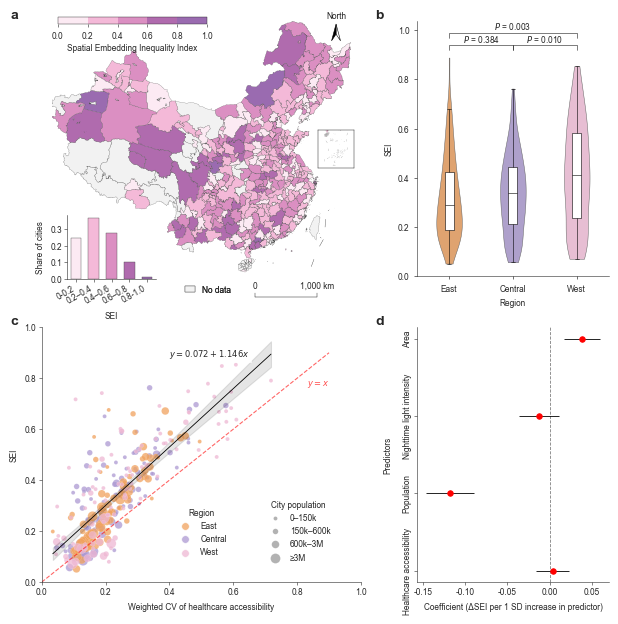

In [561]:
# Fig.3

from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch

# ======================================================
# ⭐ 全局字体（PDF 可编辑）
# ======================================================
mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial"],
    "font.size": 6,
    "axes.labelsize": 6,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "legend.fontsize": 6,
    "font.weight": "normal",
    "axes.labelweight": "normal",
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "axes.unicode_minus": False
})

MM_TO_INCH = 1 / 25.4
fig_w_in = 160 * MM_TO_INCH
fig_h_in = fig_w_in

fig = plt.figure(figsize=(fig_w_in, fig_h_in))

gs = GridSpec(
    nrows=2,
    ncols=2,
    height_ratios=[1, 1],
    width_ratios=[5, 3],
    wspace=0.22,
    hspace=0.2
)

ax_a = fig.add_subplot(gs[0, 0])
ax_b = fig.add_subplot(gs[0, 1])
ax_c = fig.add_subplot(gs[1, 0])
ax_d = fig.add_subplot(gs[1, 1])


# =========================
# 子图 a
# =========================
ax = ax_a

# ======================================================
# 1️⃣ 绑定 spatial inequality
# ======================================================
china["city_code"] = china["city_code"].astype(str)
df_spatial_inequality["city_code"] = df_spatial_inequality["city_code"].astype(str)

china["spatial_inequality"] = china["city_code"].map(
    df_spatial_inequality.set_index("city_code")["spatial_inequality"]
)

# 拆分：有数据 / 无数据
china_has = china[china["spatial_inequality"].notna()].copy()
china_na  = china[china["spatial_inequality"].isna()].copy()

# ======================================================
# 2️⃣ 离散分箱与颜色
# ======================================================
ineq_bins_map  = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]   # 地图用
ineq_bins_cbar = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]   # colorbar 用

ineq_colors = [
    "#FCEAF3",  # 1) very light blush pink（几乎背景色）
    "#F4B9D8",  # 2) clear light pink-lilac
    "#DB8FC2",  # 3) distinct mauve（中段明显跳变）
    "#B06BAE",  # 4) soft purple（不发灰）
    "#9A6BB0"   # 5) lightened purple（⭐ 不深、不压图）
]

ineq_cmap = ListedColormap(ineq_colors)
ineq_norm = BoundaryNorm(ineq_bins_map, ineq_cmap.N)

# ======================================================
# 3️⃣ 主图
# ======================================================
# —— 市界 —— 
# —— 无数据城市（灰色）——
china_na.plot(
    ax=ax,
    color="#F2F2F2",
    edgecolor="#4D4D4D",
    linewidth=0.15,
    zorder=1.5
)

# —— 有数据城市（按 spatial inequality）——
china_has.plot(
    ax=ax,
    column="spatial_inequality",
    cmap=ineq_cmap,
    norm=ineq_norm,
    edgecolor="#4D4D4D",
    linewidth=0.15,
    zorder=2
)

# 视图范围
xmin, ymin, xmax, ymax = china.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin + 0.26 * (ymax - ymin), ymax)
ax.set_axis_off()

# ======================================================
# 4️⃣ 南海 inset
# ======================================================
nine = china.loc[china["city_code"] == "100000"]
hainan = china.loc[china["省"] == "海南省"]
south_geom = unary_union(list(nine.geometry) + list(hainan.geometry))
minx_s, miny_s, maxx_s, maxy_s = south_geom.bounds

axins = inset_axes(
    ax, width="12%", height="20%",
    loc="lower right",
    bbox_to_anchor=(0.01, 0.40, 1, 1),
    bbox_transform=ax.transAxes,
    borderpad=0
)

axins.set_xlim(minx_s + 0.21*(maxx_s-minx_s),
               maxx_s - 0.26*(maxx_s-minx_s))
axins.set_ylim(miny_s + 0.28*(maxy_s-miny_s),
               maxy_s - 0.38*(maxy_s-miny_s))

scale = 0.4
cx0, cy0 = (minx_s + maxx_s)/2, (miny_s + maxy_s)/2
shrink = Affine2D().translate(-cx0, -cy0).scale(scale).translate(cx0, cy0)

china_na.plot(
    ax=axins,
    color="#F2F2F2",
    edgecolor="#4D4D4D",
    linewidth=0.15*scale,
    transform=shrink + axins.transData
)

china_has.plot(
    ax=axins,
    column="spatial_inequality",
    cmap=ineq_cmap,
    norm=ineq_norm,
    edgecolor="#4D4D4D",
    linewidth=0.15*scale,
    transform=shrink + axins.transData
)

axins.set_xticks([])
axins.set_yticks([])
for sp in axins.spines.values():
    sp.set_linewidth(0.3)
    sp.set_color("black")

# ======================================================
# 5️⃣ Colorbar
# ======================================================
cax = inset_axes(
    ax,
    width="50%",
    height="2.8%",
    loc="lower left",
    bbox_to_anchor=(0.02, 0.99, 1, 1),
    bbox_transform=ax.transAxes,
    borderpad=0
)

mappable = mpl.cm.ScalarMappable(cmap=ineq_cmap, norm=ineq_norm)
mappable.set_array([])

cbar = fig.colorbar(
    mappable,
    cax=cax,
    orientation="horizontal",
    boundaries=ineq_bins_cbar,
    ticks=[0, 0.2, 0.4, 0.6, 0.8, 1.0]
)

cbar.set_label("Spatial Embedding Inequality Index", fontsize=6, labelpad=2)
cbar.outline.set_linewidth(0.3)
cbar.ax.tick_params(labelsize=6, length=2.0, width=0.4)
cbar.ax.minorticks_off()


# no data 图例
missing_patch = Patch(
    facecolor="#F2F2F2",
    edgecolor="#4D4D4D",
    linewidth=0.3,
    label="No data"
)

missing_legend = ax.legend(
    handles=[missing_patch],
    loc="lower left",
    bbox_to_anchor=(0.42, -0.10),
    frameon=False,
    fontsize=6,
    handlelength=1.2
)

ax.add_artist(missing_legend)

# ======================================================
# 直方图
# ======================================================
ax_hist = inset_axes(
    ax,
    width="30%",
    height="25%",
    loc="lower left",
    bbox_to_anchor=(0.05, -0.01, 1, 1),
    bbox_transform=ax.transAxes,
    borderpad=0
)

# 有数据城市
vals = china_has["spatial_inequality"].dropna().values

# 与地图一致的分箱
counts, _ = np.histogram(vals, bins=ineq_bins_map)
n_total = counts.sum()
share = counts / n_total

# 类别轴位置
x_pos = np.arange(len(counts))     # [0,1,2,3,4]

# 等宽柱子
ax_hist.bar(
    x_pos,
    share,
    width=0.6,
    color=ineq_colors,
    edgecolor="#4D4D4D",
    linewidth=0.3
)

# x 轴标签（区间）
ax_hist.set_xticks(x_pos)
ax_hist.set_xticklabels(
    ["0-0.2", "0.2–0.4", "0.4–0.6", "0.6–0.8", "0.8-1.0"],
    fontsize=6,
    rotation=30,
    ha="right"
)

# y 轴：占比
ax_hist.set_yticks([0, 0.1, 0.2, 0.3])
ax_hist.set_ylabel("Share of cities", fontsize=6)
ax_hist.set_xlabel("SEI", fontsize=6)

# 样式（期刊风格）
ax_hist.tick_params(
    axis="both",
    which="major",
    direction="out",
    length=2.0,
    width=0.4,
    labelsize=6,
    pad=1.5,
    bottom=True,
    left=True,
    top=False,
    right=False
)

ax_hist.spines["top"].set_visible(False)
ax_hist.spines["right"].set_visible(False)
ax_hist.spines["left"].set_linewidth(0.4)
ax_hist.spines["bottom"].set_linewidth(0.4)

# ===========================
# 9️⃣ 比例尺（axes 坐标，panel 内）
# ===========================
scale_length_m = 1_000_000  # 1000 km

xmin, xmax = ax.get_xlim()
x0 = xmin + 0.68 * (xmax - xmin)
x1 = x0 + scale_length_m

y_ax = -0.08
h_ax = 0.015

ax.plot(
    [x0, x1], [y_ax, y_ax],
    transform=ax.get_xaxis_transform(),
    color="black", lw=0.3,
    clip_on=False
)

ax.plot(
    [x0, x0], [y_ax, y_ax + h_ax],
    transform=ax.get_xaxis_transform(),
    color="black", lw=0.3,
    clip_on=False
)

ax.plot(
    [x1, x1], [y_ax, y_ax + h_ax],
    transform=ax.get_xaxis_transform(),
    color="black", lw=0.3,
    clip_on=False
)

ax.text(
    x0, y_ax + h_ax + 0.01,
    "0",
    transform=ax.get_xaxis_transform(),
    ha="center", va="bottom",
    fontsize=6,
    clip_on=False
)

ax.text(
    x1, y_ax + h_ax + 0.01,
    "1,000 km",
    transform=ax.get_xaxis_transform(),
    ha="center", va="bottom",
    fontsize=6,
    clip_on=False
)

# ===========================
# 🧭 North Arrow + North
# ===========================
cx, cy = 0.95, 0.95
theta = np.deg2rad(150)
H, L = 0.04, 0.03

bottom = (cx, cy)
top = (cx, cy + H)
dx = L * np.sin(theta)
dy = -L * np.cos(theta)

left_tip = (cx - dx, cy - dy)
right_tip = (cx + dx, cy - dy)

ax.add_patch(Polygon([bottom, top, left_tip],
                     facecolor="black", edgecolor="none",
                     transform=ax.transAxes, clip_on=False))
ax.add_patch(Polygon([bottom, right_tip, top],
                     facecolor="white", edgecolor="none",
                     transform=ax.transAxes, clip_on=False))
ax.add_patch(Polygon([top, left_tip, bottom, right_tip],
                     facecolor="none", edgecolor="black",
                     linewidth=0.4, transform=ax.transAxes, clip_on=False))
ax.plot([bottom[0], top[0]], [bottom[1], top[1]],
        transform=ax.transAxes, color="black", lw=0.4, clip_on=False)

ax.text(cx, cy + H + 0.015, "North",
        transform=ax.transAxes, ha="center", va="bottom",
        fontsize=6, clip_on=False)


# =========================
# 子图 b
# =========================
ax = ax_b

order = ["East", "Central", "West"]
palette = ["#F1A25E", "#AC99D2", "#EEB7D3"]

# ====================
# 1️⃣ 小提琴图（只画分布，不画 inner）
# ====================
sns.violinplot(
    x="region",
    y="spatial_inequality",
    data=df_spatial_inequality,
    order=order,
    hue="region",
    palette=palette,
    cut=0,
    width=0.4,
    inner=None,
    linewidth=0.35,
    legend=False,
    ax=ax
)

# ====================
# 2️⃣ 叠加箱线图（白底，细线，和子图 c 一致）
# ====================
box_lw = 0.4

sns.boxplot(
    x="region",
    y="spatial_inequality",
    data=df_spatial_inequality,
    order=order,
    width=0.14,
    showcaps=True,
    showfliers=False,
    boxprops={
        "facecolor": "white",
        "edgecolor": "black",
        "linewidth": box_lw
    },
    whiskerprops={
        "color": "black",
        "linewidth": box_lw
    },
    capprops={
        "color": "black",
        "linewidth": box_lw
    },
    medianprops={
        "color": "black",
        "linewidth": box_lw
    },
    ax=ax
)

# ====================
# 3️⃣ 坐标轴与标签
# ====================
ax.set_xlim(-0.5, 2.5)

ax.set_xlabel("Region")
ax.set_ylabel("SEI", labelpad=3)

ax.set_xticks([0, 1, 2])
ax.set_xticklabels(["East", "Central", "West"])

# ===========================
# 4️⃣ 三组比较：显著性线 + P 值（保留你原来的）
# ===========================
y_max = df_spatial_inequality["spatial_inequality"].max()
h = 0.02

# East vs Central
y0 = y_max + 0.03
ax.plot([0, 0, 1, 1], [y0, y0+h, y0+h, y0], lw=0.4, c="k")
ax.text(0.5, y0+h+0.005, r"$\it{P}$ = 0.384",
        ha="center", va="bottom", fontsize=6)

# Central vs West
y1 = y_max + 0.03
ax.plot([1, 1, 2, 2], [y1, y1+h, y1+h, y1], lw=0.4, c="k")
ax.text(1.5, y1+h+0.005, r"$\it{P}$ = 0.010",
        ha="center", va="bottom", fontsize=6)

# East vs West
y2 = y_max + 0.08
ax.plot([0, 0, 2, 2], [y2, y2+h, y2+h, y2], lw=0.4, c="k")
ax.text(1.0, y2+h+0.005, r"$\it{P}$ = 0.003",
        ha="center", va="bottom", fontsize=6)

# ===========================
# 5️⃣ 轴样式（完全对齐子图 c）
# ===========================
ax.set_ylim(0, None)

ax.tick_params(
    axis="y",
    which="major",
    left=True,
    direction="out",
    length=2,
    width=0.4,
    color="black"
)

ax.tick_params(
    axis="x",
    which="major",
    bottom=True,
    direction="out",
    length=2,
    width=0.4,
    color="black"
)

sns.despine(ax=ax, top=True, right=True)
ax.spines["left"].set_linewidth(0.4)
ax.spines["bottom"].set_linewidth(0.4)

# ===========================
# ⑥ 轴样式
# ===========================
ax.set_ylim(0, None)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(0.4)
ax.spines["bottom"].set_linewidth(0.4)

ax.tick_params(
    axis="both",
    which="major",
    direction="out",
    length=2,
    width=0.4,
    labelsize=6,
    left=True,
    bottom=True
)

# =========================
# 子图 c
# =========================
ax = ax_c

# ===========================
# 0️⃣ 数据准备
# ===========================
# 筛选 n_communities >= 50 的城市
cities_big_comm = (
    df_global_Moran_I
    .loc[df_global_Moran_I["n_communities"] >= 50, "city_code"]
    .astype(str)
)

# 在 df_spatial_inequality 中匹配这些城市
df_reg = (
    df_spatial_inequality
    .copy()
)

df_reg["city_code"] = df_reg["city_code"].astype(str)


df_bubble = df_reg.loc[
    df_reg["city_code"].isin(cities_big_comm)
].copy()

# 人口规模分组（气泡大小）
df_bubble['population_category'] = pd.cut(
    df_bubble['city_population'],
    bins=[0, 150_000, 600_000, 3_000_000, np.inf],
    labels=["0–150k", "150k–600k", "600k–3M", "≥3M"],
    right=False,
    include_lowest=True
)

size_map = {
    '0–150k': 8,
    '150k–600k': 16,
    '600k–3M': 30,
    '≥3M': 50
}
df_bubble['bubble_size'] = df_bubble['population_category'].map(size_map).astype(float)

region_colors = {
    'East': "#F1A25E",
    'Central': "#AC99D2",
    'West': "#EEB7D3"
}

# ===========================
# 主图
# ===========================
for region, df_sub in df_bubble.groupby("region"):
    ax.scatter(
        df_sub["cv_access_weighted"],
        df_sub["spatial_inequality"],
        s=df_sub["bubble_size"],
        color=region_colors.get(region, "grey"),
        alpha=0.75,
        edgecolor="White",
        linewidth=0.1
    )

# 回归线
reg_df = df_bubble[["cv_access_weighted", "spatial_inequality"]].dropna()
x = reg_df["cv_access_weighted"].values
y = reg_df["spatial_inequality"].values

X = sm.add_constant(x)
model = sm.OLS(y, X).fit()

x_fit = np.linspace(x.min(), x.max(), 200)
y_fit = model.predict(sm.add_constant(x_fit))

ax.plot(x_fit, y_fit, color="black", linewidth=0.6, zorder=2)

ci = model.get_prediction(sm.add_constant(x_fit)).conf_int()
ax.fill_between(x_fit, ci[:, 0], ci[:, 1],
                color="black", alpha=0.1, zorder=1)

# 45° 线
ax.set_xlim(0, 0.9)
ax.set_ylim(0, 0.9)

ax.plot(
    [0, 0.9],
    [0, 0.9],
    linestyle="--",
    color="red",
    linewidth=0.8,
    alpha=0.6,
    zorder=1
)

# 标注
ax.text(
    0.9, 0.8,
    r"$y = x$",
    color="red",
    fontsize=6,
    ha="right",
    va="top",
    alpha=0.7
)

# 坐标轴
ax.set_xticks(np.arange(0, 1.01, 0.2))
ax.set_yticks(np.arange(0, 1.01, 0.2))

ax.tick_params(
    axis="both",
    which="major",
    direction="out",
    length=2.0,
    width=0.4,
    pad=2,
    bottom=True,
    left=True,
    top=False,
    right=False
)

ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)
ax.set_xlabel("Weighted CV of healthcare accessibility")
ax.set_ylabel("SEI")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(0.4)
ax.spines["bottom"].set_linewidth(0.4)


#人口规模图例
legend_sizes = [8, 16, 30, 50]
legend_labels = ["0–150k", "150k–600k", "600k–3M", "≥3M"]

legend_handles = [
    plt.scatter(
        [], [],
        s=s,
        color='grey',
        alpha=0.6,
        edgecolor="White",
        linewidth=0.1
    )
    for s in legend_sizes
]

pop_legend = ax.legend(
    legend_handles,
    legend_labels,
    title="City population",
    loc="lower left",
    bbox_to_anchor=(0.68, 0.05),
    frameon=False,
    fontsize=6,
    title_fontsize=6
)
ax.add_artist(pop_legend)

# 区域图例（圆圈，与气泡一致） 
region_handles = [
    plt.scatter(
        [], [],
        s=30, # 固定大小即可
        color=color,
        alpha=0.75,
        edgecolor='white',
        linewidth=0.5,
        label=region
    ) for region, color in region_colors.items()
    ] 
    
ax.legend(
    handles=region_handles,
    title='Region',
    loc='lower left',
    bbox_to_anchor=(0.4, 0.07),
    frameon=False,
    fontsize=6,
    title_fontsize=6
)

#标注斜率、截距和95%CI

# 斜率 & 截距
intercept = model.params[0]
slope = model.params[1]
# 斜率 95% CI
ci_params = model.conf_int()
slope_ci = ci_params[1]   # 第 2 行是斜率

# 斜率 & 截距
intercept = model.params[0]
slope = model.params[1]

reg_text = (
    r"$y = {:.3f} + {:.3f}x$".format(intercept, slope)
)

ax.text(
    0.40, 0.92,
    reg_text,
    transform=ax.transAxes,
    ha="left",
    va="top",
    fontsize=6,
    bbox=dict(
        facecolor="white",
        edgecolor="none",
        alpha=0.7,
        pad=1.5
    )
)

# =========================
# 子图 d
# =========================
ax = ax_d

# ===========================
# 1️⃣ 变量顺序（自下而上）
# ===========================
var_order = [
    "log_city_area_z",
    "city_nightlight_z",
    "log_city_population_z",
    "access_weighted_median_z"
][::-1]

# 显示用变量名
label_map = {
    "log_city_area_z": "Area",
    "city_nightlight_z": "Nighttime light intensity",
    "log_city_population_z": "Population",
    "access_weighted_median_z": "Healthcare accessibility"
}

# 回归
formula = """
spatial_inequality ~ access_weighted_median_z
                     + log_city_population_z
                     + city_nightlight_z
                     + log_city_area_z
                     + C(pro_code)
"""

model = smf.ols(formula=formula, data=df_spatial_inequality).fit()

vars_of_interest = [
    "access_weighted_median_z",
    "log_city_population_z",
    "city_nightlight_z",
    "log_city_area_z"
]

# 系数与 p 值
coef = model.params[vars_of_interest]
pval = model.pvalues[vars_of_interest]

# 95% 置信区间
ci = model.conf_int().loc[vars_of_interest]
ci.columns = ["ci_95_lower", "ci_95_upper"]

# 汇总结果表
result_table = pd.DataFrame({
    "coef": coef,
    "p_value": pval
}).join(ci)

# ===========================
# 2️⃣ 整理用于绘图的数据
# ===========================
plot_df = result_table.loc[var_order].copy()

y_pos = np.arange(len(var_order))

# ===========================
# 3️⃣ 开始绘图
# ===========================
ax.errorbar(
    plot_df["coef"],
    y_pos,
    xerr=[
        plot_df["coef"] - plot_df["ci_95_lower"],
        plot_df["ci_95_upper"] - plot_df["coef"]
    ],
    fmt="o",
    markersize=4,
    markerfacecolor="red",      # ⭐ 红点
    markeredgecolor="red",
    markeredgewidth=0.6,
    ecolor="black",             # ⭐ 黑色 CI 线
    elinewidth=0.6,
    capsize=0,                  # ⭐ 去掉“胡须竖线（caps）”
    zorder=3
)

# ===========================
# 4️⃣ 参考线（0）
# ===========================
ax.axvline(0, color="grey", linestyle="--", linewidth=0.6)

# ===========================
# 5️⃣ 轴与标签
# ===========================
ax.set_yticks(y_pos)
ax.set_yticklabels([label_map[v] for v in var_order])
plt.setp(ax.get_yticklabels(), rotation=90, va="center")

ax.set_xlabel("Coefficient (ΔSEI per 1 SD increase in predictor)")
ax.set_ylabel("Predictors", fontsize=6, labelpad=7)

# ===========================
# 6️⃣ 期刊风格美化
# ===========================
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(0.4)
ax.spines["bottom"].set_linewidth(0.4)

ax.tick_params(
    axis="both",
    which="major",
    direction="out",
    length=2,
    width=0.4,
    pad=2,
    bottom=True,
    left=True,
    top=False,
    right=False
)

# ======================================================
# 7️⃣ 子图编号(a–d)
# ======================================================
# figure 坐标（根据你 fig.subplots_adjust 后的布局）
x_left  = 0.02   # 左列统一
x_right = 0.6   # 右列统一

y_top    = 0.955  # 第一行统一
y_bottom = 0.47   # 第二行统一

fig.text(x_left,  y_top,    "a", fontsize=10, fontweight="bold")
fig.text(x_right, y_top,    "b", fontsize=10, fontweight="bold")
fig.text(x_left,  y_bottom, "c", fontsize=10, fontweight="bold")
fig.text(x_right, y_bottom, "d", fontsize=10, fontweight="bold")


# ===========================
# 8️⃣ 导出
# ===========================
fig.subplots_adjust(
    left=0.07,
    right=0.97,
    top=0.95,
    bottom=0.06
)


fig.savefig(
    "Fig_3.pdf",
    format="pdf",
    dpi=300
)

plt.show()

# 4. City typologies of healthcare accessibility and associated spatial embedding inequality

## Features

In [562]:
# HH社区所在patch的占比

results = []

# --------------------------------------------------
# 按城市逐一处理
# --------------------------------------------------
for city, city_df in df_patch_result_318.groupby("city_code"):

    # -----------------------------
    # 1️⃣ 该城市所有 patch 数量
    # -----------------------------
    total_patches = city_df["patch_id"].nunique()

    # -----------------------------
    # 2️⃣ 识别 HH / Pseudo-HH 社区
    # -----------------------------
    hh_city = city_df[city_df["cluster_type"] == "High-High"].copy()

    if hh_city.empty:
        # 👉 若没有 HH，用 access 前 20% 作为 Pseudo-HH
        thr = city_df["access"].quantile(0.80)
        hh_city = city_df[city_df["access"] >= thr].copy()
        hh_city["cluster_type"] = "Pseudo-HH"

    # -----------------------------
    # 3️⃣ HH / Pseudo-HH 所在 patch 数量
    # -----------------------------
    hh_patches = hh_city["patch_id"].nunique()

    # -----------------------------
    # 4️⃣ 占比
    # -----------------------------
    hh_patch_share = (
        hh_patches / total_patches
        if total_patches > 0 else 0
    )

    results.append([
        city,
        total_patches,
        hh_patches,
        hh_patch_share
    ])

# --------------------------------------------------
# 输出 DataFrame
# --------------------------------------------------
df_patch_hh_ratio = pd.DataFrame(
    results,
    columns=[
        "city_code",
        "total_patches",
        "hh_patches",
        "hh_patch_share"
    ]
)

In [563]:
df_spatial_inequality = df_spatial_inequality.merge(
    df_patch_hh_ratio[['city_code', 
                'hh_patch_share']],
    on='city_code',
    how='left'
)

In [564]:
# HH所在patch的人口占比

results = []

# --------------------------------------------------
# 按城市逐一处理（关键：城市级 HH / Pseudo-HH）
# --------------------------------------------------
for city, city_df in df_patch_result_318.groupby("city_code"):

    # -----------------------------
    # 1️⃣ 城市总人口
    # -----------------------------
    city_population = city_df["population"].sum()

    # -----------------------------
    # 2️⃣ 识别 HH / Pseudo-HH 社区
    # -----------------------------
    hh_city = city_df[city_df["cluster_type"] == "High-High"].copy()

    if hh_city.empty:
        # 👉 没有 HH，用 access 前 20% 作为 Pseudo-HH
        thr = city_df["access"].quantile(0.80)
        hh_city = city_df[city_df["access"] >= thr].copy()
        hh_city["cluster_type"] = "Pseudo-HH"

    # -----------------------------
    # 3️⃣ HH / Pseudo-HH 所在 patch
    # -----------------------------
    hh_patch_ids = hh_city["patch_id"].unique()

    # -----------------------------
    # 4️⃣ 这些 patch 内所有社区的人口
    # -----------------------------
    hh_patch_population = (
        city_df.loc[
            city_df["patch_id"].isin(hh_patch_ids),
            "population"
        ].sum()
    )

    # -----------------------------
    # 5️⃣ 占比
    # -----------------------------
    hh_patch_pop_share = (
        hh_patch_population / city_population
        if city_population > 0 else 0
    )

    results.append([
        city,
        hh_patch_pop_share
    ])

# --------------------------------------------------
# 输出 DataFrame
# --------------------------------------------------
df_hh_patch_share = pd.DataFrame(
    results,
    columns=[
        "city_code",
        "hh_patch_pop_share"
    ]
)

In [565]:
df_spatial_inequality = df_spatial_inequality.merge(
    df_hh_patch_share[['city_code', 
                'hh_patch_pop_share']],
    on='city_code',
    how='left'
)

In [566]:
def weighted_cv(x, w):
    """计算人口加权 CV"""
    x = np.array(x)
    w = np.array(w)
    if np.sum(w) == 0:
        return np.nan
    mean_w = np.average(x, weights=w)
    if mean_w == 0:
        return 0.0
    var_w = np.average((x - mean_w)**2, weights=w)
    return np.sqrt(var_w) / mean_w

def compute_hh_patch_access_cv(patch_df):
    city_results = []

    for city, city_df in patch_df.groupby("city_code"):

        # -------------------------------
        # ① 识别 HH / Pseudo-HH patch
        # -------------------------------
        hh_city = city_df[city_df["cluster_type"] == "High-High"].copy()
        if hh_city.empty:
            thr = city_df["access"].quantile(0.80)
            hh_city = city_df[city_df["access"] >= thr].copy()
            hh_city["cluster_type"] = "Pseudo-HH"

        hh_patch_ids = hh_city["patch_id"].unique().tolist()
        if len(hh_patch_ids) == 0:
            city_results.append([city, np.nan])
            continue

        # -------------------------------
        # ② 每个 HH patch 内计算人口加权 CV
        # -------------------------------
        patch_cv_list = []
        patch_pop_list = []

        for pid in hh_patch_ids:
            patch_data = city_df[city_df["patch_id"] == pid]
            if patch_data.empty:
                continue

            # patch 内人口加权 CV
            cv_patch = weighted_cv(patch_data["access"], patch_data["population"])
            patch_cv_list.append(cv_patch)

            # patch 总人口，用于城市加权
            patch_pop_list.append(patch_data["population"].sum())

        # -------------------------------
        # ③ 按 patch 总人口加权平均得到城市级 CV
        # -------------------------------
        if len(patch_cv_list) == 0 or np.sum(patch_pop_list) == 0:
            city_cv = np.nan
        else:
            city_cv = np.average(patch_cv_list, weights=patch_pop_list)

        city_results.append([city, city_cv])

    return pd.DataFrame(city_results, columns=["city_code", "cv_access_hh"])

# 调用函数
df_cv_hh = compute_hh_patch_access_cv(df_patch_result_318)

In [567]:
df_spatial_inequality = df_spatial_inequality.merge(
    df_cv_hh[['city_code', 
                'cv_access_hh']],
    on='city_code',
    how='left'
)

In [568]:
def weighted_cv(x, w):
    """计算人口加权 CV"""
    x = np.array(x)
    w = np.array(w)
    if np.sum(w) == 0:
        return np.nan
    mean_w = np.average(x, weights=w)
    if mean_w == 0:
        return 0.0
    var_w = np.average((x - mean_w)**2, weights=w)
    return np.sqrt(var_w) / mean_w

def compute_non_hh_patch_access_cv(patch_df):
    city_results = []

    for city, city_df in patch_df.groupby("city_code"):

        # -------------------------------
        # ① 识别 HH / Pseudo-HH patch（用于排除）
        # -------------------------------
        hh_city = city_df[city_df["cluster_type"] == "High-High"].copy()
        if hh_city.empty:
            thr = city_df["access"].quantile(0.80)
            hh_city = city_df[city_df["access"] >= thr].copy()
            hh_city["cluster_type"] = "Pseudo-HH"

        hh_patch_ids = hh_city["patch_id"].unique().tolist()

        # -------------------------------
        # ② 选出 non-HH patch
        # -------------------------------
        non_hh_city = city_df[~city_df["patch_id"].isin(hh_patch_ids)]
        if non_hh_city.empty:
            city_results.append([city, 0])
            continue

        non_hh_patch_ids = non_hh_city["patch_id"].unique().tolist()

        patch_cv_list = []
        patch_pop_list = []

        # -------------------------------
        # ③ 计算每个 non-HH patch 的人口加权 CV
        # -------------------------------
        for pid in non_hh_patch_ids:
            patch_data = non_hh_city[non_hh_city["patch_id"] == pid]
            if patch_data.empty:
                continue

            cv_patch = weighted_cv(patch_data["access"], patch_data["population"])
            patch_cv_list.append(cv_patch)

            patch_pop_list.append(patch_data["population"].sum())

        # -------------------------------
        # ④ 按 patch 人口加权平均得到城市级 CV
        # -------------------------------
        if len(patch_cv_list) == 0 or np.sum(patch_pop_list) == 0:
            city_cv = np.nan
        else:
            city_cv = np.average(patch_cv_list, weights=patch_pop_list)

        city_results.append([city, city_cv])

    return pd.DataFrame(city_results, columns=["city_code", "cv_access_non_hh"])

# 调用函数
df_cv_non_hh = compute_non_hh_patch_access_cv(df_patch_result_318)

In [569]:
df_spatial_inequality = df_spatial_inequality.merge(
    df_cv_non_hh[['city_code', 
                'cv_access_non_hh']],
    on='city_code',
    how='left'
)

In [570]:
def compute_distance_to_hh(patch_df, city_area_df):

    results = []

    # --------------------------------------------------
    # 1️⃣ patch 面积（= patch 内社区数量 × 1 km²）
    # --------------------------------------------------
    patch_area = (
        patch_df
        .groupby(["city_code", "patch_id"])
        .size()
        .rename("patch_n_cells")
        .reset_index()
    )

    patch_df = patch_df.merge(
        patch_area,
        on=["city_code", "patch_id"],
        how="left"
    )

    # --------------------------------------------------
    # 2️⃣ 按城市循环
    # --------------------------------------------------
    for city, city_df in patch_df.groupby("city_code"):

        # ---- 城市等效半径（米）----
        city_area_km2 = city_area_df.loc[
            city_area_df["city_code"] == city, "面积"
        ].values[0]

        city_length = np.sqrt(city_area_km2 * 1e6 / np.pi)

        # --------------------------------------------------
        # 3️⃣ 识别 HH / Pseudo-HH
        # --------------------------------------------------
        hh_city = city_df[city_df["cluster_type"] == "High-High"].copy()

        # 若无真实 HH → 用 Top 20% access 作为 Pseudo-HH
        if hh_city.empty:
            thr = city_df["access"].quantile(0.80)
            hh_city = city_df[city_df["access"] >= thr].copy()
            hh_city["cluster_type"] = "Pseudo-HH"

        hh_coords = hh_city[["x_proj", "y_proj"]].values
        hh_patch_ids = set(hh_city["patch_id"].unique())

        # --------------------------------------------------
        # 4️⃣ 距离函数（米）
        # --------------------------------------------------
        def nearest_distance(x, y, target_xy):
            dx = target_xy[:, 0] - x
            dy = target_xy[:, 1] - y
            return np.sqrt(dx**2 + dy**2).min()

        # --------------------------------------------------
        # 5️⃣ 遍历社区
        # --------------------------------------------------
        dist_within, pop_within = [], []
        dist_outside, pop_outside = [], []

        for _, row in city_df.iterrows():

            # ---- 排除 HH / Pseudo-HH 自身 ----
            if row["cluster_type"] in ["High-High", "Pseudo-HH"]:
                continue

            x, y = row["x_proj"], row["y_proj"]
            pop = row["population"]
            pid = row["patch_id"]

            # ---- patch 等效半径（社区 = 1 km²）----
            patch_area_km2 = row["patch_n_cells"] * 1.0
            patch_length = np.sqrt(patch_area_km2 * 1e6 / np.pi)

            # ---- patch 内存在 HH / PHH ----
            if pid in hh_patch_ids:

                patch_hh_xy = hh_city.loc[
                    hh_city["patch_id"] == pid,
                    ["x_proj", "y_proj"]
                ].values

                d = nearest_distance(x, y, patch_hh_xy)
                d_norm = d / patch_length

                dist_within.append(d_norm)
                pop_within.append(pop)

            # ---- patch 内无 HH / PHH ----
            else:
                d = nearest_distance(x, y, hh_coords)
                d_norm = d / city_length

                dist_outside.append(d_norm)
                pop_outside.append(pop)

        # --------------------------------------------------
        # 6️⃣ 人口加权平均
        # --------------------------------------------------
        within_city = (
            np.average(dist_within, weights=pop_within)
            if pop_within else 0
        )

        outside_city = (
            np.average(dist_outside, weights=pop_outside)
            if pop_outside else 0
        )

        results.append([
            city,
            within_city,
            outside_city
        ])

    return pd.DataFrame(
        results,
        columns=[
            "city_code",
            "distance_within_patch",
            "distance_outside_patch"
        ]
    )


# ==============================
# 运行
# ==============================
df_distances = compute_distance_to_hh(
    patch_df=df_patch_result_318,
    city_area_df=china[["city_code", "面积"]]
)

In [571]:
df_spatial_inequality = df_spatial_inequality.merge(
    df_distances[['city_code', 
                'distance_within_patch', 'distance_outside_patch']],
    on='city_code',
    how='left'
)

## Hierarchical clustering

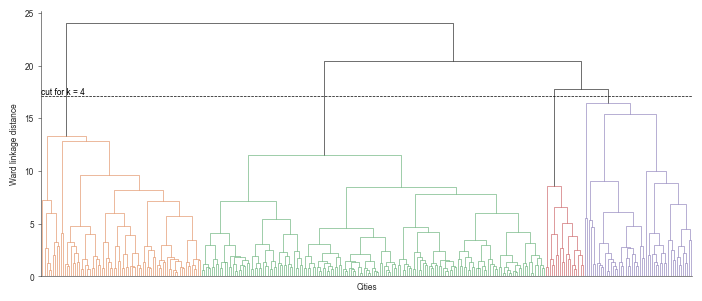

In [652]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial"],
    "font.size": 6,
    "axes.labelsize": 6,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "legend.fontsize": 6,
    "font.weight": "normal",
    "axes.labelweight": "normal",
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "axes.unicode_minus": False
})

features = [
    "hh_patch_share",
    "hh_patch_pop_share",
    "cv_access_weighted",
    "cv_access_hh",
    "cv_access_non_hh",
    "distance_within_patch",
    "distance_outside_patch",
]

df_cluster = df_spatial_inequality[features].dropna().copy()

scaler = StandardScaler()
X = scaler.fit_transform(df_cluster.values)

Z = linkage(X, method="ward")

# -------------------------
# 关键：确定 k=4 的切割高度
# -------------------------
n_clusters = 4
n = X.shape[0]

# 两个关键合并距离：保持 k 个簇的最后一次合并距离 vs 再往上会变成 k-1 个簇
d_k   = Z[n - n_clusters - 1, 2]
d_km1 = Z[n - n_clusters,     2]

# 取中点作为阈值；如果两者相等（tie），就稍微往下挪一点点，避免“切在结点上”
cut_height = (d_k + d_km1) / 2 if d_km1 > d_k else (d_k - 1e-10)

fig, ax = plt.subplots(figsize=(7, 3))

dendrogram(
    Z,
    ax=ax,
    no_labels=True,
    color_threshold=cut_height,
    above_threshold_color="black"
)

# ✅ 统一设置 dendrogram 线宽
for coll in ax.collections:
    coll.set_linewidth(0.4)



# 切割线
ax.axhline(cut_height, color="black", lw=0.5, ls="--")

# 给切割线加名字（推荐）
ax.text(
    0.01, cut_height,
    "cut for k = 4",
    va="bottom", ha="left",
    fontsize=6,
    color="black"
)

# 轴标签
ax.set_ylabel("Ward linkage distance")
ax.set_xlabel("Cities")

# ✅ 去掉右边框和上边框
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_linewidth(0.4)
ax.spines["bottom"].set_linewidth(0.4)


# ✅ 纵轴加刻度线（明确打开）
ax.yaxis.set_ticks_position("left")
ax.tick_params(axis="y", which="both", length=2, width=0.4)
ax.tick_params(axis="x", bottom=False) 

fig.tight_layout()
plt.show()

# 将层次聚类结果写入数据表
labels = fcluster(Z, t=4, criterion="maxclust")
df_cluster["hc_cluster"] = labels

In [574]:
df_spatial_inequality = df_spatial_inequality.merge(
    df_cluster[['hc_cluster']],
    left_index=True,
    right_index=True,
    how='left'
)

In [575]:
cluster_profile_raw = (
    df_cluster
    .groupby('hc_cluster')[features]
    .median()
)

cluster_profile_raw

,hh_patch_share,hh_patch_pop_share,cv_access_weighted,cv_access_hh,cv_access_non_hh,distance_within_patch,distance_outside_patch
hc_cluster,,,,,,,
1,0.158493,0.360730,0.340186,0.051213,0.071181,0.309801,0.767205
2,0.142857,0.845498,0.183133,0.101598,0.069948,0.379120,0.601902
3,0.500000,0.961541,0.098397,0.086186,0.038170,0.662358,0.680296
4,0.250000,0.665337,0.282213,0.078962,0.116893,1.007986,0.645886


In [576]:
cluster_size = df_cluster['hc_cluster'].value_counts().sort_index()
print("\n=== Cluster size ===")
print(cluster_size)


=== Cluster size ===
hc_cluster
1     78
2    168
3     19
4     53
Name: count, dtype: int64


## Kruskal–Wallis test

In [577]:
from scipy.stats import kruskal

grouped = df_cluster.groupby("hc_cluster")["hh_patch_pop_share"]

data = []
labels = []

for name, values in grouped:
    values = values.dropna()
    if len(values) > 0:
        data.append(values)
        labels.append(name)

H_stat, p_value = kruskal(*data)

print("hc_cluster groups:", labels)
print(f"Kruskal–Wallis H = {H_stat:.3f}")
print(f"p-value = {p_value:.4f}")

hc_cluster groups: [1, 2, 3, 4]
Kruskal–Wallis H = 170.940
p-value = 0.0000


In [578]:
grouped = df_cluster.groupby("hc_cluster")["cv_access_weighted"]

data = []
labels = []

for name, values in grouped:
    values = values.dropna()
    if len(values) > 0:
        data.append(values)
        labels.append(name)

H_stat, p_value = kruskal(*data)

print("cv_access_weighted:", labels)
print(f"Kruskal–Wallis H = {H_stat:.3f}")
print(f"p-value = {p_value:.4f}")

cv_access_weighted: [1, 2, 3, 4]
Kruskal–Wallis H = 124.205
p-value = 0.0000


In [579]:
grouped = df_cluster.groupby("hc_cluster")["cv_access_non_hh"]

data = []
labels = []

for name, values in grouped:
    values = values.dropna()
    if len(values) > 0:
        data.append(values)
        labels.append(name)

H_stat, p_value = kruskal(*data)

print("cv_access_non_hh:", labels)
print(f"Kruskal–Wallis H = {H_stat:.3f}")
print(f"p-value = {p_value:.4f}")

cv_access_non_hh: [1, 2, 3, 4]
Kruskal–Wallis H = 39.176
p-value = 0.0000


In [580]:
grouped = df_cluster.groupby("hc_cluster")["distance_within_patch"]

data = []
labels = []

for name, values in grouped:
    values = values.dropna()
    if len(values) > 0:
        data.append(values)
        labels.append(name)

H_stat, p_value = kruskal(*data)

print("distance_within_patch:", labels)
print(f"Kruskal–Wallis H = {H_stat:.3f}")
print(f"p-value = {p_value:.4f}")

distance_within_patch: [1, 2, 3, 4]
Kruskal–Wallis H = 83.588
p-value = 0.0000


In [581]:
grouped = df_spatial_inequality.groupby("hc_cluster")["spatial_inequality"]

data = []
labels = []

for name, values in grouped:
    values = values.dropna()
    if len(values) > 0:
        data.append(values)
        labels.append(name)

H_stat, p_value = kruskal(*data)

print("spatial_inequality:", labels)
print(f"Kruskal–Wallis H = {H_stat:.3f}")
print(f"p-value = {p_value:.4f}")

spatial_inequality: [1, 2, 3, 4]
Kruskal–Wallis H = 129.390
p-value = 0.0000


## Fig.4

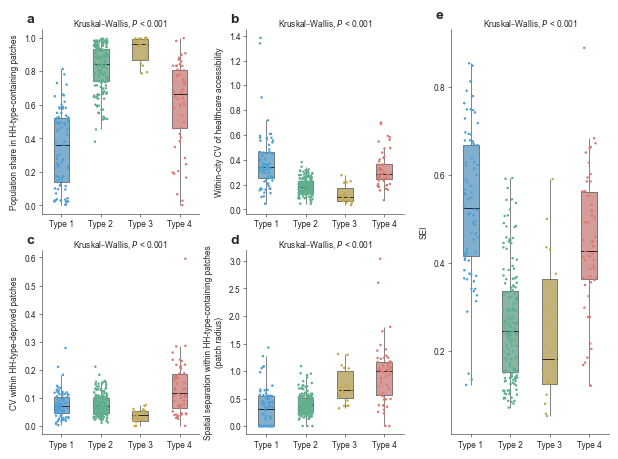

In [583]:
# Fig.4
np.random.seed(42)

# ======================================================
# ⭐ 全局字体（PDF 可编辑）
# ======================================================
mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial"],
    "font.size": 6,
    "axes.labelsize": 6,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "legend.fontsize": 6,
    "font.weight": "normal",
    "axes.labelweight": "normal",
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "axes.unicode_minus": False
})

# =========================
# 创建画布
# =========================
MM_TO_INCH = 1 / 25.4
fig_w_in = 160 * MM_TO_INCH
fig_h_in = (fig_w_in)/7*5

fig = plt.figure(figsize=(fig_w_in, fig_h_in))


# =========================
# 2 行 × 3 列 网格
# =========================
gs = GridSpec(
    nrows=2,
    ncols=3,
    figure=fig,
    wspace=0.3,
    hspace=0.2
)

# =========================
# 创建子图（按你指定的位置）
# =========================

# a：第 1 行，第 1 列
ax_a = fig.add_subplot(gs[0, 0])

# b：第 1 行，第 2 列
ax_b = fig.add_subplot(gs[0, 1])

# c：第 2 行，第 1 列
ax_c = fig.add_subplot(gs[1, 0])

# d：第 2 行，第 2 列
ax_d = fig.add_subplot(gs[1, 1])

# e：第 1–2 行，第 3 列（跨行）
ax_e = fig.add_subplot(gs[:, 2])

# =========================
# 子图 a
# =========================
ax = ax_a

# -----------------------------
# ① 准备数据
# -----------------------------
df_long = df_cluster[["hc_cluster", "hh_patch_pop_share"]].dropna()

cluster_names = {
    1: "Type 1",
    2: "Type 2",
    3: "Type 3",
    4: "Type 4"
}

df_long["cluster_name"] = df_long["hc_cluster"].map(cluster_names)

order = [cluster_names[c] for c in sorted(cluster_names.keys())]

palette = [
    "#5FAF8E",  # Type 1 
    "#4F9FD3",  # Type 2  
    "#D97973",  # Type 3  
    "#C4A84A",  # Type 4 
]


# -----------------------------
# ②  箱形图
# -----------------------------
sns.boxplot(
    x="cluster_name",
    y="hh_patch_pop_share",
    data=df_long,
    order=order,
    palette=palette,
    width=0.4,
    showcaps=False,
    showfliers=False,
    hue="cluster_name",
    boxprops={'linewidth': 0.5, 'zorder': 2},
    whiskerprops={'linewidth': 0.5, "zorder": 2},
    medianprops={'color': 'black', "linewidth": 0.55, "zorder": 3},
    ax=ax
)

# ===============================
# ⭐ 箱体透明度
# ===============================
for patch in ax.patches:
    facecolor = patch.get_facecolor()
    patch.set_facecolor(
        mcolors.to_rgba(facecolor, alpha=0.8)  # ⭐ 这里调透明度
    )

# -----------------------------
# ③ 散点
# -----------------------------

sns.stripplot(
    x="cluster_name",
    y="hh_patch_pop_share",
    data=df_long,
    order=order,
    hue="cluster_name",
    palette=palette,   # ⭐ 与 boxplot 完全一致
    dodge=False,
    size=1.8,
    jitter=0.18,
    alpha=1.0,
    zorder=4,
    ax=ax,
    legend=False  
)

# -----------------------------
# ④ 坐标轴样式
# -----------------------------
ax.set_xlabel("")
ax.set_ylabel("Population share in HH-type-containing patches")


ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(0.4)
ax.spines["bottom"].set_linewidth(0.4)

ax.tick_params(
    axis="both",
    which="major",
    direction="out",
    length=2,
    width=0.4,
    pad=2,
    bottom=True,
    left=True,
    top=False,
    right=False
)

# -----------------------------
# ⑤ 顶部整体显著性标注
# -----------------------------
ax.text(
    0.5,
    1.0,
    r"Kruskal–Wallis, $\it{P}$ < 0.001",
    transform=ax.transAxes,
    ha="center",
    va="bottom",
    fontsize=6
)

# =========================
# 子图 b
# =========================
ax = ax_b

# -----------------------------
# ① 准备数据
# -----------------------------
df_long = df_cluster[["hc_cluster", "cv_access_weighted"]].dropna()

cluster_names = {
    1: "Type 1",
    2: "Type 2",
    3: "Type 3",
    4: "Type 4"
}

df_long["cluster_name"] = df_long["hc_cluster"].map(cluster_names)
order = [cluster_names[c] for c in sorted(cluster_names.keys())]

# ⭐ 与子图 a 完全一致的深色配色
palette = [
    "#5FAF8E",  # Type 1
    "#4F9FD3",  # Type 2
    "#D97973",  # Type 3
    "#C4A84A",  # Type 4
]


# -----------------------------
# ② 箱形图
# -----------------------------
sns.boxplot(
    x="cluster_name",
    y="cv_access_weighted",
    data=df_long,
    order=order,
    palette=palette,
    width=0.4,
    showcaps=False,
    showfliers=False,
    hue="cluster_name",
    boxprops={'linewidth': 0.5, 'zorder': 2},
    whiskerprops={'linewidth': 0.5, 'zorder': 2},
    medianprops={'color': 'black', 'linewidth': 0.55, 'zorder': 3},
    ax=ax
)

# -----------------------------
# ⭐ 箱体透明度（同子图 a）
# -----------------------------
for patch in ax.patches:
    fc = patch.get_facecolor()
    patch.set_facecolor(mcolors.to_rgba(fc, alpha=0.8))

# -----------------------------
# ③ 散点（同色、同参数）
# -----------------------------
sns.stripplot(
    x="cluster_name",
    y="cv_access_weighted",
    data=df_long,
    order=order,
    hue="cluster_name",
    palette=palette,
    dodge=False,
    size=1.8,
    jitter=0.18,
    alpha=1.0,
    zorder=4,
    ax=ax,
    legend=False
)

# -----------------------------
# ④ 坐标轴样式（完全同子图 a）
# -----------------------------
ax.set_xlabel("")
ax.set_ylabel("Within-city CV of healthcare accessibility")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(0.4)
ax.spines["bottom"].set_linewidth(0.4)

ax.tick_params(
    axis="both",
    which="major",
    direction="out",
    length=2,
    width=0.4,
    pad=2,
    bottom=True,
    left=True,
    top=False,
    right=False
)

# -----------------------------
# ⑤ 顶部整体显著性标注
# -----------------------------
ax.text(
    0.5,
    1.0,
    r"Kruskal–Wallis, $\it{P}$ < 0.001",
    transform=ax.transAxes,
    ha="center",
    va="bottom",
    fontsize=6
)


# =========================
# 子图 c
# =========================
ax = ax_c

# -----------------------------
# ① 准备数据
# -----------------------------
df_long = df_cluster[["hc_cluster", "cv_access_non_hh"]].dropna()

cluster_names = {
    1: "Type 1",
    2: "Type 2",
    3: "Type 3",
    4: "Type 4"
}

df_long["cluster_name"] = df_long["hc_cluster"].map(cluster_names)
order = [cluster_names[c] for c in sorted(cluster_names.keys())]

# ⭐ 与子图 a / b 完全一致的深色配色
palette = [
    "#5FAF8E",  # Type 1
    "#4F9FD3",  # Type 2
    "#D97973",  # Type 3
    "#C4A84A",  # Type 4
]

# -----------------------------
# ② 箱形图（无 cap，样式同 a / b）
# -----------------------------
sns.boxplot(
    x="cluster_name",
    y="cv_access_non_hh",
    data=df_long,
    order=order,
    palette=palette,
    width=0.4,
    showcaps=False,
    showfliers=False,
    hue="cluster_name",
    boxprops={'linewidth': 0.5, 'zorder': 2},
    whiskerprops={'linewidth': 0.5, 'zorder': 2},
    medianprops={'color': 'black', 'linewidth': 0.55, 'zorder': 3},
    ax=ax
)

# -----------------------------
# ⭐ 箱体透明度（与 a / b 一致）
# -----------------------------
for patch in ax.patches:
    fc = patch.get_facecolor()
    patch.set_facecolor(mcolors.to_rgba(fc, alpha=0.8))

# -----------------------------
# ③ 散点（同色、同参数）
# -----------------------------
sns.stripplot(
    x="cluster_name",
    y="cv_access_non_hh",
    data=df_long,
    order=order,
    hue="cluster_name",
    palette=palette,
    dodge=False,
    size=1.8,
    jitter=0.18,
    alpha=1.0,
    zorder=4,
    ax=ax,
    legend=False
)

# -----------------------------
# ④ 坐标轴样式（完全同 a / b）
# -----------------------------
ax.set_xlabel("")
ax.set_ylabel("CV within HH-type-deprived patches")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(0.4)
ax.spines["bottom"].set_linewidth(0.4)

ax.tick_params(
    axis="both",
    which="major",
    direction="out",
    length=2,
    width=0.4,
    pad=2,
    bottom=True,
    left=True,
    top=False,
    right=False
)

# -----------------------------
# ⑤ 顶部整体显著性标注
# -----------------------------
ax.text(
    0.5,
    1.0,
    r"Kruskal–Wallis, $\it{P}$ < 0.001",
    transform=ax.transAxes,
    ha="center",
    va="bottom",
    fontsize=6
)


# =========================
# 子图 d
# =========================
ax = ax_d

# -----------------------------
# ① 准备数据
# -----------------------------
df_long = df_cluster[["hc_cluster", "distance_within_patch"]].dropna()

cluster_names = {
    1: "Type 1",
    2: "Type 2",
    3: "Type 3",
    4: "Type 4"
}

df_long["cluster_name"] = df_long["hc_cluster"].map(cluster_names)
order = [cluster_names[c] for c in sorted(cluster_names.keys())]

# ⭐ 与 a / b / c 完全一致的深色配色
palette = [
    "#5FAF8E",  # Type 1
    "#4F9FD3",  # Type 2
    "#D97973",  # Type 3
    "#C4A84A",  # Type 4
]

# -----------------------------
# ② 箱形图（无 cap，样式同 a / b / c）
# -----------------------------
sns.boxplot(
    x="cluster_name",
    y="distance_within_patch",
    data=df_long,
    order=order,
    palette=palette,
    width=0.4,
    showcaps=False,
    showfliers=False,
    hue="cluster_name",
    boxprops={'linewidth': 0.5, 'zorder': 2},
    whiskerprops={'linewidth': 0.5, 'zorder': 2},
    medianprops={'color': 'black', 'linewidth': 0.55, 'zorder': 3},
    ax=ax
)

# -----------------------------
# ⭐ 箱体透明度（与 a / b / c 一致）
# -----------------------------
for patch in ax.patches:
    fc = patch.get_facecolor()
    patch.set_facecolor(mcolors.to_rgba(fc, alpha=0.8))

# -----------------------------
# ③ 散点（同色、同参数）
# -----------------------------
sns.stripplot(
    x="cluster_name",
    y="distance_within_patch",
    data=df_long,
    order=order,
    hue="cluster_name",
    palette=palette,
    dodge=False,
    size=1.8,
    jitter=0.18,
    alpha=1.0,
    zorder=4,
    ax=ax,
    legend=False
)

# -----------------------------
# ④ 坐标轴样式（完全同 a / b / c）
# -----------------------------
ax.set_xlabel("")
ax.set_ylabel("Spatial separation within HH-type-containing patches\n(patch radius)")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(0.4)
ax.spines["bottom"].set_linewidth(0.4)

ax.tick_params(
    axis="both",
    which="major",
    direction="out",
    length=2,
    width=0.4,
    pad=2,
    bottom=True,
    left=True,
    top=False,
    right=False
)

# -----------------------------
# ⑤ 顶部整体显著性标注
# -----------------------------
ax.text(
    0.5,
    1.0,
    r"Kruskal–Wallis, $\it{P}$ < 0.001",
    transform=ax.transAxes,
    ha="center",
    va="bottom",
    fontsize=6
)


# =========================
# 子图 e
# =========================
ax = ax_e

# -----------------------------
# ① 准备数据
# -----------------------------
df_long = df_spatial_inequality[["hc_cluster", "spatial_inequality"]].dropna()

cluster_names = {
    1: "Type 1",
    2: "Type 2",
    3: "Type 3",
    4: "Type 4"
}

df_long["cluster_name"] = df_long["hc_cluster"].map(cluster_names)
order = [cluster_names[c] for c in sorted(cluster_names.keys())]

# ⭐ 与 a–d 完全一致的深色配色
palette = [
    "#5FAF8E",  # Type 1
    "#4F9FD3",  # Type 2
    "#D97973",  # Type 3
    "#C4A84A",  # Type 4
]

# -----------------------------
# ② 箱形图（无 cap，样式同 a–d）
# -----------------------------
sns.boxplot(
    x="cluster_name",
    y="spatial_inequality",
    data=df_long,
    order=order,
    palette=palette,
    width=0.4,
    showcaps=False,
    showfliers=False,
    hue="cluster_name",
    boxprops={'linewidth': 0.5, 'zorder': 2},
    whiskerprops={'linewidth': 0.5, 'zorder': 2},
    medianprops={'color': 'black', 'linewidth': 0.55, 'zorder': 3},
    ax=ax
)

# -----------------------------
# ⭐ 箱体透明度（与 a–d 一致）
# -----------------------------

for patch in ax.patches:
    fc = patch.get_facecolor()
    patch.set_facecolor(mcolors.to_rgba(fc, alpha=0.8))

# -----------------------------
# ③ 散点（同色、同参数）
# -----------------------------
sns.stripplot(
    x="cluster_name",
    y="spatial_inequality",
    data=df_long,
    order=order,
    hue="cluster_name",
    palette=palette,
    dodge=False,
    size=1.8,
    jitter=0.18,
    alpha=1.0,
    zorder=4,
    ax=ax,
    legend=False
)

# -----------------------------
# ④ 坐标轴样式（完全同 a–d）
# -----------------------------
ax.set_xlabel("")
ax.set_ylabel("SEI")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(0.4)
ax.spines["bottom"].set_linewidth(0.4)

ax.tick_params(
    axis="both",
    which="major",
    direction="out",
    length=2,
    width=0.4,
    pad=2,
    bottom=True,
    left=True,
    top=False,
    right=False
)

# -----------------------------
# ⑤ 顶部整体显著性标注
# -----------------------------
ax.text(
    0.5,
    1.0,
    r"Kruskal–Wallis, $\it{P}$ < 0.001",
    transform=ax.transAxes,
    ha="center",
    va="bottom",
    fontsize=6
)

# ======================================================
# 子图编号(a–e)
# ======================================================
labels = ['a', 'b', 'c', 'd', 'e']
axes = [ax_a, ax_b, ax_c, ax_d, ax_e]

labels = ['a', 'b', 'c', 'd', 'e']
for ax, lab in zip(axes, labels):
    ax.text(
        -0.05, 1.02, lab,
        transform=ax.transAxes,
        fontsize=10,
        fontweight='bold',
        va='bottom',
        ha='right'
    )


# ===========================
# 8️⃣ 导出
# ===========================
fig.subplots_adjust(
    left=0.07,
    right=0.97,
    top=0.95,
    bottom=0.05
)

fig.savefig(
    "Fig_4.pdf",
    format="pdf",
    dpi=300
)

plt.show()

# Supplementary Information

## S1

In [591]:
#分地区_D’Agostino–Pearson 正态性检验，检验acccess是否服从正态分布，结果是不服从

for region in df["region"].dropna().unique():  # 忽略 NaN
    data_access_region = df.loc[df["region"]==region, "access"]
    
    if len(data_access_region) >= 3:
        stat, p = normaltest(data_access_region)
        print(f"地区 {region} - access p={p:.4f}")
    else:
        print(f"地区 {region} 样本量太少，无法进行正态性检验 (样本数: {len(data_access_region)})")

地区 Central - access p=0.0000
地区 West - access p=0.0000
地区 East - access p=0.0000


In [592]:
# ---------- Bootstrap 函数：生成 rank-biserial r 的 CI ----------
def bootstrap_r_ci(data1, data2, n_bootstrap=1000, alpha=0.05, random_state=None):
    rng = np.random.default_rng(random_state)
    n1, n2 = len(data1), len(data2)
    boot_rs = []

    for _ in range(n_bootstrap):
        # bootstrap 重抽样
        sample1 = rng.choice(data1, n1, replace=True)
        sample2 = rng.choice(data2, n2, replace=True)

        U_boot, _ = mannwhitneyu(sample1, sample2, alternative="two-sided")
        r_boot = 1 - 2 * U_boot / (n1 * n2)
        boot_rs.append(r_boot)

    lower = np.percentile(boot_rs, 100 * alpha / 2)
    upper = np.percentile(boot_rs, 100 * (1 - alpha / 2))
    return lower, upper


# ---------- 获取 df 中所有 region ----------
region_groups = df['region'].dropna().unique()
region_groups.sort()

print("=== Mann-Whitney U 两两比较（access：含中位数、效应量 r、Bootstrap 95% CI） ===\n")

# ---------- 两两比较 ----------
for group1, group2 in itertools.combinations(region_groups, 2):

    data1 = df.loc[df['region'] == group1, 'access'].dropna().values
    data2 = df.loc[df['region'] == group2, 'access'].dropna().values

    if len(data1) == 0 or len(data2) == 0:
        print(f"{group1} vs {group2}: 样本不足")
        continue

    # Mann–Whitney U
    U, p = mannwhitneyu(data1, data2, alternative="two-sided")

    # 中位数
    med1, med2 = np.median(data1), np.median(data2)

    # rank-biserial correlation
    n1, n2 = len(data1), len(data2)
    r = 1 - 2 * U / (n1 * n2)

    # Bootstrap CI
    ci_lower, ci_upper = bootstrap_r_ci(
    data1, data2,
    n_bootstrap=1000,
    alpha=0.05,
    random_state=42
    )


    # 输出
    print(
        f"{group1} vs {group2}: "
        f"U={U:.2f}, p={p:.4f}, "
        f"中位数=({med1:.3f}, {med2:.3f}), "
        f"r={r:.3f}, 95% CI=({ci_lower:.3f}, {ci_upper:.3f})"
    )

=== Mann-Whitney U 两两比较（access：含中位数、效应量 r、Bootstrap 95% CI） ===

Central vs East: U=810698671.50, p=0.0000, 中位数=(48.086, 45.229), r=-0.093, 95% CI=(-0.102, -0.084)
Central vs West: U=235684411.00, p=0.0000, 中位数=(48.086, 56.500), r=0.125, 95% CI=(0.114, 0.135)
East vs West: U=397309833.50, p=0.0000, 中位数=(45.229, 56.500), r=0.240, 95% CI=(0.230, 0.250)


In [593]:
#Shapiro–Wilk 正态性检验，结果为不服从正态分布
for region in df_city_cv_unweighted["region"].dropna().unique():
    data_si = df_city_cv_unweighted.loc[df_city_cv_unweighted["region"] == region, "cv_access"].dropna()

    if len(data_si) >= 3:
        stat_si, p_si = shapiro(data_si)
        print(f"地区 {region} - cv_access 正态性 p={p_si:.4f}")
    else:
        print(f"地区 {region} 样本量太少，无法进行正态性检验 (n={len(data_si)})")

地区 East - cv_access 正态性 p=0.0014
地区 Central - cv_access 正态性 p=0.0426
地区 West - cv_access 正态性 p=0.0000


In [594]:
# ---------- Bootstrap 函数：生成 rank-biserial r 的 CI ----------
def bootstrap_r_ci(data1, data2, n_bootstrap=1000, alpha=0.05, random_state=None):
    rng = np.random.default_rng(random_state)
    n1, n2 = len(data1), len(data2)
    boot_rs = []

    for _ in range(n_bootstrap):
        # bootstrap 重抽样
        sample1 = rng.choice(data1, n1, replace=True)
        sample2 = rng.choice(data2, n2, replace=True)

        U_boot, _ = mannwhitneyu(sample1, sample2, alternative="two-sided")
        r_boot = 1 - 2 * U_boot / (n1 * n2)
        boot_rs.append(r_boot)

    lower = np.percentile(boot_rs, 100 * alpha / 2)
    upper = np.percentile(boot_rs, 100 * (1 - alpha / 2))
    return lower, upper


# ---------- 获取 df_city_cv_unweighted 中所有 region ----------
region_groups = df_city_cv_unweighted['region'].dropna().unique()
region_groups.sort()

print("=== Mann-Whitney U 两两比较（cv_access：含中位数、效应量 r、Bootstrap 95% CI） ===\n")

# ---------- 两两比较 ----------
for group1, group2 in itertools.combinations(region_groups, 2):

    data1 = df_city_cv_unweighted.loc[df_city_cv_unweighted['region'] == group1, 'cv_access'].dropna().values
    data2 = df_city_cv_unweighted.loc[df_city_cv_unweighted['region'] == group2, 'cv_access'].dropna().values

    if len(data1) == 0 or len(data2) == 0:
        print(f"{group1} vs {group2}: 样本不足")
        continue

    # Mann–Whitney U
    U, p = mannwhitneyu(data1, data2, alternative="two-sided")

    # 中位数
    med1, med2 = np.median(data1), np.median(data2)

    # rank-biserial correlation
    n1, n2 = len(data1), len(data2)
    r = 1 - 2 * U / (n1 * n2)

    # Bootstrap CI
    ci_lower, ci_upper = bootstrap_r_ci(
    data1, data2,
    n_bootstrap=1000,
    alpha=0.05,
    random_state=42
    )


    # 输出
    print(
        f"{group1} vs {group2}: "
        f"U={U:.2f}, p={p:.4f}, "
        f"中位数=({med1:.3f}, {med2:.3f}), "
        f"r={r:.3f}, 95% CI=({ci_lower:.3f}, {ci_upper:.3f})"
    )

=== Mann-Whitney U 两两比较（cv_access：含中位数、效应量 r、Bootstrap 95% CI） ===

Central vs East: U=7842.00, p=0.0018, 中位数=(0.301, 0.258), r=-0.240, 95% CI=(-0.389, -0.089)
Central vs West: U=6126.00, p=0.0247, 中位数=(0.301, 0.362), r=0.167, 95% CI=(0.022, 0.314)
East vs West: U=5126.00, p=0.0000, 中位数=(0.258, 0.362), r=0.345, 95% CI=(0.203, 0.466)


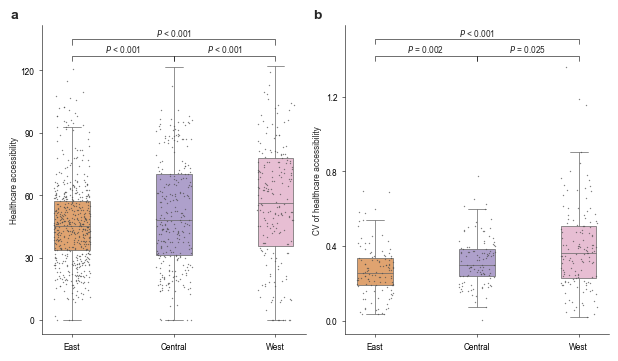

In [595]:
np.random.seed(42)

# ===============================
# 全局字体与 PDF 设置
# ===============================
mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial"],
    "font.size": 6,
    "axes.labelsize": 6,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "legend.fontsize": 6,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "axes.unicode_minus": False
})

order = ["East", "Central", "West"]
palette_comm = ["#AC99D2", "#EEB7D3", "#F1A25E"]
palette_city = ["#F1A25E", "#AC99D2", "#EEB7D3"]

# ===============================
# 画布：7 × 4（SI 标准）
# ===============================
MM_TO_INCH = 1 / 25.4
fig_w_in = 160 * MM_TO_INCH
fig_h_in = (fig_w_in)/7*4

fig = plt.figure(figsize=(fig_w_in, fig_h_in))

gs = GridSpec(
    nrows=1,
    ncols=2,
    width_ratios=[1, 1],
    wspace=0.15
)

# ⭐ 按「列」定义顺序
axes = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[0, 1])
]

ax1 = axes[0] 
ax2 = axes[1] 

# ======================================================
# Panel A: Community-level accessibility
# ======================================================
df_sample = (
    df.groupby("region", group_keys=False)
      .sample(frac=0.01, random_state=42)
)

sns.boxplot(
    ax=ax1,
    x="region", y="access",
    hue="region", data=df,
    order=order, palette=palette_comm,
    showfliers=False, width=0.35,
    linewidth=0.5, legend=False
)

sns.stripplot(
    ax=ax1,
    x="region", y="access",
    data=df_sample,
    order=order,
    color="#4D4D4D",
    size=1.0, jitter=0.18,
    alpha=0.7, linewidth=0
)

ax1.set_xlabel("")
ax1.set_ylabel("Healthcare accessibility", labelpad=1)

# 显著性
pairs = [(0, 1), (0, 2), (1, 2)]
y_max = df["access"].max()
h = 2.8
heights = [y_max + 2, y_max + 10, y_max + 2]

for (x1, x2), y in zip(pairs, heights):
    ax1.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.4, c="black")
    ax1.text((x1+x2)/2, y+h+0.5, r"$\it{P}$ < 0.001",
             ha="center", va="bottom",
             fontsize=6)

# ======================================================
# Panel B: City-level CV
# ======================================================
sns.boxplot(
    ax=ax2,
    x="region", y="cv_access",
    hue="region",
    data=df_city_cv_unweighted,
    order=order, palette=palette_city,
    showfliers=False, width=0.35,
    linewidth=0.5, legend=False
)

sns.stripplot(
    ax=ax2,
    x="region", y="cv_access",
    data=df_city_cv_unweighted,
    order=order,
    color="#4D4D4D",
    size=1.0, jitter=0.18,
    alpha=0.7, linewidth=0
)

ax2.set_xlabel("")
ax2.set_ylabel("CV of healthcare accessibility", labelpad=3)

# 显著性
pairs_low = [(0, 1, r"$\it{P}$ = 0.002"), (1, 2, r"$\it{P}$ = 0.025")]
pair_high = (0, 2, r"$\it{P}$ < 0.001")

y_max = df_city_cv_unweighted["cv_access"].max()
h = 0.03
y_low = y_max + 0.03
y_high = y_max + 0.12

for x1, x2, label in pairs_low:
    ax2.plot([x1, x1, x2, x2], [y_low, y_low+h, y_low+h, y_low],
             lw=0.4, c="black")
    ax2.text((x1+x2)/2, y_low+h+0.005, label,
             ha="center", va="bottom",
             fontsize=6)

x1, x2, label = pair_high
ax2.plot([x1, x1, x2, x2], [y_high, y_high+h, y_high+h, y_high],
         lw=0.4, c="black")
ax2.text((x1+x2)/2, y_high+h+0.005, label,
         ha="center", va="bottom",
         fontsize=6)

# ======================================================
# 统一风格
# ======================================================
for ax in axes:
    sns.despine(ax=ax)

    # 轴线
    for spine in ["bottom", "left"]:
        ax.spines[spine].set_linewidth(0.4)
        ax.spines[spine].set_color("black")

    # ✅ 刻度线：强制可见（关键）
    ax.tick_params(
        axis="both", which="major",
        direction="out",          
        length=2,           
        width=0.4,             
        colors="black",          
        bottom=True, left=True,
        top=False, right=False
    )

    # ✅ 明确刻度位置（有些样式会影响）
    ax.xaxis.set_ticks_position("bottom")
    ax.yaxis.set_ticks_position("left")

    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(order)
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))


ax1.text(
    -0.12, 1.05, "a",
    transform=ax1.transAxes,
    fontsize=10,
    fontweight="bold",
    va="top",
    ha="left"
)

ax2.text(
    -0.12, 1.05, "b",
    transform=ax2.transAxes,
    fontsize=10,
    fontweight="bold",
    va="top",
    ha="left"
)


fig.subplots_adjust(left=0.08, right=0.98, bottom=0.06, top=0.92, wspace=0.25)


fig.savefig(
    "S1.pdf",
    format="pdf",
    dpi=300
)

plt.show()

## S4

In [596]:
from scipy.spatial import cKDTree

# ---------- 输入数据 ----------
df_citypatch = df_patch_result_318.copy()

# ✅ 使用投影坐标（米）
df_citypatch = df_citypatch[
    ["city_code", "patch_id", "cluster_type", "x_proj", "y_proj", "access"]
].copy()

results = []

# ---------- 逐城市处理 ----------
for city, subdf in df_citypatch.groupby("city_code"):

    # 拆分 LL 与 HH
    df_LL = subdf[subdf["cluster_type"] == "Low-Low"]
    df_HH = subdf[subdf["cluster_type"] == "High-High"]

    # 没有 LL → 跳过
    if df_LL.empty:
        continue

    # 没有 HH → 用 access 前 10% 代替
    if df_HH.empty:
        top_n = max(1, int(len(subdf) * 0.1))
        df_HH = subdf.nlargest(top_n, "access")

    # ---------- KDTree（单位：米） ----------
    hh_coords = df_HH[["x_proj", "y_proj"]].to_numpy()
    tree = cKDTree(hh_coords)

    ll_coords = df_LL[["x_proj", "y_proj"]].to_numpy()
    dist_m, _ = tree.query(ll_coords, k=1)   # ✅ 米

    # ---------- 城市尺度归一化 ----------
    city_area = china.loc[china["city_code"] == city, "面积"].values
    if len(city_area) == 0:
        continue

    # 面积单位：km² → 等效半径（km）
    area_sqrt_km = np.sqrt(city_area[0] / np.pi)

    # 距离从 m → km
    dist_km = dist_m / 1000.0

    norm_dist = dist_km / area_sqrt_km

    # ---------- 保存 ----------
    for d, nd in zip(dist_km, norm_dist):
        results.append({
            "city_code": city,
            "LL_to_HH_distance_km": d,
            "norm_distance": nd
        })

# ---------- 输出 ----------
df_LL_HH_dist = pd.DataFrame(results)

In [597]:
df_LL_HH_dist['norm_distance'].describe()

count    18413.000000
mean         0.819408
std          0.394275
min          0.017314
25%          0.527352
50%          0.764514
75%          1.041232
max          4.254575
Name: norm_distance, dtype: float64

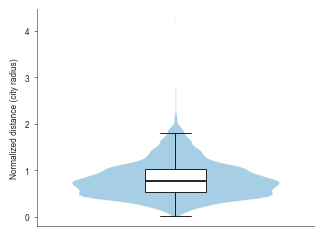

In [598]:
# ======================================================
# 全局字体（PDF 可编辑）
# ======================================================
mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial"],
    "font.size": 6,
    "axes.labelsize": 6,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "legend.fontsize": 6,
    "font.weight": "normal",
    "axes.labelweight": "normal",
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "axes.unicode_minus": False
})

# =========================
# 1️⃣ 数据
# =========================
vals = df_LL_HH_dist["norm_distance"].dropna().astype(float).values

# =========================
# 2️⃣ 作图
# =========================
MM_TO_INCH = 1 / 25.4
fig_w_in = 80 * MM_TO_INCH
fig_h_in = (fig_w_in)/5*4

fig = plt.figure(figsize=(fig_w_in, fig_h_in))

ax = fig.add_subplot(1, 1, 1)

# -------- 小提琴图（背景）--------
vp = ax.violinplot(
    [vals],
    positions=[1],
    widths=0.75,
    showmeans=False,
    showmedians=False,
    showextrema=False
)

for body in vp["bodies"]:
    body.set_alpha(0.35)
    body.set_linewidth(0.4)
    body.set_facecolor("#0074B3")

# -------- 箱形图（前景）--------
ax.boxplot(
    [vals],
    positions=[1],
    widths=0.22,
    vert=True,
    patch_artist=True,
    showfliers=False,   # 不画离群点
    boxprops=dict(facecolor="white", edgecolor="black", linewidth=0.6),
    medianprops=dict(color="black", linewidth=1.2),
    whiskerprops=dict(color="black", linewidth=0.6),
    capprops=dict(color="black", linewidth=0.6)
)

# =========================
# 3️⃣ 坐标轴与样式
# =========================
ax.set_xticks([])
ax.set_ylabel("Normalized distance (city radius)")

ax.tick_params(
    axis="both", which="major",
    direction="out",
    length=2.0,
    width=0.4,
    bottom=True,
    left=True,
    top=False,
    right=False
)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(0.4)
ax.spines["bottom"].set_linewidth(0.4)

fig.subplots_adjust(left=0.10, right=0.98, bottom=0.06, top=0.92)

# =========================
# 4️⃣ 导出
# =========================
fig.savefig(
    "S4.pdf",
    format="pdf",
    dpi=300
)

plt.show()

## S5

In [599]:
types = ["High-High", "Low-Low"]

print("=== Linear regression results (percentage ~ patch_size) ===\n")

for ct in types:
    perc_col = f"{ct}_perc"

    sub = patch_summary[[perc_col, "patch_size"]].dropna().copy()
    sub = sub.rename(columns={perc_col: "percentage"})
    sub[["percentage", "patch_size"]] = sub[["percentage", "patch_size"]].apply(
        pd.to_numeric, errors="coerce"
    )
    sub = sub.dropna()

    X = sm.add_constant(sub["patch_size"])
    y = sub["percentage"]

    model = sm.OLS(y, X).fit()
    results = model.summary2().tables[1]

    coef = results.loc["patch_size", "Coef."]
    std_err = results.loc["patch_size", "Std.Err."]
    t_val = results.loc["patch_size", "t"]
    p_val = results.loc["patch_size", "P>|t|"]
    ci_low = results.loc["patch_size", "[0.025"]
    ci_high = results.loc["patch_size", "0.975]"]
    r2 = model.rsquared
    n = int(model.nobs)

    print(
        f"{ct}: "
        f"N={n}, "
        f"coef={coef:.4f}, std err={std_err:.4f}, t={t_val:.3f}, "
        f"p-value={p_val:.3e}, 95% CI=[{ci_low:.4f}, {ci_high:.4f}], "
        f"R²={r2:.4f}"
    )

=== Linear regression results (percentage ~ patch_size) ===

High-High: N=4490, coef=0.0005, std err=0.0001, t=10.474, p-value=2.223e-25, 95% CI=[0.0004, 0.0006], R²=0.0239
Low-Low: N=4490, coef=-0.0007, std err=0.0001, t=-8.022, p-value=1.313e-15, 95% CI=[-0.0009, -0.0005], R²=0.0141


## S7

In [600]:
df_bubble_east=df_bubble[df_bubble['region'] == 'East']
df_bubble_central=df_bubble[df_bubble['region'] == 'Central']
df_bubble_west=df_bubble[df_bubble['region'] == 'West']

In [601]:
len(df_bubble_east)

96

In [602]:
len(df_bubble_central)

103

In [603]:
len(df_bubble_west)

100

In [604]:
df_east_high=df_bubble_east[df_bubble_east['spatial_inequality'] > df_bubble_east['cv_access_weighted']]
df_central_high=df_bubble_central[df_bubble_central['spatial_inequality'] > df_bubble_central['cv_access_weighted']]
df_west_high=df_bubble_west[df_bubble_west['spatial_inequality'] > df_bubble_west['cv_access_weighted']]

In [605]:
len(df_east_high)

83

In [606]:
len(df_central_high)

89

In [384]:
len(df_west_high)

83

In [607]:
len(df_east_high)/len(df_bubble_east)

0.8645833333333334

In [608]:
len(df_central_high)/len(df_bubble_central)

0.8640776699029126

In [609]:
len(df_west_high)/len(df_bubble_west)

0.83

In [610]:
# 定义分组区间（左闭右开）
bins = [0, 150_000, 600_000, 3_000_000, np.inf]

labels = ["0–150k", "150k–600k", "600k–3M", "≥3M"]

# 生成区间变量（左闭右开）
df_bubble["pop_group"] = pd.cut(
    df_bubble["city_population"],
    bins=bins,
    labels=labels,
    right=False  # ⭐ 左闭右开
)

# 生成四个 dataframe
df_0_150k = df_bubble[df_bubble["pop_group"] == "0–150k"].copy()
df_150k_600k = df_bubble[df_bubble["pop_group"] == "150k–600k"].copy()
df_600k_3M = df_bubble[df_bubble["pop_group"] == "600k–3M"].copy()
df_3M_plus = df_bubble[df_bubble["pop_group"] == "≥3M"].copy()

In [611]:
len(df_0_150k)

123

In [612]:
len(df_150k_600k)

83

In [613]:
len(df_600k_3M)

71

In [614]:
len(df_3M_plus)

22

In [615]:
df_0_150k_high=df_0_150k[df_0_150k['spatial_inequality'] > df_0_150k['cv_access_weighted']]
df_150k_600k_high=df_150k_600k[df_150k_600k['spatial_inequality'] > df_150k_600k['cv_access_weighted']]
df_600k_3M_high=df_600k_3M[df_600k_3M['spatial_inequality'] > df_600k_3M['cv_access_weighted']]
df_3M_plus_high=df_3M_plus[df_3M_plus['spatial_inequality'] > df_3M_plus['cv_access_weighted']]

In [616]:
len(df_0_150k_high)

115

In [617]:
len(df_150k_600k_high)

75

In [618]:
len(df_600k_3M_high)

52

In [619]:
len(df_3M_plus_high)

13

In [620]:
len(df_0_150k_high)/len(df_0_150k)

0.9349593495934959

In [621]:
len(df_150k_600k_high)/len(df_150k_600k)

0.9036144578313253

In [622]:
len(df_600k_3M_high)/len(df_600k_3M)

0.7323943661971831

In [623]:
len(df_3M_plus_high)/len(df_3M_plus)

0.5909090909090909

## S8

In [624]:
#按城市计算人口加权gini系数（标准化）

def gini_weighted(x, w):
    x = np.asarray(x)
    w = np.asarray(w)

    if len(x) == 0:
        return np.nan

    # 如果所有 x 都相同（包括全0），Gini = 0
    if np.all(x == x[0]):
        return 0.0

    # 排序
    sorted_idx = np.argsort(x)
    x = x[sorted_idx]
    w = w[sorted_idx]

    # 累积权重和累积“加权值”
    cumw = np.cumsum(w)
    cumxw = np.cumsum(x * w)

    # 如果所有 x*w 之和为 0，则 Gini=0（例如 x 全 0）
    if cumxw[-1] == 0:
        return 0.0

    # 归一化
    cumw = cumw / cumw[-1]
    cumxw = cumxw / cumxw[-1]

    # Lorenz 曲线下面积
    B = np.trapz(cumxw, cumw)
    G = 1 - 2 * B
    return G


# 按城市计算人口加权Gini系数
gini_results = {}
for city, group in df.groupby('city_code'):
    access = group['access'].values
    population = group['population'].values
    gini_results[city] = gini_weighted(access, population)

weighted_gini = pd.DataFrame(list(gini_results.items()), columns=['city_code', 'gini_weighted'])

In [625]:
weighted_gini['gini_weighted'].describe()

count    360.000000
mean       0.121129
std        0.088946
min        0.016624
25%        0.058132
50%        0.097313
75%        0.153944
max        0.677667
Name: gini_weighted, dtype: float64

In [626]:
weighted_gini["city_code"] = weighted_gini["city_code"].astype(int).astype(str)

In [627]:
df_spatial_inequality = df_spatial_inequality.merge(
    weighted_gini[["city_code", "gini_weighted"]],
    on="city_code", how="left"
)

In [628]:
# 筛选 n_communities >= 50 的城市
cities_big_comm = (
    df_global_Moran_I
    .loc[df_global_Moran_I["n_communities"] >= 50, "city_code"]
    .astype(str)
)

# 在 df_spatial_inequality 中匹配这些城市
df_reg_gini = (
    df_spatial_inequality
    .copy()
)

df_reg_gini["city_code"] = df_reg_gini["city_code"].astype(str)


df_bubble_gini = df_reg_gini.loc[
    df_reg_gini["city_code"].isin(cities_big_comm)
].copy()

reg_df_gini = df_bubble_gini[["gini_weighted", "spatial_inequality"]].dropna()

In [630]:
x = reg_df_gini["gini_weighted"].values
y = reg_df_gini["spatial_inequality"].values

X = sm.add_constant(x)
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     490.9
Date:                Sat, 28 Feb 2026   Prob (F-statistic):           7.02e-65
Time:                        16:08:42   Log-Likelihood:                 234.27
No. Observations:                 299   AIC:                            -464.5
Df Residuals:                     297   BIC:                            -457.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1192      0.012      9.821      0.0

In [631]:
df_bubble_gini_east=df_bubble_gini[df_bubble_gini['region'] == 'East']
df_bubble_gini_central=df_bubble_gini[df_bubble_gini['region'] == 'Central']
df_bubble_gini_west=df_bubble_gini[df_bubble_gini['region'] == 'West']

In [632]:
len(df_bubble_gini_east)

96

In [633]:
len(df_bubble_gini_central)

103

In [353]:
len(df_bubble_gini_west)

100

In [354]:
df_east_gini_high=df_bubble_gini_east[df_bubble_gini_east['spatial_inequality'] > df_bubble_gini_east['gini_weighted']]
df_central_gini_high=df_bubble_gini_central[df_bubble_gini_central['spatial_inequality'] > df_bubble_gini_central['gini_weighted']]
df_west_gini_high=df_bubble_gini_west[df_bubble_gini_west['spatial_inequality'] > df_bubble_gini_west['gini_weighted']]


In [355]:
len(df_east_gini_high)

96

In [356]:
len(df_central_gini_high)

103

In [357]:
len(df_west_gini_high)

100

In [ ]:
# 定义分组区间（左闭右开）
bins = [0, 150_000, 600_000, 3_000_000, np.inf]

labels = ["0–150k", "150k–600k", "600k–3M", "≥3M"]

# 生成区间变量（左闭右开）
df_bubble_gini["pop_group"] = pd.cut(
    df_bubble_gini["city_population"],
    bins=bins,
    labels=labels,
    right=False  # ⭐ 左闭右开
)

# 生成四个 dataframe
df_0_150k_gini = df_bubble_gini[df_bubble_gini["pop_group"] == "0–150k"].copy()
df_150k_600k_gini = df_bubble_gini[df_bubble_gini["pop_group"] == "150k–600k"].copy()
df_600k_3M_gini = df_bubble_gini[df_bubble_gini["pop_group"] == "600k–3M"].copy()
df_3M_plus_gini = df_bubble_gini[df_bubble_gini["pop_group"] == "≥3M"].copy()

In [359]:
len(df_0_150k_gini)

123

In [360]:
len(df_150k_600k_gini)

83

In [361]:
len(df_600k_3M_gini)

71

In [362]:
len(df_3M_plus_gini)

22

In [363]:
df_0_150k_gini_high=df_0_150k_gini[df_0_150k_gini['spatial_inequality'] > df_0_150k_gini['gini_weighted']]
df_150k_600k_gini_high=df_150k_600k_gini[df_150k_600k_gini['spatial_inequality'] > df_150k_600k_gini['gini_weighted']]
df_600k_3M_gini_high=df_600k_3M_gini[df_600k_3M_gini['spatial_inequality'] > df_600k_3M_gini['gini_weighted']]
df_3M_plus_gini_high=df_3M_plus_gini[df_3M_plus_gini['spatial_inequality'] > df_3M_plus_gini['gini_weighted']]

In [364]:
len(df_0_150k_gini_high)

123

In [365]:
len(df_150k_600k_gini_high)

83

In [366]:
len(df_600k_3M_gini_high)

71

In [367]:
len(df_3M_plus_gini_high)

22

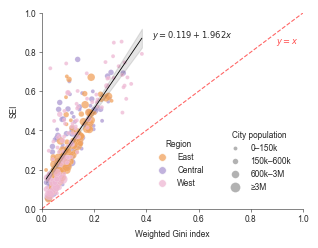

In [637]:
# ======================================================
# ⭐ 全局字体（PDF 可编辑）
# ======================================================
mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial"],
    "font.size": 6,
    "axes.labelsize": 6,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "legend.fontsize": 6,
    "font.weight": "normal",
    "axes.labelweight": "normal",
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "axes.unicode_minus": False
})

# =========================
# 单独一张图
# =========================
MM_TO_INCH = 1 / 25.4
fig_w_in = 80 * MM_TO_INCH
fig_h_in = (fig_w_in)/4*3

fig = plt.figure(figsize=(fig_w_in, fig_h_in))

ax = fig.add_subplot(1, 1, 1)

# ===========================
# 0️⃣ 数据准备
# ===========================

# 人口规模分组（气泡大小）
df_bubble_gini["population_category"] = pd.cut(
    df_bubble_gini["city_population"],
    bins=[0, 150_000, 600_000, 3_000_000, np.inf],
    labels=["0–150k", "150k–600k", "600k–3M", "≥3M"],
    right=False,
    include_lowest=True
)

size_map = {
    "0–150k": 8,
    "150k–600k": 16,
    "600k–3M": 30,
    "≥3M": 50
}
df_bubble_gini["bubble_size"] = df_bubble_gini["population_category"].map(size_map).astype(float)

region_colors = {
    "East": "#F1A25E",
    "Central": "#AC99D2",
    "West": "#EEB7D3"
}

# ===========================
# 主图：散点（按 region 上色）
# ===========================
for region, df_sub in df_bubble_gini.groupby("region"):
    ax.scatter(
        df_sub["gini_weighted"],
        df_sub["spatial_inequality"],
        s=df_sub["bubble_size"],
        color=region_colors.get(region, "grey"),
        alpha=0.75,
        edgecolor="white",
        linewidth=0.1
    )

# ===========================
# 回归线 + 95% CI
# ===========================
reg_df_gini = df_bubble_gini[["gini_weighted", "spatial_inequality"]].dropna()
x = reg_df_gini["gini_weighted"].to_numpy()
y = reg_df_gini["spatial_inequality"].to_numpy()

X = sm.add_constant(x)
model = sm.OLS(y, X).fit()

x_fit = np.linspace(x.min(), x.max(), 200)
y_fit = model.predict(sm.add_constant(x_fit))
ax.plot(x_fit, y_fit, color="black", linewidth=0.6, zorder=2)

ci = model.get_prediction(sm.add_constant(x_fit)).conf_int()
ax.fill_between(x_fit, ci[:, 0], ci[:, 1], color="black", alpha=0.1, zorder=1)

# ===========================
# 45° 线
# ===========================
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)

ax.plot(
    [0, 1.0],
    [0, 1.0],
    linestyle="--",
    color="red",
    linewidth=0.8,
    alpha=0.6,
    zorder=1
)

ax.text(
    0.98, 0.88,
    r"$y = x$",
    color="red",
    fontsize=6,
    ha="right",
    va="top",
    alpha=0.7
)

# ===========================
# 坐标轴样式
# ===========================
ax.set_xticks(np.arange(0, 1.01, 0.2))
ax.set_yticks(np.arange(0, 1.01, 0.2))

ax.tick_params(
    axis="both",
    which="major",
    direction="out",
    length=2.0,
    width=0.4,
    pad=2,
    bottom=True,
    left=True,
    top=False,
    right=False
)

ax.set_xlabel("Weighted Gini index")
ax.set_ylabel("SEI")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(0.4)
ax.spines["bottom"].set_linewidth(0.4)

# ===========================
# 图例：人口规模
# ===========================
legend_sizes = [8, 16, 30, 50]
legend_labels = ["0–150k", "150k–600k", "600k–3M", "≥3M"]

legend_handles = [
    plt.scatter([], [], s=s, color="grey", alpha=0.6, edgecolor="white", linewidth=0.1)
    for s in legend_sizes
]

pop_legend = ax.legend(
    legend_handles,
    legend_labels,
    title="City population",
    loc="lower left",
    bbox_to_anchor=(0.68, 0.05),
    frameon=False,
    fontsize=6,
    title_fontsize=6
)
ax.add_artist(pop_legend)

# ===========================
# 图例：Region
# ===========================
region_handles = [
    plt.scatter([], [], s=30, color=color, alpha=0.75, edgecolor="white",
                linewidth=0.5, label=region)
    for region, color in region_colors.items()
]

ax.legend(
    handles=region_handles,
    title="Region",
    loc="lower left",
    bbox_to_anchor=(0.40, 0.07),
    frameon=False,
    fontsize=6,
    title_fontsize=6
)

# ===========================
# 标注回归方程
# ===========================
intercept = model.params[0]
slope = model.params[1]
reg_text = r"$y = {:.3f} + {:.3f}x$".format(intercept, slope)

ax.text(
    0.42, 0.92,
    reg_text,
    transform=ax.transAxes,
    ha="left",
    va="top",
    fontsize=6,
    bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=1.5)
)

fig.subplots_adjust(left=0.12, right=0.95, bottom=0.12, top=0.95)

fig.savefig(
    "S8.pdf",
    format="pdf",
    dpi=300
)

plt.show()

## S9

In [638]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df_spatial_inequality[
    ["access_weighted_median_z",
     "log_city_population_z",
     "city_nightlight_z",
     "log_city_area_z"]
]

X = sm.add_constant(X)

vif_df = pd.DataFrame()
vif_df["Variable"] = X.columns
vif_df["VIF"] = [
    variance_inflation_factor(X.values, i)
    for i in range(X.shape[1])
]

rename_map = {
    "access_weighted_median_z": "Healthcare accessibility",
    "log_city_population_z": "Population",
    "city_nightlight_z": "Nighttime light intensity",
    "log_city_area_z": "Area"
}

vif_df["Variable"] = vif_df["Variable"].replace(rename_map)

print(vif_df)

                    Variable       VIF
0                      const  1.000000
1   Healthcare accessibility  1.123885
2                 Population  1.542367
3  Nighttime light intensity  1.255110
4                       Area  1.268511


## S12

In [639]:
grouped = df_cluster.groupby("hc_cluster")["hh_patch_share"]

data = []
labels = []

for name, values in grouped:
    values = values.dropna()
    if len(values) > 0:
        data.append(values)
        labels.append(name)

H_stat, p_value = kruskal(*data)

print("hh_patch_share:", labels)
print(f"Kruskal–Wallis H = {H_stat:.3f}")
print(f"p-value = {p_value:.4f}")

hh_patch_share: [1, 2, 3, 4]
Kruskal–Wallis H = 80.293
p-value = 0.0000


In [640]:
grouped = df_cluster.groupby("hc_cluster")["cv_access_hh"]

data = []
labels = []

for name, values in grouped:
    values = values.dropna()
    if len(values) > 0:
        data.append(values)
        labels.append(name)

H_stat, p_value = kruskal(*data)

print("cv_access_hh:", labels)
print(f"Kruskal–Wallis H = {H_stat:.3f}")
print(f"p-value = {p_value:.4f}")

cv_access_hh: [1, 2, 3, 4]
Kruskal–Wallis H = 32.745
p-value = 0.0000


In [641]:
grouped = df_cluster.groupby("hc_cluster")["distance_outside_patch"]

data = []
labels = []

for name, values in grouped:
    values = values.dropna()
    if len(values) > 0:
        data.append(values)
        labels.append(name)

H_stat, p_value = kruskal(*data)

print("distance_outside_patch:", labels)
print(f"Kruskal–Wallis H = {H_stat:.3f}")
print(f"p-value = {p_value:.4f}")

distance_outside_patch: [1, 2, 3, 4]
Kruskal–Wallis H = 27.887
p-value = 0.0000


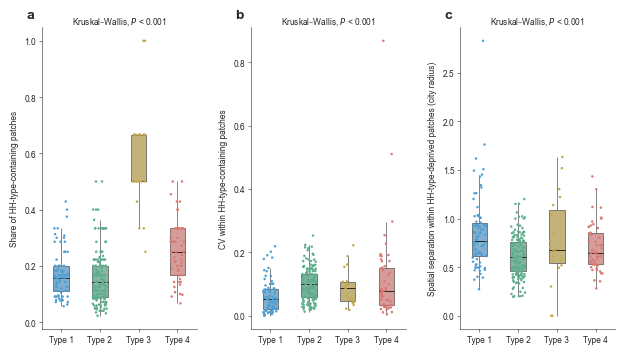

In [642]:
np.random.seed(42)

# ======================================================
# ⭐ 全局字体（PDF 可编辑）
# ======================================================
mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial"],
    "font.size": 6,
    "axes.labelsize": 6,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "legend.fontsize": 6,
    "font.weight": "normal",
    "axes.labelweight": "normal",
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "axes.unicode_minus": False
})

# ======================================================
# 画布：7×4（你要求的）
# ======================================================
MM_TO_INCH = 1 / 25.4
fig_w_in = 160 * MM_TO_INCH
fig_h_in = (fig_w_in)/7*4

fig = plt.figure(figsize=(fig_w_in, fig_h_in))

gs = GridSpec(
    nrows=1,
    ncols=3,
    figure=fig,
    wspace=0.35,
    hspace=0.0
)

ax_a = fig.add_subplot(gs[0, 0])
ax_b = fig.add_subplot(gs[0, 1])
ax_c = fig.add_subplot(gs[0, 2])

# ======================================================
# 共享设置
# ======================================================
cluster_names = {1: "Type 1", 2: "Type 2", 3: "Type 3", 4: "Type 4"}
order = [cluster_names[c] for c in sorted(cluster_names.keys())]
palette = ["#5FAF8E", "#4F9FD3", "#D97973", "#C4A84A"]

def draw_panel(ax, ycol, ylabel):
    df_long = df_cluster[["hc_cluster", ycol]].dropna().copy()
    df_long["cluster_name"] = df_long["hc_cluster"].map(cluster_names)

    sns.boxplot(
        x="cluster_name",
        y=ycol,
        data=df_long,
        order=order,
        palette=palette,
        width=0.4,
        showcaps=False,
        showfliers=False,
        hue="cluster_name",
        boxprops={'linewidth': 0.5, 'zorder': 2},
        whiskerprops={'linewidth': 0.5, 'zorder': 2},
        medianprops={'color': 'black', 'linewidth': 0.55, 'zorder': 3},
        ax=ax
    )

    # 箱体透明度
    for patch in ax.patches:
        fc = patch.get_facecolor()
        patch.set_facecolor(mcolors.to_rgba(fc, alpha=0.8))

    sns.stripplot(
        x="cluster_name",
        y=ycol,
        data=df_long,
        order=order,
        hue="cluster_name",
        palette=palette,
        dodge=False,
        size=1.8,
        jitter=0.18,
        alpha=1.0,
        zorder=4,
        ax=ax,
        legend=False
    )

    ax.set_xlabel("")
    ax.set_ylabel(ylabel)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(0.4)
    ax.spines["bottom"].set_linewidth(0.4)

    ax.tick_params(
        axis="both",
        which="major",
        direction="out",
        length=2,
        width=0.4,
        pad=2,
        bottom=True,
        left=True,
        top=False,
        right=False
    )

    # 顶部总体显著性标注
    ax.text(
        0.5,
        1.0,
        r"Kruskal–Wallis, $\it{P}$ < 0.001",
        transform=ax.transAxes,
        ha="center",
        va="bottom",
        fontsize=6
    )

# ======================================================
# 三个子图
# ======================================================
draw_panel(ax_a, "hh_patch_share", "Share of HH-type-containing patches")
draw_panel(ax_b, "cv_access_hh", "CV within HH-type-containing patches")
draw_panel(ax_c, "distance_outside_patch", "Spatial separation within HH-type-deprived patches (city radius)")

# ======================================================
# 子图编号（A–C）
# ======================================================
for ax, lab in zip([ax_a, ax_b, ax_c], ["a", "b", "c"]):
    ax.text(
        -0.05, 1.02, lab,
        transform=ax.transAxes,
        fontsize=10,
        fontweight="bold",
        va="bottom",
        ha="right"
    )

# ======================================================
# 导出（可选）
# ======================================================
fig.subplots_adjust(left=0.07, right=0.98, top=0.92, bottom=0.08)
fig.savefig("S12.pdf", format="pdf", dpi=300)

plt.show()

## S13

In [654]:
import scikit_posthocs as sp

# Dunn’s test with Holm correction
dunn_res = sp.posthoc_dunn(
    df_cluster,
    val_col="hh_patch_share",
    group_col="hc_cluster",
    p_adjust="holm"
)

dunn_res

,1,2,3,4
1,1.000000e+00,2.155331e-01,2.465810e-10,1.767253e-04
2,2.155331e-01,1.000000e+00,1.218237e-13,7.810872e-08
3,2.465810e-10,1.218237e-13,1.000000e+00,6.017662e-04
4,1.767253e-04,7.810872e-08,6.017662e-04,1.000000e+00


In [655]:
# Dunn’s test with Holm correction
dunn_res = sp.posthoc_dunn(
    df_cluster,
    val_col="hh_patch_pop_share",
    group_col="hc_cluster",
    p_adjust="holm"
)

dunn_res

,1,2,3,4
1,1.000000e+00,2.912572e-31,1.139133e-18,1.482637e-05
2,2.912572e-31,1.000000e+00,4.475550e-03,6.563604e-07
3,1.139133e-18,4.475550e-03,1.000000e+00,7.353782e-08
4,1.482637e-05,6.563604e-07,7.353782e-08,1.000000e+00


In [656]:
# Dunn’s test with Holm correction
dunn_res = sp.posthoc_dunn(
    df_cluster,
    val_col="cv_access_weighted",
    group_col="hc_cluster",
    p_adjust="holm"
)

dunn_res

,1,2,3,4
1,1.000000e+00,1.667511e-18,1.381258e-12,3.618383e-01
2,1.667511e-18,1.000000e+00,1.657611e-02,4.909851e-11
3,1.381258e-12,1.657611e-02,1.000000e+00,5.221095e-10
4,3.618383e-01,4.909851e-11,5.221095e-10,1.000000e+00


In [657]:
# Dunn’s test with Holm correction
dunn_res = sp.posthoc_dunn(
    df_cluster,
    val_col="cv_access_hh",
    group_col="hc_cluster",
    p_adjust="holm"
)

dunn_res

,1,2,3,4
1,1.000000e+00,6.508474e-08,0.161269,0.006690
2,6.508474e-08,1.000000e+00,0.570255,0.533468
3,1.612691e-01,5.702547e-01,1.000000,0.862174
4,6.690244e-03,5.334682e-01,0.862174,1.000000


In [658]:
# Dunn’s test with Holm correction
dunn_res = sp.posthoc_dunn(
    df_cluster,
    val_col="cv_access_non_hh",
    group_col="hc_cluster",
    p_adjust="holm"
)

dunn_res

,1,2,3,4
1,1.000000,0.811968,5.680353e-04,5.680353e-04
2,0.811968,1.000000,2.391353e-04,2.419550e-04
3,0.000568,0.000239,1.000000e+00,9.040102e-09
4,0.000568,0.000242,9.040102e-09,1.000000e+00


In [659]:
# Dunn’s test with Holm correction
dunn_res = sp.posthoc_dunn(
    df_cluster,
    val_col="distance_within_patch",
    group_col="hc_cluster",
    p_adjust="holm"
)

dunn_res

,1,2,3,4
1,1.000000e+00,4.330326e-02,0.000003,2.991775e-15
2,4.330326e-02,1.000000e+00,0.000249,3.790219e-12
3,2.924940e-06,2.493755e-04,1.000000,5.082898e-01
4,2.991775e-15,3.790219e-12,0.508290,1.000000e+00


In [660]:
# Dunn’s test with Holm correction
dunn_res = sp.posthoc_dunn(
    df_cluster,
    val_col="distance_outside_patch",
    group_col="hc_cluster",
    p_adjust="holm"
)

dunn_res

,1,2,3,4
1,1.000000,0.000001,0.649732,0.169058
2,0.000001,1.000000,0.180677,0.169058
3,0.649732,0.180677,1.000000,0.649732
4,0.169058,0.169058,0.649732,1.000000


In [661]:
# Dunn’s test with Holm correction
dunn_res = sp.posthoc_dunn(
    df_spatial_inequality,
    val_col="spatial_inequality",
    group_col="hc_cluster",
    p_adjust="holm"
)

dunn_res

,1,2,3,4
1,1.000000e+00,3.939145e-24,8.771542e-09,6.986186e-02
2,3.939145e-24,1.000000e+00,6.245823e-01,2.344446e-10
3,8.771542e-09,6.245823e-01,1.000000e+00,4.678774e-05
4,6.986186e-02,2.344446e-10,4.678774e-05,1.000000e+00


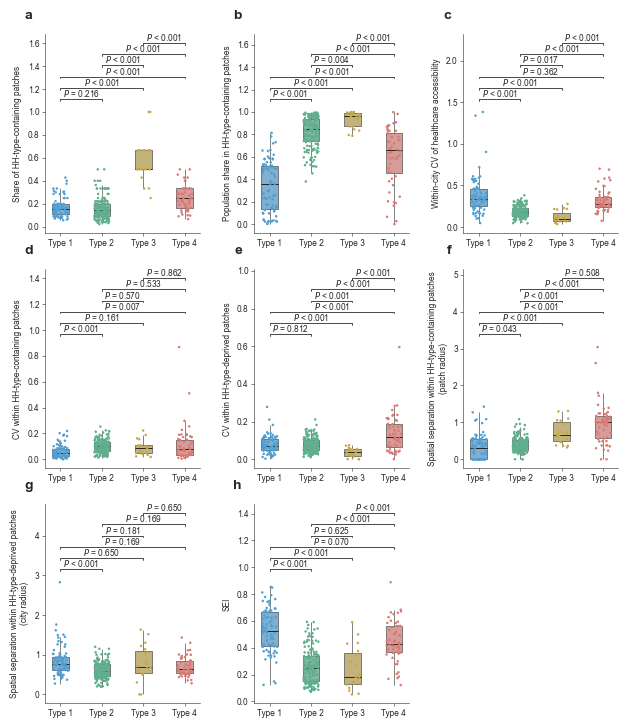

In [662]:
np.random.seed(42)

# ======================================================
# ⭐ 全局字体（PDF 可编辑）
# ======================================================
mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial"],
    "font.size": 6,
    "axes.labelsize": 6,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "legend.fontsize": 6,
    "font.weight": "normal",
    "axes.labelweight": "normal",
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "axes.unicode_minus": False
})

# ======================================================
# ⭐ 统一设置
# ======================================================
cluster_names = {1: "Type 1", 2: "Type 2", 3: "Type 3", 4: "Type 4"}
order = [cluster_names[c] for c in sorted(cluster_names.keys())]

palette = [
    "#5FAF8E",  # Type 1
    "#4F9FD3",  # Type 2
    "#D97973",  # Type 3
    "#C4A84A",  # Type 4
]

def add_pairwise_pvals(ax, df_long, y_col, order, p_values, fontsize=6):
    """在 ax 上添加两两比较显著性标注（与你参考代码一致：基于 y_range）"""
    y_max = df_long[y_col].max()
    y_min = df_long[y_col].min()
    y_range = y_max - y_min if y_max > y_min else 1.0

    h = y_range * 0.015
    step = y_range * 0.1
    pos = {name: i for i, name in enumerate(order)}
    current_height = y_max + step

    for (g1, g2), p in p_values.items():
        x1, x2 = pos[g1], pos[g2]
        ax.plot(
            [x1, x1, x2, x2],
            [current_height, current_height + h, current_height + h, current_height],
            lw=0.5, c="black"
        )
        text_p = r"$\it{P}$ < 0.001" if p < 0.001 else rf"$\it{{P}}$ = {p:.3f}"
        ax.text(
            (x1 + x2) / 2, current_height + h,
            text_p, ha="center", va="bottom", fontsize=fontsize
        )
        current_height += step

def plot_one(ax, df_long, y_col, y_label, p_values, show_ylabel=True):
    """画单个子图：box + strip + 透明度 + 轴样式 + 两两p值"""
    # boxplot
    sns.boxplot(
        x="cluster_name", y=y_col,
        data=df_long, order=order,
        palette=palette,
        width=0.4,
        showcaps=False,
        showfliers=False,
        hue="cluster_name",
        boxprops={'linewidth': 0.5, 'zorder': 2},
        whiskerprops={'linewidth': 0.5, 'zorder': 2},
        medianprops={'color': 'black', 'linewidth': 0.55, 'zorder': 3},
        ax=ax
    )

    # 透明度
    for patch in ax.patches:
        fc = patch.get_facecolor()
        patch.set_facecolor(mcolors.to_rgba(fc, alpha=0.8))

    # stripplot
    sns.stripplot(
        x="cluster_name", y=y_col,
        data=df_long, order=order,
        hue="cluster_name",
        palette=palette,
        dodge=False,
        size=1.8,
        jitter=0.18,
        alpha=1.0,
        zorder=4,
        ax=ax,
        legend=False
    )

    # 轴样式
    ax.set_xlabel("")
    ax.set_ylabel(y_label if show_ylabel else "")
    ax.set_title("")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(0.4)
    ax.spines["bottom"].set_linewidth(0.4)

    ax.tick_params(
        axis="both", which="major",
        direction="out", length=2, width=0.4, pad=2,
        bottom=True, left=True, top=False, right=False
    )

    # 去掉自动 legend（因为 hue=cluster_name 会生成）
    leg = ax.get_legend()
    if leg is not None:
        leg.remove()

    # 两两p值
    add_pairwise_pvals(ax, df_long, y_col, order, p_values, fontsize=6)

# ======================================================
# ✅ 8 个子图的数据与 p 值配置（按你给的版本）
# ======================================================
plots = [
    # A
    dict(
        source="df_cluster",
        cols=["hc_cluster", "hh_patch_share"],
        y_col="hh_patch_share",
        y_label="Share of HH-type-containing patches",
        p_values = {
            ('Type 1', 'Type 2'): 0.2155331,
            ('Type 1', 'Type 3'): 2.465810e-10,
            ('Type 1', 'Type 4'): 1.767253e-04,
            ('Type 2', 'Type 3'): 1.218237e-13,
            ('Type 2', 'Type 4'): 7.810872e-08,
            ('Type 3', 'Type 4'): 6.017662e-04,
        }
    ),
    # B
    dict(
        source="df_cluster",
        cols=["hc_cluster", "hh_patch_pop_share"],
        y_col="hh_patch_pop_share",
        y_label="Population share in HH-type-containing patches",
        p_values = {
            ('Type 1', 'Type 2'): 2.912572e-31,
            ('Type 1', 'Type 3'): 1.139133e-18,
            ('Type 1', 'Type 4'): 1.482637e-05,
            ('Type 2', 'Type 3'): 4.475550e-03,
            ('Type 2', 'Type 4'): 6.563604e-07,
            ('Type 3', 'Type 4'): 7.353782e-08,
        }
    ),
    # C
    dict(
        source="df_cluster",
        cols=["hc_cluster", "cv_access_weighted"],
        y_col="cv_access_weighted",
        y_label="Within-city CV of healthcare accessibility",
        p_values = {
            ('Type 1', 'Type 2'): 1.667511e-18,
            ('Type 1', 'Type 3'): 1.381258e-12,
            ('Type 1', 'Type 4'): 3.618383e-01,
            ('Type 2', 'Type 3'): 1.657611e-02,
            ('Type 2', 'Type 4'): 4.909851e-11,
            ('Type 3', 'Type 4'): 5.221095e-10,
        }
    ),
    # D
    dict(
        source="df_cluster",
        cols=["hc_cluster", "cv_access_hh"],
        y_col="cv_access_hh",
        y_label="CV within HH-type-containing patches",
        p_values = {
            ('Type 1', 'Type 2'): 6.508474e-08,
            ('Type 1', 'Type 3'): 0.161269,
            ('Type 1', 'Type 4'): 0.006690,
            ('Type 2', 'Type 3'): 0.570255,
            ('Type 2', 'Type 4'): 0.533468,
            ('Type 3', 'Type 4'): 0.862174,
        }
    ),
    # E
    dict(
        source="df_cluster",
        cols=["hc_cluster", "cv_access_non_hh"],
        y_col="cv_access_non_hh",
        y_label="CV within HH-type-deprived patches",
        p_values = {
            ('Type 1', 'Type 2'): 0.811968,
            ('Type 1', 'Type 3'): 5.680353e-04,
            ('Type 1', 'Type 4'): 5.680353e-04,
            ('Type 2', 'Type 3'): 2.391353e-04,
            ('Type 2', 'Type 4'): 2.419550e-04,
            ('Type 3', 'Type 4'): 9.040102e-09,
        }
    ),
    # F
    dict(
        source="df_cluster",
        cols=["hc_cluster", "distance_within_patch"],
        y_col="distance_within_patch",
        y_label="Spatial separation within HH-type-containing patches\n(patch radius)",
        p_values = {
            ('Type 1', 'Type 2'): 4.330326e-02,
            ('Type 1', 'Type 3'): 2.924940e-06,
            ('Type 1', 'Type 4'): 2.991775e-15,
            ('Type 2', 'Type 3'): 2.493755e-04,
            ('Type 2', 'Type 4'): 3.790219e-12,
            ('Type 3', 'Type 4'): 5.082898e-01,
        }
    ),
    # G
    dict(
        source="df_cluster",
        cols=["hc_cluster", "distance_outside_patch"],
        y_col="distance_outside_patch",
        y_label="Spatial separation within HH-type-deprived patches\n(city radius)",
        p_values = {
            ('Type 1', 'Type 2'): 1.0e-06,
            ('Type 1', 'Type 3'): 0.649732,
            ('Type 1', 'Type 4'): 0.169058,
            ('Type 2', 'Type 3'): 0.180677,
            ('Type 2', 'Type 4'): 0.169058,
            ('Type 3', 'Type 4'): 0.649732,
        }
    ),

    # H（第 8 个图：df_spatial_inequality）
dict(
    source="df_spatial_inequality",
    cols=["hc_cluster", "spatial_inequality"],
    y_col="spatial_inequality",
    y_label="SEI",
    p_values = {
    ('Type 1', 'Type 2'): 3.939145e-24,
    ('Type 1', 'Type 3'): 8.771542e-09,
    ('Type 1', 'Type 4'): 6.986186e-02,
    ('Type 2', 'Type 3'): 6.245823e-01,
    ('Type 2', 'Type 4'): 2.344446e-10,
    ('Type 3', 'Type 4'): 4.678774e-05,
}
),

]

# ======================================================
# ✅ 画布：3×3，尺寸 7×8
# ======================================================
MM_TO_INCH = 1 / 25.4
fig_w_in = 160 * MM_TO_INCH
fig_h_in = (fig_w_in)/7*8

fig = plt.figure(figsize=(fig_w_in, fig_h_in))

gs = GridSpec(nrows=3, ncols=3, figure=fig, wspace=0.35, hspace=0.18)

axes = [fig.add_subplot(gs[i, j]) for i in range(3) for j in range(3)]

# ======================================================
# ✅ 逐个子图绘制
# ======================================================
labels = list("abcdefghi")  # 9 个位置，最后1个会隐藏
for k, ax in enumerate(axes):
    if k < len(plots):
        cfg = plots[k]
        src_df = df_cluster if cfg["source"] == "df_cluster" else df_spatial_inequality

        df_long = src_df[cfg["cols"]].dropna().copy()
        df_long["cluster_name"] = df_long["hc_cluster"].map(cluster_names)

        plot_one(
            ax=ax,
            df_long=df_long,
            y_col=cfg["y_col"],
            y_label=cfg["y_label"],
            p_values=cfg["p_values"],
            show_ylabel=True
        )

        # 子图编号
        ax.text(
            -0.08, 1.06, labels[k],
            transform=ax.transAxes,
            fontsize=10,
            fontweight="bold",
            va="bottom",
            ha="right"
        )
    else:
        ax.axis("off")

# ======================================================
# ✅ 导出（可选）
# ======================================================
fig.subplots_adjust(left=0.07, right=0.98, top=0.96, bottom=0.03)
fig.savefig("S13.pdf", format="pdf", dpi=300)

plt.show()

## S15

In [643]:
# 最大社区数的城市
max_city = df_global_Moran_I.nlargest(1, 'n_communities')[["city_code", "n_communities"]]
print("最大社区数城市:")
print(max_city)

# 中位数附近的城市
median_val = df_global_Moran_I['n_communities'].median()
median_city = (
    df_global_Moran_I.iloc[
        (df_global_Moran_I['n_communities'] - median_val).abs().argsort()[:1]
    ][["city_code", "n_communities"]]
)
print("中间社区数城市:")
print(median_city)

# 最小社区数的城市
min_city = df_global_Moran_I.nsmallest(1, 'n_communities')[["city_code", "n_communities"]]
print("最小社区数城市:")
print(min_city)

最大社区数城市:
  city_code  n_communities
0    110000           2268
中间社区数城市:
   city_code  n_communities
29    150600            183
最小社区数城市:
    city_code  n_communities
249    511900             32


In [644]:
warnings.filterwarnings("ignore", category=UserWarning)

# ==============================
# 参数设置
# ==============================

# 典型城市（大 / 中 / 小）
typical_cities = ['110000', '150600', '511900']

# k 的取值范围
k_values = [2, 4, 6, 8, 10, 12]

# --------------------------------------------------
# ✅ 投影：WGS84 → Krasovsky 1940 Albers（与主分析一致）
# --------------------------------------------------
transformer = Transformer.from_crs(
    "EPSG:4326",
    china.crs,          # ⭐ 关键修改点
    always_xy=True
)

sensitivity_results = []

# ==============================
# 稳健性分析主循环
# ==============================

for city in typical_cities:

    sub = df_spatial_filter[df_spatial_filter['city_code'] == city]
    if sub.empty:
        continue

    # --------------------------------------------------
    # Step 0️⃣：经纬度 → Albers 投影坐标（单位：米）
    # --------------------------------------------------
    lon = sub['lon'].values.astype(float)
    lat = sub['lat'].values.astype(float)
    x_proj, y_proj = transformer.transform(lon, lat)
    coords_proj = np.column_stack([x_proj, y_proj])

    # Moran 变量
    x = sub['access'].values.astype(float)

    for k in k_values:

        # ------------------------------
        # Step 1️⃣：KNN 空间权重
        # ------------------------------
        w_knn = KNN.from_array(coords_proj, k=k)
        w_knn.transform = 'r'

        used_mst = False

        # ------------------------------
        # Step 2️⃣：若 KNN 不连通，用 MST 兜底
        # ------------------------------
        if w_knn.n_components > 1:
            used_mst = True

            # 欧氏距离（米）
            dist_matrix = np.sqrt(
                ((coords_proj[:, None, :] - coords_proj[None, :, :]) ** 2).sum(axis=2)
            )

            # 最小生成树
            mst = minimum_spanning_tree(dist_matrix).toarray()
            mst_binary = (mst + mst.T) > 0

            neighbors_mst = {
                i: list(np.where(row)[0])
                for i, row in enumerate(mst_binary)
            }
            w_mst = W(neighbors_mst)

            # 合并 KNN + MST（去重，二值）
            sparse_combined = (w_knn.sparse + w_mst.sparse) > 0
            w = W.from_sparse(sparse_combined.astype(int))
            w.transform = 'r'

        else:
            w = w_knn

        # ------------------------------
        # Step 3️⃣：Moran's I
        # ------------------------------
        mi = Moran(x, w, permutations=9999)

        sensitivity_results.append({
            "city_code": city,
            "k": k,
            "Moran_I": mi.I,
            "p_value": mi.p_sim,
            "z_score": mi.z_norm,
            "used_mst": used_mst,
            "n_knn_components": w_knn.n_components
        })

# ==============================
# 结果整理
# ==============================

df_sensitivity = pd.DataFrame(sensitivity_results)

summary = (
    df_sensitivity
    .groupby('city_code')
    .agg(
        Moran_I_min=('Moran_I', 'min'),
        Moran_I_max=('Moran_I', 'max'),
        Moran_I_mean=('Moran_I', 'mean'),
        p_value_min=('p_value', 'min'),
        p_value_max=('p_value', 'max')
    )
    .reset_index()
)

summary['I_range'] = summary['Moran_I_max'] - summary['Moran_I_min']

print("Moran's I and p-value Sensitivity Summary for Typical Cities")
print(summary)

Moran's I and p-value Sensitivity Summary for Typical Cities
  city_code  Moran_I_min  Moran_I_max  Moran_I_mean  p_value_min  p_value_max  \
0    110000     0.656654     0.675701      0.664956       0.0001       0.0001   
1    150600     0.827871     0.920695      0.862209       0.0001       0.0001   
2    511900     0.496078     0.826334      0.717263       0.0001       0.0001   

    I_range  
0  0.019047  
1  0.092823  
2  0.330256  


## S16

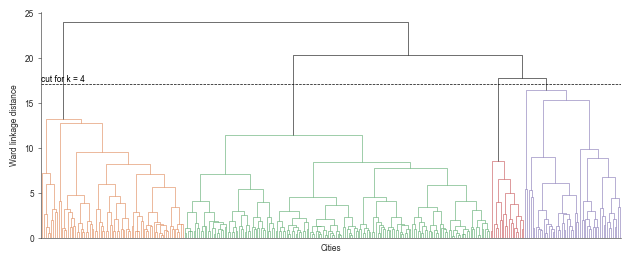

In [649]:
mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial"],
    "font.size": 6,
    "axes.labelsize": 6,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "legend.fontsize": 6,
    "font.weight": "normal",
    "axes.labelweight": "normal",
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "axes.unicode_minus": False
})

features = [
    "hh_patch_share",
    "hh_patch_pop_share",
    "cv_access_weighted",
    "cv_access_hh",
    "cv_access_non_hh",
    "distance_within_patch",
    "distance_outside_patch",
]

df_cluster = df_spatial_inequality[features].dropna().copy()

scaler = StandardScaler()
X = scaler.fit_transform(df_cluster.values)

Z = linkage(X, method="ward")

# -------------------------
# 关键：确定 k=4 的切割高度
# -------------------------
n_clusters = 4
n = X.shape[0]

# 两个关键合并距离：保持 k 个簇的最后一次合并距离 vs 再往上会变成 k-1 个簇
d_k   = Z[n - n_clusters - 1, 2]
d_km1 = Z[n - n_clusters,     2]

# 取中点作为阈值；如果两者相等（tie），就稍微往下挪一点点，避免“切在结点上”
cut_height = (d_k + d_km1) / 2 if d_km1 > d_k else (d_k - 1e-10)

MM_TO_INCH = 1 / 25.4
fig_w_in = 160 * MM_TO_INCH
fig_h_in = (fig_w_in)/7*3

fig = plt.figure(figsize=(fig_w_in, fig_h_in))
ax = fig.add_subplot(1, 1, 1)

dendrogram(
    Z,
    ax=ax,
    no_labels=True,
    color_threshold=cut_height,
    above_threshold_color="black"
)

# ✅ 统一设置 dendrogram 线宽
for coll in ax.collections:
    coll.set_linewidth(0.4)



# 切割线
ax.axhline(cut_height, color="black", lw=0.5, ls="--")

# 给切割线加名字（推荐）
ax.text(
    0.01, cut_height,
    "cut for k = 4",
    va="bottom", ha="left",
    fontsize=6,
    color="black"
)

# 轴标签
ax.set_ylabel("Ward linkage distance")
ax.set_xlabel("Cities")

# ✅ 去掉右边框和上边框
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_linewidth(0.4)
ax.spines["bottom"].set_linewidth(0.4)


# ✅ 纵轴加刻度线（明确打开）
ax.yaxis.set_ticks_position("left")
ax.tick_params(axis="y", which="both", length=2, width=0.4)
ax.tick_params(axis="x", bottom=False) 

fig.subplots_adjust(left=0.06, right=0.98, top=0.92, bottom=0.08)
fig.savefig("S16.pdf", format="pdf", dpi=300)

plt.show()